# Regression using a Neural Network (Pytorch)
The data is in 'housing.csv'. <br>
Each row in the table is a data point:  the features of an area in California <br>
Clearly, the `median_house_value` is correlated with some other features, e.g., `median_income` and location <br>
Thus, we can estimate `median_house_value` = regression_model(`median_income`, `longitude`, `latitude`, ...) <br>
The taks is to build an MLP regressor to predict `median_house_value` using the other features

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
housing = pd.read_csv("housing.csv")
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [3]:
housing.shape

(20640, 10)

### Data pre-processing: remove NaN

In [4]:
housing.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [5]:
# there are 207 NaN in the column 'total_bedrooms', remove them
# check housing again using housing.isnull().sum()
housing['total_bedrooms'].fillna((housing['total_bedrooms'].mean()), inplace=True)
housing.isnull().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

### Data pre-processing: Convert categorical data to numerical data - "ocean_proximity"

In [6]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [7]:
#We can use one-hot encoding method by calling pd.get_dummies
categorical_columns=['ocean_proximity'] # must be a list
housing = pd.get_dummies(housing, columns=categorical_columns)
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,0,0,0,1,0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,0,0,0,1,0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,0,0,0,1,0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,0,0,0,1,0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,0,0,0,1,0


### Visualize the data

Text(0.5, 1.0, 'median_income')

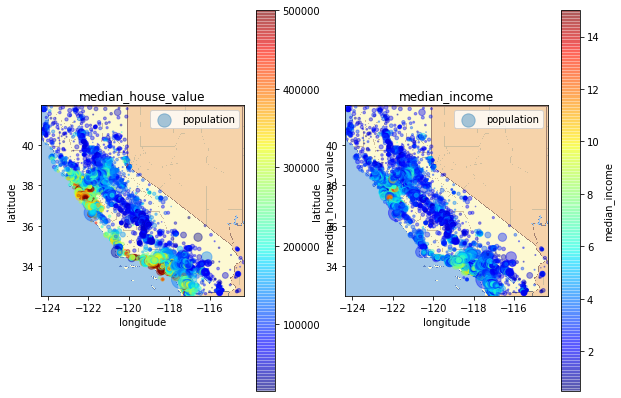

In [8]:
from skimage.io import imread
california_img = imread('california.png')
x1 = min(housing["longitude"].values)
x2 = max(housing["longitude"].values)
y1 = min(housing["latitude"].values)
y2 = max(housing["latitude"].values)
#---------------------------------------------
# the parameter c refers to color
# thus, median_house_value is color-coded in the left plot
fig, ax =plt.subplots(1,2)
housing.plot(ax=ax[0], kind="scatter", x="longitude", y="latitude",
             s=housing['population']/100, label="population",
             c="median_house_value", cmap=plt.get_cmap("jet"),
             colorbar=True, alpha=0.4, figsize=(10,7))
#---------------------------------------------
# the parameter c refers to color
# thus, median_income is color-coded in the right plot
ax[0].imshow(california_img,extent=[x1,x2,y1,y2])
ax[0].set_title('median_house_value')
housing.plot(ax=ax[1], kind="scatter", x="longitude", y="latitude",
             s=housing['population']/100, label="population",
             c="median_income", cmap=plt.get_cmap("jet"),
             colorbar=True, alpha=0.4, figsize=(10,7))
ax[1].imshow(california_img,extent=[x1,x2,y1,y2])
ax[1].set_title('median_income')

### Prepare the Training and Testing Datasets

In [9]:
X=housing.drop(['median_house_value'], axis=1)
X.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,0,0,0,1,0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,0,0,0,1,0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,0,0,0,1,0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,0,0,0,1,0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,0,0,0,1,0


In [10]:
Y=housing['median_house_value']
Y.head()

0    452600.0
1    358500.0
2    352100.0
3    341300.0
4    342200.0
Name: median_house_value, dtype: float64

In [11]:
# convert pandas dataframe/series to numpy array
# sklearn functions may not work well with pandas data types
X_columns=X.columns #store the column names
X=X.values.astype('float32')
Y=Y.values.astype('float32')

### trainnig, validation, testing split

In [12]:
#trainnig, validation, testing split
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
#split X_train and Y_train into a 'pure' training set and a validation set
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=0)
print('train:', X_train.shape, Y_train.shape)
print('validation:', X_val.shape, Y_val.shape)
print('test:', X_test.shape, Y_test.shape)

train: (14860, 13) (14860,)
validation: (1652, 13) (1652,)
test: (4128, 13) (4128,)


In [13]:
#apply feature normalization to training, validation and test sets
from sklearn.preprocessing import MinMaxScaler
scalerX=MinMaxScaler()
scalerX.fit(X_train) # think about why fit to X_train, not X ?
X_train=scalerX.transform(X_train)
X_val=scalerX.transform(X_val)
X_test=scalerX.transform(X_test)

In [14]:
X_train[0]

array([0.5786848 , 0.38044596, 0.19607843, 0.12570114, 0.13671634,
       0.00983827, 0.02795593, 0.11055019, 0.        , 1.        ,
       0.        , 0.        , 0.        ], dtype=float32)

In [15]:
#normalize the output to facilitate convergence
Y_train_max=Y_train.max()
Y_train/=Y_train_max
Y_val/=Y_train_max
Y_test/=Y_train_max

### use LinearRegression as the baseline model

In [16]:
#step1:
from sklearn.linear_model import LinearRegression
linear_model = LinearRegression(fit_intercept=True)

In [17]:
#step2:
linear_model.fit(X_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [18]:
linear_model.coef_

array([-0.5266758 , -0.47057664,  0.11070029, -0.3135648 ,  0.8725257 ,
       -2.8026886 ,  1.0090159 ,  1.130491  , -0.04725069, -0.12498099,
        0.2653832 , -0.05613023, -0.0370255 ], dtype=float32)

In [19]:
linear_model.intercept_

0.54965496

Evaluate model on testing set
MSE= 0.018863907
MAE= 0.09931182
MAPE= 0.28951442


Text(0, 0.5, 'Y_test_pred')

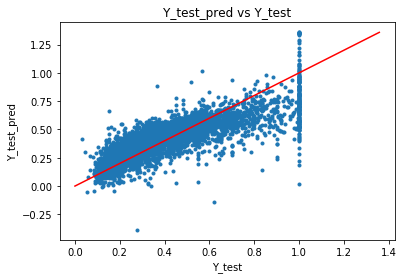

In [20]:
#step3:
Y_train_pred = linear_model.predict(X_train)
Y_test_pred = linear_model.predict(X_test)
print('Evaluate model on testing set')
MSE = np.mean((Y_test - Y_test_pred)**2)
MAE = np.mean(np.abs(Y_test - Y_test_pred))
MAPE =  np.mean(np.abs(Y_test - Y_test_pred)/Y_test)
print('MSE=', MSE)
print('MAE=', MAE)
print('MAPE=', MAPE)
#step6: 
# the red line is the 45-degree line
fig, ax = plt.subplots()
ax.set_title('Y_test_pred vs Y_test')
ax.plot(Y_test, Y_test_pred, '.')
ymax=np.max([Y_test.max(), Y_test_pred.max()])
ax.plot(np.linspace(0,ymax, 3), np.linspace(0, ymax, 3), '-r')
ax.set_xlabel('Y_test')
ax.set_ylabel('Y_test_pred')

## Your work begins here
see NN_nonlinear_regression_Pytorch.ipynb

#### define a dataset to hold/represent the data

In [21]:
#I give you the code here, because it is tricky
import torch
from torch.utils.data import Dataset as torch_dataset
class MyDataset(torch_dataset):
    def __init__(self, X, Y):
        self.X=X
        self.Y=Y.reshape(-1, 1) #this is very important
    def __len__(self):
        #return the number of data points
        return self.X.shape[0]
    def __getitem__(self, idx):        
        # use the notation DatasetName[idx]
        # to get a data point (x,y) by idx
        # we need to convert numpy array to torch tensor
        x=torch.tensor(self.X[idx], dtype=torch.float32)
        y=torch.tensor(self.Y[idx], dtype=torch.float32)
        return x, y

Create instance objects of the `MyDataset` class <br>
a training dataset `dataset_train` <br>
a validation dataset `dataset_val` <br>
a testing dataset `dataset_test` <br>

In [22]:
dataset_train = MyDataset(X_train, Y_train)
dataset_val = MyDataset(X_val, Y_val)
dataset_test = MyDataset(X_test, Y_test)

In [38]:
dataloader_train.dataset[0]

(tensor([0.5787, 0.3804, 0.1961, 0.1257, 0.1367, 0.0098, 0.0280, 0.1106, 0.0000,
         1.0000, 0.0000, 0.0000, 0.0000]), tensor([0.1982]))

In [28]:
len(dataset_train) # get the number of data points in the training set

14860

create dataloaders which will be used to generate minibatches <br>
batch_size=N means each minibatch contains N data points  <br>
note: the last minibatch may contain less than N data points

In [33]:
from torch.utils.data import DataLoader as torch_dataloader
dataloader_train = torch_dataloader(dataset_train, batch_size=128, shuffle=True)
dataloader_val = torch_dataloader(dataset_val, batch_size=128, shuffle=False) 
dataloader_test = torch_dataloader(dataset_test, batch_size=128, shuffle=False) 

In [34]:
len(dataloader_train) # get the number of minibatches

117

In [35]:
#verify the shape of each tensor in a batch
for batch_idx, (X, Y) in enumerate(dataloader_train):
    print(batch_idx, X.size(), Y.size())

0 torch.Size([128, 13]) torch.Size([128, 1])
1 torch.Size([128, 13]) torch.Size([128, 1])
2 torch.Size([128, 13]) torch.Size([128, 1])
3 torch.Size([128, 13]) torch.Size([128, 1])
4 torch.Size([128, 13]) torch.Size([128, 1])
5 torch.Size([128, 13]) torch.Size([128, 1])
6 torch.Size([128, 13]) torch.Size([128, 1])
7 torch.Size([128, 13]) torch.Size([128, 1])
8 torch.Size([128, 13]) torch.Size([128, 1])
9 torch.Size([128, 13]) torch.Size([128, 1])
10 torch.Size([128, 13]) torch.Size([128, 1])
11 torch.Size([128, 13]) torch.Size([128, 1])
12 torch.Size([128, 13]) torch.Size([128, 1])
13 torch.Size([128, 13]) torch.Size([128, 1])
14 torch.Size([128, 13]) torch.Size([128, 1])
15 torch.Size([128, 13]) torch.Size([128, 1])
16 torch.Size([128, 13]) torch.Size([128, 1])
17 torch.Size([128, 13]) torch.Size([128, 1])
18 torch.Size([128, 13]) torch.Size([128, 1])
19 torch.Size([128, 13]) torch.Size([128, 1])
20 torch.Size([128, 13]) torch.Size([128, 1])
21 torch.Size([128, 13]) torch.Size([128, 1]

#### Now, let's build a neural network that has many hidden layers and nonlinear activation - softplus

In [37]:
import torch.nn as nn
import torch.nn.functional as nnF
class Net(nn.Module):
    def __init__(self, input_dim, output_dim, n_units):
        super().__init__()
        self.layer1 = nn.Linear(input_dim, n_units)
        self.layer2 = nn.Linear(n_units, n_units)
        self.layer3 = nn.Linear(n_units, output_dim)        
    def forward(self, x):
        x=self.layer1(x)
        x=nnF.softplus(x)
        x=self.layer2(x)
        x=nnF.softplus(x)
        y=self.layer3(x)
        return y

create an instance object of the class

In [42]:
model=Net(input_dim=13, output_dim=1, n_units=128)

In [43]:
#move the model to GPU if you have a GPU
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

Net(
  (layer1): Linear(in_features=13, out_features=128, bias=True)
  (layer2): Linear(in_features=128, out_features=128, bias=True)
  (layer3): Linear(in_features=128, out_features=1, bias=True)
)

define a function to train the neural network in one epoch

In [45]:
def train(model, optimizer, dataloader, device, epoch):    
    model.train()#set model to train mode
    loss_train=0
    for batch_idx, (X, Y) in enumerate(dataloader):
        X, Y = X.to(device), Y.to(device)
        optimizer.zero_grad()#clear the grad of each parameter
        Yp = model(X)#forward pass
        loss = torch.mean((Yp-Y)**2) # MSE loss or other loss
        loss.backward()#backward pass
        optimizer.step()#update parameters
        loss_train+=loss.item()
        if batch_idx % 1 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * X.size(0), len(dataloader.dataset),
                    100. * batch_idx / len(dataloader), loss.item()))
    loss_train/=len(dataloader)
    return loss_train

define a function to evaluate the neural network on the validation set or the testing set

In [46]:
def test(model, dataloader, device):
    model.eval()#set model to evaluation mode
    loss_test=0
    mae_test=0
    sample_count=0
    with torch.no_grad(): # tell Pytorch not to build graph in the 'with' section
        for batch_idx, (X, Y) in enumerate(dataloader):
            X, Y = X.to(device), Y.to(device)
            Yp = model(X)#forward pass
            loss_test+=torch.sum((Yp-Y)**2).item()
            mae_test+= torch.sum((Yp-Y).abs()).item()
            sample_count+=X.size(0)
    loss_test/=sample_count
    mae_test/=sample_count
    return loss_test, mae_test

create an optimizer (e.g. Adam) and send the parameters of the model to the optimizer

In [44]:
import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr=0.01)

train the neural network model for many epochs <br>
It may need 100 epochs to converge.
So, we will not save any model to harddrive 

In [47]:
loss_train_list=[]
loss_val_list=[]

In [48]:
for epoch in range(0, 100):    
    #-------- perform training --------------------------------
    loss_train=train(model, optimizer, dataloader_train, device, epoch)    
    loss_train_list.append(loss_train)
    print('epoch', epoch, 'training loss:', loss_train)
    #-------- perform validation --------------------------------
    loss_val, mae_val = test(model, dataloader_val, device)
    loss_val_list.append(loss_val)
    print('epoch', epoch, 'validation loss:', loss_val)

Train Epoch: 0 [0/14860 (0%)]	Loss: 0.716204
Train Epoch: 0 [128/14860 (1%)]	Loss: 6.912271
Train Epoch: 0 [256/14860 (2%)]	Loss: 0.903294
Train Epoch: 0 [384/14860 (3%)]	Loss: 0.379296
Train Epoch: 0 [512/14860 (3%)]	Loss: 1.643690
Train Epoch: 0 [640/14860 (4%)]	Loss: 1.607072
Train Epoch: 0 [768/14860 (5%)]	Loss: 0.906621
Train Epoch: 0 [896/14860 (6%)]	Loss: 0.449518
Train Epoch: 0 [1024/14860 (7%)]	Loss: 0.217645
Train Epoch: 0 [1152/14860 (8%)]	Loss: 0.110985
Train Epoch: 0 [1280/14860 (9%)]	Loss: 0.061905
Train Epoch: 0 [1408/14860 (9%)]	Loss: 0.052055
Train Epoch: 0 [1536/14860 (10%)]	Loss: 0.058275
Train Epoch: 0 [1664/14860 (11%)]	Loss: 0.056347
Train Epoch: 0 [1792/14860 (12%)]	Loss: 0.071465
Train Epoch: 0 [1920/14860 (13%)]	Loss: 0.062261
Train Epoch: 0 [2048/14860 (14%)]	Loss: 0.064502
Train Epoch: 0 [2176/14860 (15%)]	Loss: 0.071594
Train Epoch: 0 [2304/14860 (15%)]	Loss: 0.066953
Train Epoch: 0 [2432/14860 (16%)]	Loss: 0.061382
Train Epoch: 0 [2560/14860 (17%)]	Loss: 0.

Train Epoch: 1 [6144/14860 (41%)]	Loss: 0.038244
Train Epoch: 1 [6272/14860 (42%)]	Loss: 0.041324
Train Epoch: 1 [6400/14860 (43%)]	Loss: 0.032056
Train Epoch: 1 [6528/14860 (44%)]	Loss: 0.041694
Train Epoch: 1 [6656/14860 (44%)]	Loss: 0.040505
Train Epoch: 1 [6784/14860 (45%)]	Loss: 0.047319
Train Epoch: 1 [6912/14860 (46%)]	Loss: 0.036929
Train Epoch: 1 [7040/14860 (47%)]	Loss: 0.042030
Train Epoch: 1 [7168/14860 (48%)]	Loss: 0.037721
Train Epoch: 1 [7296/14860 (49%)]	Loss: 0.056923
Train Epoch: 1 [7424/14860 (50%)]	Loss: 0.045715
Train Epoch: 1 [7552/14860 (50%)]	Loss: 0.031292
Train Epoch: 1 [7680/14860 (51%)]	Loss: 0.047597
Train Epoch: 1 [7808/14860 (52%)]	Loss: 0.037132
Train Epoch: 1 [7936/14860 (53%)]	Loss: 0.036890
Train Epoch: 1 [8064/14860 (54%)]	Loss: 0.037087
Train Epoch: 1 [8192/14860 (55%)]	Loss: 0.035372
Train Epoch: 1 [8320/14860 (56%)]	Loss: 0.042239
Train Epoch: 1 [8448/14860 (56%)]	Loss: 0.045386
Train Epoch: 1 [8576/14860 (57%)]	Loss: 0.033168
Train Epoch: 1 [8704

Train Epoch: 2 [12160/14860 (81%)]	Loss: 0.031239
Train Epoch: 2 [12288/14860 (82%)]	Loss: 0.018836
Train Epoch: 2 [12416/14860 (83%)]	Loss: 0.034432
Train Epoch: 2 [12544/14860 (84%)]	Loss: 0.029739
Train Epoch: 2 [12672/14860 (85%)]	Loss: 0.030604
Train Epoch: 2 [12800/14860 (85%)]	Loss: 0.036682
Train Epoch: 2 [12928/14860 (86%)]	Loss: 0.026406
Train Epoch: 2 [13056/14860 (87%)]	Loss: 0.028817
Train Epoch: 2 [13184/14860 (88%)]	Loss: 0.031527
Train Epoch: 2 [13312/14860 (89%)]	Loss: 0.024584
Train Epoch: 2 [13440/14860 (90%)]	Loss: 0.034947
Train Epoch: 2 [13568/14860 (91%)]	Loss: 0.027501
Train Epoch: 2 [13696/14860 (91%)]	Loss: 0.032957
Train Epoch: 2 [13824/14860 (92%)]	Loss: 0.024070
Train Epoch: 2 [13952/14860 (93%)]	Loss: 0.035350
Train Epoch: 2 [14080/14860 (94%)]	Loss: 0.030003
Train Epoch: 2 [14208/14860 (95%)]	Loss: 0.032485
Train Epoch: 2 [14336/14860 (96%)]	Loss: 0.030430
Train Epoch: 2 [14464/14860 (97%)]	Loss: 0.034718
Train Epoch: 2 [14592/14860 (97%)]	Loss: 0.032151


Train Epoch: 4 [3072/14860 (21%)]	Loss: 0.027218
Train Epoch: 4 [3200/14860 (21%)]	Loss: 0.023797
Train Epoch: 4 [3328/14860 (22%)]	Loss: 0.019376
Train Epoch: 4 [3456/14860 (23%)]	Loss: 0.027356
Train Epoch: 4 [3584/14860 (24%)]	Loss: 0.022867
Train Epoch: 4 [3712/14860 (25%)]	Loss: 0.031043
Train Epoch: 4 [3840/14860 (26%)]	Loss: 0.024979
Train Epoch: 4 [3968/14860 (26%)]	Loss: 0.025394
Train Epoch: 4 [4096/14860 (27%)]	Loss: 0.024579
Train Epoch: 4 [4224/14860 (28%)]	Loss: 0.021357
Train Epoch: 4 [4352/14860 (29%)]	Loss: 0.016767
Train Epoch: 4 [4480/14860 (30%)]	Loss: 0.018387
Train Epoch: 4 [4608/14860 (31%)]	Loss: 0.023384
Train Epoch: 4 [4736/14860 (32%)]	Loss: 0.019832
Train Epoch: 4 [4864/14860 (32%)]	Loss: 0.018428
Train Epoch: 4 [4992/14860 (33%)]	Loss: 0.018585
Train Epoch: 4 [5120/14860 (34%)]	Loss: 0.027251
Train Epoch: 4 [5248/14860 (35%)]	Loss: 0.017512
Train Epoch: 4 [5376/14860 (36%)]	Loss: 0.029364
Train Epoch: 4 [5504/14860 (37%)]	Loss: 0.028213
Train Epoch: 4 [5632

Train Epoch: 5 [9216/14860 (62%)]	Loss: 0.023468
Train Epoch: 5 [9344/14860 (62%)]	Loss: 0.024070
Train Epoch: 5 [9472/14860 (63%)]	Loss: 0.025281
Train Epoch: 5 [9600/14860 (64%)]	Loss: 0.022704
Train Epoch: 5 [9728/14860 (65%)]	Loss: 0.031842
Train Epoch: 5 [9856/14860 (66%)]	Loss: 0.017490
Train Epoch: 5 [9984/14860 (67%)]	Loss: 0.025396
Train Epoch: 5 [10112/14860 (68%)]	Loss: 0.021345
Train Epoch: 5 [10240/14860 (68%)]	Loss: 0.018522
Train Epoch: 5 [10368/14860 (69%)]	Loss: 0.020343
Train Epoch: 5 [10496/14860 (70%)]	Loss: 0.025516
Train Epoch: 5 [10624/14860 (71%)]	Loss: 0.017370
Train Epoch: 5 [10752/14860 (72%)]	Loss: 0.026627
Train Epoch: 5 [10880/14860 (73%)]	Loss: 0.022445
Train Epoch: 5 [11008/14860 (74%)]	Loss: 0.019322
Train Epoch: 5 [11136/14860 (74%)]	Loss: 0.016651
Train Epoch: 5 [11264/14860 (75%)]	Loss: 0.014191
Train Epoch: 5 [11392/14860 (76%)]	Loss: 0.023221
Train Epoch: 5 [11520/14860 (77%)]	Loss: 0.023396
Train Epoch: 5 [11648/14860 (78%)]	Loss: 0.020019
Train E

Train Epoch: 7 [0/14860 (0%)]	Loss: 0.017014
Train Epoch: 7 [128/14860 (1%)]	Loss: 0.018246
Train Epoch: 7 [256/14860 (2%)]	Loss: 0.021713
Train Epoch: 7 [384/14860 (3%)]	Loss: 0.018812
Train Epoch: 7 [512/14860 (3%)]	Loss: 0.018805
Train Epoch: 7 [640/14860 (4%)]	Loss: 0.026646
Train Epoch: 7 [768/14860 (5%)]	Loss: 0.015742
Train Epoch: 7 [896/14860 (6%)]	Loss: 0.017900
Train Epoch: 7 [1024/14860 (7%)]	Loss: 0.026000
Train Epoch: 7 [1152/14860 (8%)]	Loss: 0.015598
Train Epoch: 7 [1280/14860 (9%)]	Loss: 0.019137
Train Epoch: 7 [1408/14860 (9%)]	Loss: 0.010849
Train Epoch: 7 [1536/14860 (10%)]	Loss: 0.021341
Train Epoch: 7 [1664/14860 (11%)]	Loss: 0.023207
Train Epoch: 7 [1792/14860 (12%)]	Loss: 0.015286
Train Epoch: 7 [1920/14860 (13%)]	Loss: 0.023325
Train Epoch: 7 [2048/14860 (14%)]	Loss: 0.021006
Train Epoch: 7 [2176/14860 (15%)]	Loss: 0.019721
Train Epoch: 7 [2304/14860 (15%)]	Loss: 0.024705
Train Epoch: 7 [2432/14860 (16%)]	Loss: 0.026794
Train Epoch: 7 [2560/14860 (17%)]	Loss: 0.

Train Epoch: 8 [6144/14860 (41%)]	Loss: 0.020606
Train Epoch: 8 [6272/14860 (42%)]	Loss: 0.014567
Train Epoch: 8 [6400/14860 (43%)]	Loss: 0.017799
Train Epoch: 8 [6528/14860 (44%)]	Loss: 0.022877
Train Epoch: 8 [6656/14860 (44%)]	Loss: 0.016551
Train Epoch: 8 [6784/14860 (45%)]	Loss: 0.017491
Train Epoch: 8 [6912/14860 (46%)]	Loss: 0.022357
Train Epoch: 8 [7040/14860 (47%)]	Loss: 0.017499
Train Epoch: 8 [7168/14860 (48%)]	Loss: 0.016336
Train Epoch: 8 [7296/14860 (49%)]	Loss: 0.020702
Train Epoch: 8 [7424/14860 (50%)]	Loss: 0.023130
Train Epoch: 8 [7552/14860 (50%)]	Loss: 0.022704
Train Epoch: 8 [7680/14860 (51%)]	Loss: 0.022621
Train Epoch: 8 [7808/14860 (52%)]	Loss: 0.019180
Train Epoch: 8 [7936/14860 (53%)]	Loss: 0.012741
Train Epoch: 8 [8064/14860 (54%)]	Loss: 0.014419
Train Epoch: 8 [8192/14860 (55%)]	Loss: 0.019673
Train Epoch: 8 [8320/14860 (56%)]	Loss: 0.024488
Train Epoch: 8 [8448/14860 (56%)]	Loss: 0.014137
Train Epoch: 8 [8576/14860 (57%)]	Loss: 0.014167
Train Epoch: 8 [8704

Train Epoch: 9 [12160/14860 (81%)]	Loss: 0.025708
Train Epoch: 9 [12288/14860 (82%)]	Loss: 0.025547
Train Epoch: 9 [12416/14860 (83%)]	Loss: 0.018929
Train Epoch: 9 [12544/14860 (84%)]	Loss: 0.017865
Train Epoch: 9 [12672/14860 (85%)]	Loss: 0.018216
Train Epoch: 9 [12800/14860 (85%)]	Loss: 0.015095
Train Epoch: 9 [12928/14860 (86%)]	Loss: 0.024156
Train Epoch: 9 [13056/14860 (87%)]	Loss: 0.022322
Train Epoch: 9 [13184/14860 (88%)]	Loss: 0.020552
Train Epoch: 9 [13312/14860 (89%)]	Loss: 0.018347
Train Epoch: 9 [13440/14860 (90%)]	Loss: 0.016169
Train Epoch: 9 [13568/14860 (91%)]	Loss: 0.018860
Train Epoch: 9 [13696/14860 (91%)]	Loss: 0.014731
Train Epoch: 9 [13824/14860 (92%)]	Loss: 0.018140
Train Epoch: 9 [13952/14860 (93%)]	Loss: 0.021071
Train Epoch: 9 [14080/14860 (94%)]	Loss: 0.017536
Train Epoch: 9 [14208/14860 (95%)]	Loss: 0.017379
Train Epoch: 9 [14336/14860 (96%)]	Loss: 0.014698
Train Epoch: 9 [14464/14860 (97%)]	Loss: 0.019745
Train Epoch: 9 [14592/14860 (97%)]	Loss: 0.019038


Train Epoch: 11 [2688/14860 (18%)]	Loss: 0.015555
Train Epoch: 11 [2816/14860 (19%)]	Loss: 0.019509
Train Epoch: 11 [2944/14860 (20%)]	Loss: 0.018936
Train Epoch: 11 [3072/14860 (21%)]	Loss: 0.015053
Train Epoch: 11 [3200/14860 (21%)]	Loss: 0.018834
Train Epoch: 11 [3328/14860 (22%)]	Loss: 0.017929
Train Epoch: 11 [3456/14860 (23%)]	Loss: 0.017744
Train Epoch: 11 [3584/14860 (24%)]	Loss: 0.017387
Train Epoch: 11 [3712/14860 (25%)]	Loss: 0.016030
Train Epoch: 11 [3840/14860 (26%)]	Loss: 0.022469
Train Epoch: 11 [3968/14860 (26%)]	Loss: 0.019031
Train Epoch: 11 [4096/14860 (27%)]	Loss: 0.017611
Train Epoch: 11 [4224/14860 (28%)]	Loss: 0.020353
Train Epoch: 11 [4352/14860 (29%)]	Loss: 0.012984
Train Epoch: 11 [4480/14860 (30%)]	Loss: 0.020977
Train Epoch: 11 [4608/14860 (31%)]	Loss: 0.016107
Train Epoch: 11 [4736/14860 (32%)]	Loss: 0.015934
Train Epoch: 11 [4864/14860 (32%)]	Loss: 0.018837
Train Epoch: 11 [4992/14860 (33%)]	Loss: 0.018989
Train Epoch: 11 [5120/14860 (34%)]	Loss: 0.016832


Train Epoch: 12 [8320/14860 (56%)]	Loss: 0.021848
Train Epoch: 12 [8448/14860 (56%)]	Loss: 0.019925
Train Epoch: 12 [8576/14860 (57%)]	Loss: 0.019303
Train Epoch: 12 [8704/14860 (58%)]	Loss: 0.019583
Train Epoch: 12 [8832/14860 (59%)]	Loss: 0.014846
Train Epoch: 12 [8960/14860 (60%)]	Loss: 0.020192
Train Epoch: 12 [9088/14860 (61%)]	Loss: 0.016766
Train Epoch: 12 [9216/14860 (62%)]	Loss: 0.012160
Train Epoch: 12 [9344/14860 (62%)]	Loss: 0.018833
Train Epoch: 12 [9472/14860 (63%)]	Loss: 0.023007
Train Epoch: 12 [9600/14860 (64%)]	Loss: 0.023827
Train Epoch: 12 [9728/14860 (65%)]	Loss: 0.017475
Train Epoch: 12 [9856/14860 (66%)]	Loss: 0.014510
Train Epoch: 12 [9984/14860 (67%)]	Loss: 0.019105
Train Epoch: 12 [10112/14860 (68%)]	Loss: 0.022980
Train Epoch: 12 [10240/14860 (68%)]	Loss: 0.023899
Train Epoch: 12 [10368/14860 (69%)]	Loss: 0.020518
Train Epoch: 12 [10496/14860 (70%)]	Loss: 0.014754
Train Epoch: 12 [10624/14860 (71%)]	Loss: 0.020740
Train Epoch: 12 [10752/14860 (72%)]	Loss: 0.0

Train Epoch: 13 [13952/14860 (93%)]	Loss: 0.017632
Train Epoch: 13 [14080/14860 (94%)]	Loss: 0.018264
Train Epoch: 13 [14208/14860 (95%)]	Loss: 0.016402
Train Epoch: 13 [14336/14860 (96%)]	Loss: 0.015526
Train Epoch: 13 [14464/14860 (97%)]	Loss: 0.020933
Train Epoch: 13 [14592/14860 (97%)]	Loss: 0.012961
Train Epoch: 13 [14720/14860 (98%)]	Loss: 0.015424
Train Epoch: 13 [1392/14860 (99%)]	Loss: 0.023576
epoch 13 training loss: 0.0190818292590288
epoch 13 validation loss: 0.019639984097954147
Train Epoch: 14 [0/14860 (0%)]	Loss: 0.017227
Train Epoch: 14 [128/14860 (1%)]	Loss: 0.021797
Train Epoch: 14 [256/14860 (2%)]	Loss: 0.018053
Train Epoch: 14 [384/14860 (3%)]	Loss: 0.013966
Train Epoch: 14 [512/14860 (3%)]	Loss: 0.015715
Train Epoch: 14 [640/14860 (4%)]	Loss: 0.017316
Train Epoch: 14 [768/14860 (5%)]	Loss: 0.017599
Train Epoch: 14 [896/14860 (6%)]	Loss: 0.020839
Train Epoch: 14 [1024/14860 (7%)]	Loss: 0.017475
Train Epoch: 14 [1152/14860 (8%)]	Loss: 0.019410
Train Epoch: 14 [1280/1

Train Epoch: 15 [4480/14860 (30%)]	Loss: 0.020244
Train Epoch: 15 [4608/14860 (31%)]	Loss: 0.013454
Train Epoch: 15 [4736/14860 (32%)]	Loss: 0.020205
Train Epoch: 15 [4864/14860 (32%)]	Loss: 0.019989
Train Epoch: 15 [4992/14860 (33%)]	Loss: 0.015854
Train Epoch: 15 [5120/14860 (34%)]	Loss: 0.017917
Train Epoch: 15 [5248/14860 (35%)]	Loss: 0.025442
Train Epoch: 15 [5376/14860 (36%)]	Loss: 0.023077
Train Epoch: 15 [5504/14860 (37%)]	Loss: 0.017361
Train Epoch: 15 [5632/14860 (38%)]	Loss: 0.015847
Train Epoch: 15 [5760/14860 (38%)]	Loss: 0.025851
Train Epoch: 15 [5888/14860 (39%)]	Loss: 0.009916
Train Epoch: 15 [6016/14860 (40%)]	Loss: 0.013738
Train Epoch: 15 [6144/14860 (41%)]	Loss: 0.022041
Train Epoch: 15 [6272/14860 (42%)]	Loss: 0.014609
Train Epoch: 15 [6400/14860 (43%)]	Loss: 0.014996
Train Epoch: 15 [6528/14860 (44%)]	Loss: 0.018398
Train Epoch: 15 [6656/14860 (44%)]	Loss: 0.016791
Train Epoch: 15 [6784/14860 (45%)]	Loss: 0.015986
Train Epoch: 15 [6912/14860 (46%)]	Loss: 0.017216


Train Epoch: 16 [10112/14860 (68%)]	Loss: 0.021190
Train Epoch: 16 [10240/14860 (68%)]	Loss: 0.020987
Train Epoch: 16 [10368/14860 (69%)]	Loss: 0.016452
Train Epoch: 16 [10496/14860 (70%)]	Loss: 0.014513
Train Epoch: 16 [10624/14860 (71%)]	Loss: 0.018470
Train Epoch: 16 [10752/14860 (72%)]	Loss: 0.014988
Train Epoch: 16 [10880/14860 (73%)]	Loss: 0.015953
Train Epoch: 16 [11008/14860 (74%)]	Loss: 0.022938
Train Epoch: 16 [11136/14860 (74%)]	Loss: 0.018538
Train Epoch: 16 [11264/14860 (75%)]	Loss: 0.011629
Train Epoch: 16 [11392/14860 (76%)]	Loss: 0.017896
Train Epoch: 16 [11520/14860 (77%)]	Loss: 0.022524
Train Epoch: 16 [11648/14860 (78%)]	Loss: 0.018482
Train Epoch: 16 [11776/14860 (79%)]	Loss: 0.023553
Train Epoch: 16 [11904/14860 (79%)]	Loss: 0.019426
Train Epoch: 16 [12032/14860 (80%)]	Loss: 0.019432
Train Epoch: 16 [12160/14860 (81%)]	Loss: 0.016713
Train Epoch: 16 [12288/14860 (82%)]	Loss: 0.018088
Train Epoch: 16 [12416/14860 (83%)]	Loss: 0.022435
Train Epoch: 16 [12544/14860 (8

Train Epoch: 18 [512/14860 (3%)]	Loss: 0.019622
Train Epoch: 18 [640/14860 (4%)]	Loss: 0.018218
Train Epoch: 18 [768/14860 (5%)]	Loss: 0.018097
Train Epoch: 18 [896/14860 (6%)]	Loss: 0.017185
Train Epoch: 18 [1024/14860 (7%)]	Loss: 0.013143
Train Epoch: 18 [1152/14860 (8%)]	Loss: 0.016575
Train Epoch: 18 [1280/14860 (9%)]	Loss: 0.018316
Train Epoch: 18 [1408/14860 (9%)]	Loss: 0.019828
Train Epoch: 18 [1536/14860 (10%)]	Loss: 0.012785
Train Epoch: 18 [1664/14860 (11%)]	Loss: 0.020768
Train Epoch: 18 [1792/14860 (12%)]	Loss: 0.018408
Train Epoch: 18 [1920/14860 (13%)]	Loss: 0.017664
Train Epoch: 18 [2048/14860 (14%)]	Loss: 0.012640
Train Epoch: 18 [2176/14860 (15%)]	Loss: 0.012892
Train Epoch: 18 [2304/14860 (15%)]	Loss: 0.014666
Train Epoch: 18 [2432/14860 (16%)]	Loss: 0.024660
Train Epoch: 18 [2560/14860 (17%)]	Loss: 0.020269
Train Epoch: 18 [2688/14860 (18%)]	Loss: 0.016995
Train Epoch: 18 [2816/14860 (19%)]	Loss: 0.024403
Train Epoch: 18 [2944/14860 (20%)]	Loss: 0.013931
Train Epoch:

Train Epoch: 19 [6144/14860 (41%)]	Loss: 0.020955
Train Epoch: 19 [6272/14860 (42%)]	Loss: 0.016594
Train Epoch: 19 [6400/14860 (43%)]	Loss: 0.013510
Train Epoch: 19 [6528/14860 (44%)]	Loss: 0.014688
Train Epoch: 19 [6656/14860 (44%)]	Loss: 0.015107
Train Epoch: 19 [6784/14860 (45%)]	Loss: 0.022139
Train Epoch: 19 [6912/14860 (46%)]	Loss: 0.009721
Train Epoch: 19 [7040/14860 (47%)]	Loss: 0.016790
Train Epoch: 19 [7168/14860 (48%)]	Loss: 0.016250
Train Epoch: 19 [7296/14860 (49%)]	Loss: 0.022076
Train Epoch: 19 [7424/14860 (50%)]	Loss: 0.017565
Train Epoch: 19 [7552/14860 (50%)]	Loss: 0.020066
Train Epoch: 19 [7680/14860 (51%)]	Loss: 0.015192
Train Epoch: 19 [7808/14860 (52%)]	Loss: 0.019171
Train Epoch: 19 [7936/14860 (53%)]	Loss: 0.014652
Train Epoch: 19 [8064/14860 (54%)]	Loss: 0.014267
Train Epoch: 19 [8192/14860 (55%)]	Loss: 0.013485
Train Epoch: 19 [8320/14860 (56%)]	Loss: 0.020727
Train Epoch: 19 [8448/14860 (56%)]	Loss: 0.019491
Train Epoch: 19 [8576/14860 (57%)]	Loss: 0.017159


Train Epoch: 20 [11776/14860 (79%)]	Loss: 0.018819
Train Epoch: 20 [11904/14860 (79%)]	Loss: 0.015666
Train Epoch: 20 [12032/14860 (80%)]	Loss: 0.014171
Train Epoch: 20 [12160/14860 (81%)]	Loss: 0.016353
Train Epoch: 20 [12288/14860 (82%)]	Loss: 0.021658
Train Epoch: 20 [12416/14860 (83%)]	Loss: 0.015345
Train Epoch: 20 [12544/14860 (84%)]	Loss: 0.019807
Train Epoch: 20 [12672/14860 (85%)]	Loss: 0.012334
Train Epoch: 20 [12800/14860 (85%)]	Loss: 0.021150
Train Epoch: 20 [12928/14860 (86%)]	Loss: 0.016850
Train Epoch: 20 [13056/14860 (87%)]	Loss: 0.022192
Train Epoch: 20 [13184/14860 (88%)]	Loss: 0.017511
Train Epoch: 20 [13312/14860 (89%)]	Loss: 0.014890
Train Epoch: 20 [13440/14860 (90%)]	Loss: 0.016944
Train Epoch: 20 [13568/14860 (91%)]	Loss: 0.014506
Train Epoch: 20 [13696/14860 (91%)]	Loss: 0.013760
Train Epoch: 20 [13824/14860 (92%)]	Loss: 0.016194
Train Epoch: 20 [13952/14860 (93%)]	Loss: 0.016825
Train Epoch: 20 [14080/14860 (94%)]	Loss: 0.019039
Train Epoch: 20 [14208/14860 (9

Train Epoch: 22 [2176/14860 (15%)]	Loss: 0.011364
Train Epoch: 22 [2304/14860 (15%)]	Loss: 0.019631
Train Epoch: 22 [2432/14860 (16%)]	Loss: 0.020953
Train Epoch: 22 [2560/14860 (17%)]	Loss: 0.026931
Train Epoch: 22 [2688/14860 (18%)]	Loss: 0.015500
Train Epoch: 22 [2816/14860 (19%)]	Loss: 0.017567
Train Epoch: 22 [2944/14860 (20%)]	Loss: 0.016411
Train Epoch: 22 [3072/14860 (21%)]	Loss: 0.017259
Train Epoch: 22 [3200/14860 (21%)]	Loss: 0.017254
Train Epoch: 22 [3328/14860 (22%)]	Loss: 0.018092
Train Epoch: 22 [3456/14860 (23%)]	Loss: 0.016901
Train Epoch: 22 [3584/14860 (24%)]	Loss: 0.016055
Train Epoch: 22 [3712/14860 (25%)]	Loss: 0.022865
Train Epoch: 22 [3840/14860 (26%)]	Loss: 0.017742
Train Epoch: 22 [3968/14860 (26%)]	Loss: 0.013392
Train Epoch: 22 [4096/14860 (27%)]	Loss: 0.017879
Train Epoch: 22 [4224/14860 (28%)]	Loss: 0.032480
Train Epoch: 22 [4352/14860 (29%)]	Loss: 0.011893
Train Epoch: 22 [4480/14860 (30%)]	Loss: 0.017016
Train Epoch: 22 [4608/14860 (31%)]	Loss: 0.017544


Train Epoch: 23 [7808/14860 (52%)]	Loss: 0.021159
Train Epoch: 23 [7936/14860 (53%)]	Loss: 0.014206
Train Epoch: 23 [8064/14860 (54%)]	Loss: 0.016940
Train Epoch: 23 [8192/14860 (55%)]	Loss: 0.011739
Train Epoch: 23 [8320/14860 (56%)]	Loss: 0.015255
Train Epoch: 23 [8448/14860 (56%)]	Loss: 0.012516
Train Epoch: 23 [8576/14860 (57%)]	Loss: 0.019524
Train Epoch: 23 [8704/14860 (58%)]	Loss: 0.014791
Train Epoch: 23 [8832/14860 (59%)]	Loss: 0.013697
Train Epoch: 23 [8960/14860 (60%)]	Loss: 0.015705
Train Epoch: 23 [9088/14860 (61%)]	Loss: 0.014710
Train Epoch: 23 [9216/14860 (62%)]	Loss: 0.022239
Train Epoch: 23 [9344/14860 (62%)]	Loss: 0.017350
Train Epoch: 23 [9472/14860 (63%)]	Loss: 0.022403
Train Epoch: 23 [9600/14860 (64%)]	Loss: 0.016952
Train Epoch: 23 [9728/14860 (65%)]	Loss: 0.018533
Train Epoch: 23 [9856/14860 (66%)]	Loss: 0.013061
Train Epoch: 23 [9984/14860 (67%)]	Loss: 0.018297
Train Epoch: 23 [10112/14860 (68%)]	Loss: 0.018715
Train Epoch: 23 [10240/14860 (68%)]	Loss: 0.01613

Train Epoch: 24 [13440/14860 (90%)]	Loss: 0.026010
Train Epoch: 24 [13568/14860 (91%)]	Loss: 0.022372
Train Epoch: 24 [13696/14860 (91%)]	Loss: 0.022465
Train Epoch: 24 [13824/14860 (92%)]	Loss: 0.019578
Train Epoch: 24 [13952/14860 (93%)]	Loss: 0.020105
Train Epoch: 24 [14080/14860 (94%)]	Loss: 0.017835
Train Epoch: 24 [14208/14860 (95%)]	Loss: 0.014767
Train Epoch: 24 [14336/14860 (96%)]	Loss: 0.014397
Train Epoch: 24 [14464/14860 (97%)]	Loss: 0.018228
Train Epoch: 24 [14592/14860 (97%)]	Loss: 0.023538
Train Epoch: 24 [14720/14860 (98%)]	Loss: 0.019264
Train Epoch: 24 [1392/14860 (99%)]	Loss: 0.006614
epoch 24 training loss: 0.01684218608479724
epoch 24 validation loss: 0.019390019319825254
Train Epoch: 25 [0/14860 (0%)]	Loss: 0.019371
Train Epoch: 25 [128/14860 (1%)]	Loss: 0.017471
Train Epoch: 25 [256/14860 (2%)]	Loss: 0.016134
Train Epoch: 25 [384/14860 (3%)]	Loss: 0.025444
Train Epoch: 25 [512/14860 (3%)]	Loss: 0.015112
Train Epoch: 25 [640/14860 (4%)]	Loss: 0.012987
Train Epoch:

Train Epoch: 26 [3968/14860 (26%)]	Loss: 0.017754
Train Epoch: 26 [4096/14860 (27%)]	Loss: 0.020675
Train Epoch: 26 [4224/14860 (28%)]	Loss: 0.021407
Train Epoch: 26 [4352/14860 (29%)]	Loss: 0.018146
Train Epoch: 26 [4480/14860 (30%)]	Loss: 0.025096
Train Epoch: 26 [4608/14860 (31%)]	Loss: 0.020846
Train Epoch: 26 [4736/14860 (32%)]	Loss: 0.024761
Train Epoch: 26 [4864/14860 (32%)]	Loss: 0.014035
Train Epoch: 26 [4992/14860 (33%)]	Loss: 0.010629
Train Epoch: 26 [5120/14860 (34%)]	Loss: 0.013164
Train Epoch: 26 [5248/14860 (35%)]	Loss: 0.011987
Train Epoch: 26 [5376/14860 (36%)]	Loss: 0.013492
Train Epoch: 26 [5504/14860 (37%)]	Loss: 0.017100
Train Epoch: 26 [5632/14860 (38%)]	Loss: 0.014638
Train Epoch: 26 [5760/14860 (38%)]	Loss: 0.016060
Train Epoch: 26 [5888/14860 (39%)]	Loss: 0.015093
Train Epoch: 26 [6016/14860 (40%)]	Loss: 0.013033
Train Epoch: 26 [6144/14860 (41%)]	Loss: 0.018817
Train Epoch: 26 [6272/14860 (42%)]	Loss: 0.020103
Train Epoch: 26 [6400/14860 (43%)]	Loss: 0.019119


Train Epoch: 27 [9600/14860 (64%)]	Loss: 0.018345
Train Epoch: 27 [9728/14860 (65%)]	Loss: 0.010965
Train Epoch: 27 [9856/14860 (66%)]	Loss: 0.018388
Train Epoch: 27 [9984/14860 (67%)]	Loss: 0.014694
Train Epoch: 27 [10112/14860 (68%)]	Loss: 0.011153
Train Epoch: 27 [10240/14860 (68%)]	Loss: 0.016502
Train Epoch: 27 [10368/14860 (69%)]	Loss: 0.017092
Train Epoch: 27 [10496/14860 (70%)]	Loss: 0.015619
Train Epoch: 27 [10624/14860 (71%)]	Loss: 0.016577
Train Epoch: 27 [10752/14860 (72%)]	Loss: 0.012103
Train Epoch: 27 [10880/14860 (73%)]	Loss: 0.020339
Train Epoch: 27 [11008/14860 (74%)]	Loss: 0.016827
Train Epoch: 27 [11136/14860 (74%)]	Loss: 0.017613
Train Epoch: 27 [11264/14860 (75%)]	Loss: 0.018713
Train Epoch: 27 [11392/14860 (76%)]	Loss: 0.019202
Train Epoch: 27 [11520/14860 (77%)]	Loss: 0.014605
Train Epoch: 27 [11648/14860 (78%)]	Loss: 0.020005
Train Epoch: 27 [11776/14860 (79%)]	Loss: 0.013911
Train Epoch: 27 [11904/14860 (79%)]	Loss: 0.031627
Train Epoch: 27 [12032/14860 (80%)]

Train Epoch: 29 [0/14860 (0%)]	Loss: 0.014079
Train Epoch: 29 [128/14860 (1%)]	Loss: 0.021229
Train Epoch: 29 [256/14860 (2%)]	Loss: 0.015589
Train Epoch: 29 [384/14860 (3%)]	Loss: 0.011780
Train Epoch: 29 [512/14860 (3%)]	Loss: 0.016134
Train Epoch: 29 [640/14860 (4%)]	Loss: 0.020420
Train Epoch: 29 [768/14860 (5%)]	Loss: 0.011407
Train Epoch: 29 [896/14860 (6%)]	Loss: 0.020521
Train Epoch: 29 [1024/14860 (7%)]	Loss: 0.014873
Train Epoch: 29 [1152/14860 (8%)]	Loss: 0.017304
Train Epoch: 29 [1280/14860 (9%)]	Loss: 0.015988
Train Epoch: 29 [1408/14860 (9%)]	Loss: 0.019919
Train Epoch: 29 [1536/14860 (10%)]	Loss: 0.015664
Train Epoch: 29 [1664/14860 (11%)]	Loss: 0.015338
Train Epoch: 29 [1792/14860 (12%)]	Loss: 0.013612
Train Epoch: 29 [1920/14860 (13%)]	Loss: 0.012940
Train Epoch: 29 [2048/14860 (14%)]	Loss: 0.018776
Train Epoch: 29 [2176/14860 (15%)]	Loss: 0.020628
Train Epoch: 29 [2304/14860 (15%)]	Loss: 0.015487
Train Epoch: 29 [2432/14860 (16%)]	Loss: 0.012481
Train Epoch: 29 [2560/

Train Epoch: 30 [5760/14860 (38%)]	Loss: 0.016723
Train Epoch: 30 [5888/14860 (39%)]	Loss: 0.016198
Train Epoch: 30 [6016/14860 (40%)]	Loss: 0.021438
Train Epoch: 30 [6144/14860 (41%)]	Loss: 0.025994
Train Epoch: 30 [6272/14860 (42%)]	Loss: 0.022912
Train Epoch: 30 [6400/14860 (43%)]	Loss: 0.016901
Train Epoch: 30 [6528/14860 (44%)]	Loss: 0.018652
Train Epoch: 30 [6656/14860 (44%)]	Loss: 0.018544
Train Epoch: 30 [6784/14860 (45%)]	Loss: 0.017125
Train Epoch: 30 [6912/14860 (46%)]	Loss: 0.014978
Train Epoch: 30 [7040/14860 (47%)]	Loss: 0.017599
Train Epoch: 30 [7168/14860 (48%)]	Loss: 0.010824
Train Epoch: 30 [7296/14860 (49%)]	Loss: 0.016784
Train Epoch: 30 [7424/14860 (50%)]	Loss: 0.015671
Train Epoch: 30 [7552/14860 (50%)]	Loss: 0.015820
Train Epoch: 30 [7680/14860 (51%)]	Loss: 0.019854
Train Epoch: 30 [7808/14860 (52%)]	Loss: 0.014270
Train Epoch: 30 [7936/14860 (53%)]	Loss: 0.013060
Train Epoch: 30 [8064/14860 (54%)]	Loss: 0.014879
Train Epoch: 30 [8192/14860 (55%)]	Loss: 0.012104


Train Epoch: 31 [11392/14860 (76%)]	Loss: 0.016769
Train Epoch: 31 [11520/14860 (77%)]	Loss: 0.022391
Train Epoch: 31 [11648/14860 (78%)]	Loss: 0.013966
Train Epoch: 31 [11776/14860 (79%)]	Loss: 0.015236
Train Epoch: 31 [11904/14860 (79%)]	Loss: 0.018512
Train Epoch: 31 [12032/14860 (80%)]	Loss: 0.019487
Train Epoch: 31 [12160/14860 (81%)]	Loss: 0.017094
Train Epoch: 31 [12288/14860 (82%)]	Loss: 0.012964
Train Epoch: 31 [12416/14860 (83%)]	Loss: 0.015824
Train Epoch: 31 [12544/14860 (84%)]	Loss: 0.016064
Train Epoch: 31 [12672/14860 (85%)]	Loss: 0.013448
Train Epoch: 31 [12800/14860 (85%)]	Loss: 0.018113
Train Epoch: 31 [12928/14860 (86%)]	Loss: 0.014520
Train Epoch: 31 [13056/14860 (87%)]	Loss: 0.010762
Train Epoch: 31 [13184/14860 (88%)]	Loss: 0.013774
Train Epoch: 31 [13312/14860 (89%)]	Loss: 0.014035
Train Epoch: 31 [13440/14860 (90%)]	Loss: 0.017049
Train Epoch: 31 [13568/14860 (91%)]	Loss: 0.017075
Train Epoch: 31 [13696/14860 (91%)]	Loss: 0.009317
Train Epoch: 31 [13824/14860 (9

Train Epoch: 33 [1792/14860 (12%)]	Loss: 0.026375
Train Epoch: 33 [1920/14860 (13%)]	Loss: 0.013701
Train Epoch: 33 [2048/14860 (14%)]	Loss: 0.012531
Train Epoch: 33 [2176/14860 (15%)]	Loss: 0.016903
Train Epoch: 33 [2304/14860 (15%)]	Loss: 0.019221
Train Epoch: 33 [2432/14860 (16%)]	Loss: 0.014653
Train Epoch: 33 [2560/14860 (17%)]	Loss: 0.018455
Train Epoch: 33 [2688/14860 (18%)]	Loss: 0.012177
Train Epoch: 33 [2816/14860 (19%)]	Loss: 0.019633
Train Epoch: 33 [2944/14860 (20%)]	Loss: 0.016072
Train Epoch: 33 [3072/14860 (21%)]	Loss: 0.010522
Train Epoch: 33 [3200/14860 (21%)]	Loss: 0.016023
Train Epoch: 33 [3328/14860 (22%)]	Loss: 0.013166
Train Epoch: 33 [3456/14860 (23%)]	Loss: 0.017575
Train Epoch: 33 [3584/14860 (24%)]	Loss: 0.015666
Train Epoch: 33 [3712/14860 (25%)]	Loss: 0.012503
Train Epoch: 33 [3840/14860 (26%)]	Loss: 0.017862
Train Epoch: 33 [3968/14860 (26%)]	Loss: 0.016385
Train Epoch: 33 [4096/14860 (27%)]	Loss: 0.025156
Train Epoch: 33 [4224/14860 (28%)]	Loss: 0.017137


Train Epoch: 34 [7424/14860 (50%)]	Loss: 0.010824
Train Epoch: 34 [7552/14860 (50%)]	Loss: 0.015725
Train Epoch: 34 [7680/14860 (51%)]	Loss: 0.015334
Train Epoch: 34 [7808/14860 (52%)]	Loss: 0.018118
Train Epoch: 34 [7936/14860 (53%)]	Loss: 0.014847
Train Epoch: 34 [8064/14860 (54%)]	Loss: 0.017471
Train Epoch: 34 [8192/14860 (55%)]	Loss: 0.018825
Train Epoch: 34 [8320/14860 (56%)]	Loss: 0.013761
Train Epoch: 34 [8448/14860 (56%)]	Loss: 0.012865
Train Epoch: 34 [8576/14860 (57%)]	Loss: 0.015386
Train Epoch: 34 [8704/14860 (58%)]	Loss: 0.014252
Train Epoch: 34 [8832/14860 (59%)]	Loss: 0.011288
Train Epoch: 34 [8960/14860 (60%)]	Loss: 0.008140
Train Epoch: 34 [9088/14860 (61%)]	Loss: 0.024452
Train Epoch: 34 [9216/14860 (62%)]	Loss: 0.014295
Train Epoch: 34 [9344/14860 (62%)]	Loss: 0.021029
Train Epoch: 34 [9472/14860 (63%)]	Loss: 0.017561
Train Epoch: 34 [9600/14860 (64%)]	Loss: 0.013435
Train Epoch: 34 [9728/14860 (65%)]	Loss: 0.017490
Train Epoch: 34 [9856/14860 (66%)]	Loss: 0.017776


Train Epoch: 35 [13056/14860 (87%)]	Loss: 0.019770
Train Epoch: 35 [13184/14860 (88%)]	Loss: 0.017055
Train Epoch: 35 [13312/14860 (89%)]	Loss: 0.014697
Train Epoch: 35 [13440/14860 (90%)]	Loss: 0.026326
Train Epoch: 35 [13568/14860 (91%)]	Loss: 0.016922
Train Epoch: 35 [13696/14860 (91%)]	Loss: 0.013157
Train Epoch: 35 [13824/14860 (92%)]	Loss: 0.018543
Train Epoch: 35 [13952/14860 (93%)]	Loss: 0.010694
Train Epoch: 35 [14080/14860 (94%)]	Loss: 0.015512
Train Epoch: 35 [14208/14860 (95%)]	Loss: 0.017954
Train Epoch: 35 [14336/14860 (96%)]	Loss: 0.019334
Train Epoch: 35 [14464/14860 (97%)]	Loss: 0.009485
Train Epoch: 35 [14592/14860 (97%)]	Loss: 0.014408
Train Epoch: 35 [14720/14860 (98%)]	Loss: 0.013948
Train Epoch: 35 [1392/14860 (99%)]	Loss: 0.007768
epoch 35 training loss: 0.015682830928992003
epoch 35 validation loss: 0.01703498012794421
Train Epoch: 36 [0/14860 (0%)]	Loss: 0.012036
Train Epoch: 36 [128/14860 (1%)]	Loss: 0.014943
Train Epoch: 36 [256/14860 (2%)]	Loss: 0.015626
Tra

Train Epoch: 37 [3584/14860 (24%)]	Loss: 0.017778
Train Epoch: 37 [3712/14860 (25%)]	Loss: 0.015476
Train Epoch: 37 [3840/14860 (26%)]	Loss: 0.017428
Train Epoch: 37 [3968/14860 (26%)]	Loss: 0.015625
Train Epoch: 37 [4096/14860 (27%)]	Loss: 0.010298
Train Epoch: 37 [4224/14860 (28%)]	Loss: 0.026192
Train Epoch: 37 [4352/14860 (29%)]	Loss: 0.014084
Train Epoch: 37 [4480/14860 (30%)]	Loss: 0.017150
Train Epoch: 37 [4608/14860 (31%)]	Loss: 0.014276
Train Epoch: 37 [4736/14860 (32%)]	Loss: 0.012073
Train Epoch: 37 [4864/14860 (32%)]	Loss: 0.013790
Train Epoch: 37 [4992/14860 (33%)]	Loss: 0.015110
Train Epoch: 37 [5120/14860 (34%)]	Loss: 0.012536
Train Epoch: 37 [5248/14860 (35%)]	Loss: 0.012969
Train Epoch: 37 [5376/14860 (36%)]	Loss: 0.017099
Train Epoch: 37 [5504/14860 (37%)]	Loss: 0.015910
Train Epoch: 37 [5632/14860 (38%)]	Loss: 0.014981
Train Epoch: 37 [5760/14860 (38%)]	Loss: 0.014216
Train Epoch: 37 [5888/14860 (39%)]	Loss: 0.011455
Train Epoch: 37 [6016/14860 (40%)]	Loss: 0.012593


Train Epoch: 38 [9216/14860 (62%)]	Loss: 0.012204
Train Epoch: 38 [9344/14860 (62%)]	Loss: 0.012241
Train Epoch: 38 [9472/14860 (63%)]	Loss: 0.014909
Train Epoch: 38 [9600/14860 (64%)]	Loss: 0.016198
Train Epoch: 38 [9728/14860 (65%)]	Loss: 0.019850
Train Epoch: 38 [9856/14860 (66%)]	Loss: 0.015520
Train Epoch: 38 [9984/14860 (67%)]	Loss: 0.018146
Train Epoch: 38 [10112/14860 (68%)]	Loss: 0.008475
Train Epoch: 38 [10240/14860 (68%)]	Loss: 0.018636
Train Epoch: 38 [10368/14860 (69%)]	Loss: 0.019122
Train Epoch: 38 [10496/14860 (70%)]	Loss: 0.016993
Train Epoch: 38 [10624/14860 (71%)]	Loss: 0.012120
Train Epoch: 38 [10752/14860 (72%)]	Loss: 0.021188
Train Epoch: 38 [10880/14860 (73%)]	Loss: 0.015355
Train Epoch: 38 [11008/14860 (74%)]	Loss: 0.018398
Train Epoch: 38 [11136/14860 (74%)]	Loss: 0.013880
Train Epoch: 38 [11264/14860 (75%)]	Loss: 0.013344
Train Epoch: 38 [11392/14860 (76%)]	Loss: 0.014472
Train Epoch: 38 [11520/14860 (77%)]	Loss: 0.015072
Train Epoch: 38 [11648/14860 (78%)]	Lo

Train Epoch: 39 [1392/14860 (99%)]	Loss: 0.019652
epoch 39 training loss: 0.015603088168825349
epoch 39 validation loss: 0.018497949362378432
Train Epoch: 40 [0/14860 (0%)]	Loss: 0.023497
Train Epoch: 40 [128/14860 (1%)]	Loss: 0.016680
Train Epoch: 40 [256/14860 (2%)]	Loss: 0.009718
Train Epoch: 40 [384/14860 (3%)]	Loss: 0.015379
Train Epoch: 40 [512/14860 (3%)]	Loss: 0.019621
Train Epoch: 40 [640/14860 (4%)]	Loss: 0.017902
Train Epoch: 40 [768/14860 (5%)]	Loss: 0.017672
Train Epoch: 40 [896/14860 (6%)]	Loss: 0.019887
Train Epoch: 40 [1024/14860 (7%)]	Loss: 0.021814
Train Epoch: 40 [1152/14860 (8%)]	Loss: 0.014484
Train Epoch: 40 [1280/14860 (9%)]	Loss: 0.017774
Train Epoch: 40 [1408/14860 (9%)]	Loss: 0.014771
Train Epoch: 40 [1536/14860 (10%)]	Loss: 0.021009
Train Epoch: 40 [1664/14860 (11%)]	Loss: 0.013877
Train Epoch: 40 [1792/14860 (12%)]	Loss: 0.013217
Train Epoch: 40 [1920/14860 (13%)]	Loss: 0.009536
Train Epoch: 40 [2048/14860 (14%)]	Loss: 0.010853
Train Epoch: 40 [2176/14860 (1

Train Epoch: 41 [5376/14860 (36%)]	Loss: 0.016280
Train Epoch: 41 [5504/14860 (37%)]	Loss: 0.017053
Train Epoch: 41 [5632/14860 (38%)]	Loss: 0.011354
Train Epoch: 41 [5760/14860 (38%)]	Loss: 0.014236
Train Epoch: 41 [5888/14860 (39%)]	Loss: 0.017448
Train Epoch: 41 [6016/14860 (40%)]	Loss: 0.015231
Train Epoch: 41 [6144/14860 (41%)]	Loss: 0.013974
Train Epoch: 41 [6272/14860 (42%)]	Loss: 0.012363
Train Epoch: 41 [6400/14860 (43%)]	Loss: 0.013684
Train Epoch: 41 [6528/14860 (44%)]	Loss: 0.013421
Train Epoch: 41 [6656/14860 (44%)]	Loss: 0.018316
Train Epoch: 41 [6784/14860 (45%)]	Loss: 0.016167
Train Epoch: 41 [6912/14860 (46%)]	Loss: 0.020249
Train Epoch: 41 [7040/14860 (47%)]	Loss: 0.013825
Train Epoch: 41 [7168/14860 (48%)]	Loss: 0.010401
Train Epoch: 41 [7296/14860 (49%)]	Loss: 0.014474
Train Epoch: 41 [7424/14860 (50%)]	Loss: 0.011961
Train Epoch: 41 [7552/14860 (50%)]	Loss: 0.019004
Train Epoch: 41 [7680/14860 (51%)]	Loss: 0.013979
Train Epoch: 41 [7808/14860 (52%)]	Loss: 0.014952


Train Epoch: 42 [11008/14860 (74%)]	Loss: 0.018237
Train Epoch: 42 [11136/14860 (74%)]	Loss: 0.019740
Train Epoch: 42 [11264/14860 (75%)]	Loss: 0.010986
Train Epoch: 42 [11392/14860 (76%)]	Loss: 0.018412
Train Epoch: 42 [11520/14860 (77%)]	Loss: 0.021386
Train Epoch: 42 [11648/14860 (78%)]	Loss: 0.011402
Train Epoch: 42 [11776/14860 (79%)]	Loss: 0.015736
Train Epoch: 42 [11904/14860 (79%)]	Loss: 0.018496
Train Epoch: 42 [12032/14860 (80%)]	Loss: 0.015916
Train Epoch: 42 [12160/14860 (81%)]	Loss: 0.019748
Train Epoch: 42 [12288/14860 (82%)]	Loss: 0.015323
Train Epoch: 42 [12416/14860 (83%)]	Loss: 0.018701
Train Epoch: 42 [12544/14860 (84%)]	Loss: 0.014310
Train Epoch: 42 [12672/14860 (85%)]	Loss: 0.012598
Train Epoch: 42 [12800/14860 (85%)]	Loss: 0.011969
Train Epoch: 42 [12928/14860 (86%)]	Loss: 0.012449
Train Epoch: 42 [13056/14860 (87%)]	Loss: 0.015862
Train Epoch: 42 [13184/14860 (88%)]	Loss: 0.011598
Train Epoch: 42 [13312/14860 (89%)]	Loss: 0.013163
Train Epoch: 42 [13440/14860 (9

Train Epoch: 44 [1408/14860 (9%)]	Loss: 0.015498
Train Epoch: 44 [1536/14860 (10%)]	Loss: 0.017048
Train Epoch: 44 [1664/14860 (11%)]	Loss: 0.015761
Train Epoch: 44 [1792/14860 (12%)]	Loss: 0.021311
Train Epoch: 44 [1920/14860 (13%)]	Loss: 0.018036
Train Epoch: 44 [2048/14860 (14%)]	Loss: 0.011384
Train Epoch: 44 [2176/14860 (15%)]	Loss: 0.010101
Train Epoch: 44 [2304/14860 (15%)]	Loss: 0.017118
Train Epoch: 44 [2432/14860 (16%)]	Loss: 0.011752
Train Epoch: 44 [2560/14860 (17%)]	Loss: 0.014472
Train Epoch: 44 [2688/14860 (18%)]	Loss: 0.022261
Train Epoch: 44 [2816/14860 (19%)]	Loss: 0.011813
Train Epoch: 44 [2944/14860 (20%)]	Loss: 0.012243
Train Epoch: 44 [3072/14860 (21%)]	Loss: 0.008720
Train Epoch: 44 [3200/14860 (21%)]	Loss: 0.024677
Train Epoch: 44 [3328/14860 (22%)]	Loss: 0.020813
Train Epoch: 44 [3456/14860 (23%)]	Loss: 0.014748
Train Epoch: 44 [3584/14860 (24%)]	Loss: 0.011990
Train Epoch: 44 [3712/14860 (25%)]	Loss: 0.016083
Train Epoch: 44 [3840/14860 (26%)]	Loss: 0.012795
T

Train Epoch: 45 [7040/14860 (47%)]	Loss: 0.012566
Train Epoch: 45 [7168/14860 (48%)]	Loss: 0.014939
Train Epoch: 45 [7296/14860 (49%)]	Loss: 0.015182
Train Epoch: 45 [7424/14860 (50%)]	Loss: 0.018760
Train Epoch: 45 [7552/14860 (50%)]	Loss: 0.020651
Train Epoch: 45 [7680/14860 (51%)]	Loss: 0.013212
Train Epoch: 45 [7808/14860 (52%)]	Loss: 0.009115
Train Epoch: 45 [7936/14860 (53%)]	Loss: 0.015105
Train Epoch: 45 [8064/14860 (54%)]	Loss: 0.014824
Train Epoch: 45 [8192/14860 (55%)]	Loss: 0.019214
Train Epoch: 45 [8320/14860 (56%)]	Loss: 0.013942
Train Epoch: 45 [8448/14860 (56%)]	Loss: 0.016291
Train Epoch: 45 [8576/14860 (57%)]	Loss: 0.021484
Train Epoch: 45 [8704/14860 (58%)]	Loss: 0.022138
Train Epoch: 45 [8832/14860 (59%)]	Loss: 0.019243
Train Epoch: 45 [8960/14860 (60%)]	Loss: 0.021530
Train Epoch: 45 [9088/14860 (61%)]	Loss: 0.013826
Train Epoch: 45 [9216/14860 (62%)]	Loss: 0.012910
Train Epoch: 45 [9344/14860 (62%)]	Loss: 0.016623
Train Epoch: 45 [9472/14860 (63%)]	Loss: 0.013077


Train Epoch: 46 [12672/14860 (85%)]	Loss: 0.009872
Train Epoch: 46 [12800/14860 (85%)]	Loss: 0.021522
Train Epoch: 46 [12928/14860 (86%)]	Loss: 0.015632
Train Epoch: 46 [13056/14860 (87%)]	Loss: 0.013905
Train Epoch: 46 [13184/14860 (88%)]	Loss: 0.012300
Train Epoch: 46 [13312/14860 (89%)]	Loss: 0.014510
Train Epoch: 46 [13440/14860 (90%)]	Loss: 0.014047
Train Epoch: 46 [13568/14860 (91%)]	Loss: 0.017967
Train Epoch: 46 [13696/14860 (91%)]	Loss: 0.010527
Train Epoch: 46 [13824/14860 (92%)]	Loss: 0.010847
Train Epoch: 46 [13952/14860 (93%)]	Loss: 0.013248
Train Epoch: 46 [14080/14860 (94%)]	Loss: 0.016664
Train Epoch: 46 [14208/14860 (95%)]	Loss: 0.018117
Train Epoch: 46 [14336/14860 (96%)]	Loss: 0.017570
Train Epoch: 46 [14464/14860 (97%)]	Loss: 0.010361
Train Epoch: 46 [14592/14860 (97%)]	Loss: 0.015117
Train Epoch: 46 [14720/14860 (98%)]	Loss: 0.015362
Train Epoch: 46 [1392/14860 (99%)]	Loss: 0.008209
epoch 46 training loss: 0.01518522848526382
epoch 46 validation loss: 0.01650624464

Train Epoch: 48 [3200/14860 (21%)]	Loss: 0.019469
Train Epoch: 48 [3328/14860 (22%)]	Loss: 0.015297
Train Epoch: 48 [3456/14860 (23%)]	Loss: 0.010332
Train Epoch: 48 [3584/14860 (24%)]	Loss: 0.014751
Train Epoch: 48 [3712/14860 (25%)]	Loss: 0.014922
Train Epoch: 48 [3840/14860 (26%)]	Loss: 0.015452
Train Epoch: 48 [3968/14860 (26%)]	Loss: 0.015354
Train Epoch: 48 [4096/14860 (27%)]	Loss: 0.014130
Train Epoch: 48 [4224/14860 (28%)]	Loss: 0.011321
Train Epoch: 48 [4352/14860 (29%)]	Loss: 0.007827
Train Epoch: 48 [4480/14860 (30%)]	Loss: 0.023362
Train Epoch: 48 [4608/14860 (31%)]	Loss: 0.012972
Train Epoch: 48 [4736/14860 (32%)]	Loss: 0.016849
Train Epoch: 48 [4864/14860 (32%)]	Loss: 0.012191
Train Epoch: 48 [4992/14860 (33%)]	Loss: 0.018814
Train Epoch: 48 [5120/14860 (34%)]	Loss: 0.017722
Train Epoch: 48 [5248/14860 (35%)]	Loss: 0.018362
Train Epoch: 48 [5376/14860 (36%)]	Loss: 0.018722
Train Epoch: 48 [5504/14860 (37%)]	Loss: 0.020124
Train Epoch: 48 [5632/14860 (38%)]	Loss: 0.017092


Train Epoch: 49 [8832/14860 (59%)]	Loss: 0.016343
Train Epoch: 49 [8960/14860 (60%)]	Loss: 0.011745
Train Epoch: 49 [9088/14860 (61%)]	Loss: 0.010528
Train Epoch: 49 [9216/14860 (62%)]	Loss: 0.019603
Train Epoch: 49 [9344/14860 (62%)]	Loss: 0.019359
Train Epoch: 49 [9472/14860 (63%)]	Loss: 0.014165
Train Epoch: 49 [9600/14860 (64%)]	Loss: 0.016931
Train Epoch: 49 [9728/14860 (65%)]	Loss: 0.014639
Train Epoch: 49 [9856/14860 (66%)]	Loss: 0.012886
Train Epoch: 49 [9984/14860 (67%)]	Loss: 0.019235
Train Epoch: 49 [10112/14860 (68%)]	Loss: 0.024179
Train Epoch: 49 [10240/14860 (68%)]	Loss: 0.012819
Train Epoch: 49 [10368/14860 (69%)]	Loss: 0.015945
Train Epoch: 49 [10496/14860 (70%)]	Loss: 0.017757
Train Epoch: 49 [10624/14860 (71%)]	Loss: 0.021199
Train Epoch: 49 [10752/14860 (72%)]	Loss: 0.013194
Train Epoch: 49 [10880/14860 (73%)]	Loss: 0.014659
Train Epoch: 49 [11008/14860 (74%)]	Loss: 0.011765
Train Epoch: 49 [11136/14860 (74%)]	Loss: 0.016616
Train Epoch: 49 [11264/14860 (75%)]	Loss:

Train Epoch: 50 [14464/14860 (97%)]	Loss: 0.019419
Train Epoch: 50 [14592/14860 (97%)]	Loss: 0.012035
Train Epoch: 50 [14720/14860 (98%)]	Loss: 0.014597
Train Epoch: 50 [1392/14860 (99%)]	Loss: 0.011217
epoch 50 training loss: 0.016069022632148277
epoch 50 validation loss: 0.01708419538006078
Train Epoch: 51 [0/14860 (0%)]	Loss: 0.012896
Train Epoch: 51 [128/14860 (1%)]	Loss: 0.013646
Train Epoch: 51 [256/14860 (2%)]	Loss: 0.019090
Train Epoch: 51 [384/14860 (3%)]	Loss: 0.023180
Train Epoch: 51 [512/14860 (3%)]	Loss: 0.012233
Train Epoch: 51 [640/14860 (4%)]	Loss: 0.017636
Train Epoch: 51 [768/14860 (5%)]	Loss: 0.016581
Train Epoch: 51 [896/14860 (6%)]	Loss: 0.014619
Train Epoch: 51 [1024/14860 (7%)]	Loss: 0.018943
Train Epoch: 51 [1152/14860 (8%)]	Loss: 0.012209
Train Epoch: 51 [1280/14860 (9%)]	Loss: 0.011560
Train Epoch: 51 [1408/14860 (9%)]	Loss: 0.015465
Train Epoch: 51 [1536/14860 (10%)]	Loss: 0.015129
Train Epoch: 51 [1664/14860 (11%)]	Loss: 0.014329
Train Epoch: 51 [1792/14860 

Train Epoch: 52 [4992/14860 (33%)]	Loss: 0.015804
Train Epoch: 52 [5120/14860 (34%)]	Loss: 0.019277
Train Epoch: 52 [5248/14860 (35%)]	Loss: 0.011408
Train Epoch: 52 [5376/14860 (36%)]	Loss: 0.014104
Train Epoch: 52 [5504/14860 (37%)]	Loss: 0.022813
Train Epoch: 52 [5632/14860 (38%)]	Loss: 0.017064
Train Epoch: 52 [5760/14860 (38%)]	Loss: 0.015428
Train Epoch: 52 [5888/14860 (39%)]	Loss: 0.015493
Train Epoch: 52 [6016/14860 (40%)]	Loss: 0.015200
Train Epoch: 52 [6144/14860 (41%)]	Loss: 0.020179
Train Epoch: 52 [6272/14860 (42%)]	Loss: 0.011760
Train Epoch: 52 [6400/14860 (43%)]	Loss: 0.015124
Train Epoch: 52 [6528/14860 (44%)]	Loss: 0.019493
Train Epoch: 52 [6656/14860 (44%)]	Loss: 0.013847
Train Epoch: 52 [6784/14860 (45%)]	Loss: 0.012738
Train Epoch: 52 [6912/14860 (46%)]	Loss: 0.014701
Train Epoch: 52 [7040/14860 (47%)]	Loss: 0.019413
Train Epoch: 52 [7168/14860 (48%)]	Loss: 0.017345
Train Epoch: 52 [7296/14860 (49%)]	Loss: 0.011786
Train Epoch: 52 [7424/14860 (50%)]	Loss: 0.012768


Train Epoch: 53 [10624/14860 (71%)]	Loss: 0.021423
Train Epoch: 53 [10752/14860 (72%)]	Loss: 0.015820
Train Epoch: 53 [10880/14860 (73%)]	Loss: 0.015995
Train Epoch: 53 [11008/14860 (74%)]	Loss: 0.012657
Train Epoch: 53 [11136/14860 (74%)]	Loss: 0.015357
Train Epoch: 53 [11264/14860 (75%)]	Loss: 0.015195
Train Epoch: 53 [11392/14860 (76%)]	Loss: 0.013196
Train Epoch: 53 [11520/14860 (77%)]	Loss: 0.021932
Train Epoch: 53 [11648/14860 (78%)]	Loss: 0.018219
Train Epoch: 53 [11776/14860 (79%)]	Loss: 0.016230
Train Epoch: 53 [11904/14860 (79%)]	Loss: 0.013381
Train Epoch: 53 [12032/14860 (80%)]	Loss: 0.011133
Train Epoch: 53 [12160/14860 (81%)]	Loss: 0.011173
Train Epoch: 53 [12288/14860 (82%)]	Loss: 0.011257
Train Epoch: 53 [12416/14860 (83%)]	Loss: 0.018128
Train Epoch: 53 [12544/14860 (84%)]	Loss: 0.012771
Train Epoch: 53 [12672/14860 (85%)]	Loss: 0.010835
Train Epoch: 53 [12800/14860 (85%)]	Loss: 0.014460
Train Epoch: 53 [12928/14860 (86%)]	Loss: 0.012303
Train Epoch: 53 [13056/14860 (8

Train Epoch: 55 [1024/14860 (7%)]	Loss: 0.014693
Train Epoch: 55 [1152/14860 (8%)]	Loss: 0.016767
Train Epoch: 55 [1280/14860 (9%)]	Loss: 0.014806
Train Epoch: 55 [1408/14860 (9%)]	Loss: 0.008383
Train Epoch: 55 [1536/14860 (10%)]	Loss: 0.014136
Train Epoch: 55 [1664/14860 (11%)]	Loss: 0.014942
Train Epoch: 55 [1792/14860 (12%)]	Loss: 0.015464
Train Epoch: 55 [1920/14860 (13%)]	Loss: 0.020482
Train Epoch: 55 [2048/14860 (14%)]	Loss: 0.016400
Train Epoch: 55 [2176/14860 (15%)]	Loss: 0.013122
Train Epoch: 55 [2304/14860 (15%)]	Loss: 0.025903
Train Epoch: 55 [2432/14860 (16%)]	Loss: 0.009988
Train Epoch: 55 [2560/14860 (17%)]	Loss: 0.014704
Train Epoch: 55 [2688/14860 (18%)]	Loss: 0.011682
Train Epoch: 55 [2816/14860 (19%)]	Loss: 0.011727
Train Epoch: 55 [2944/14860 (20%)]	Loss: 0.008320
Train Epoch: 55 [3072/14860 (21%)]	Loss: 0.015716
Train Epoch: 55 [3200/14860 (21%)]	Loss: 0.013199
Train Epoch: 55 [3328/14860 (22%)]	Loss: 0.010974
Train Epoch: 55 [3456/14860 (23%)]	Loss: 0.011495
Trai

Train Epoch: 56 [6656/14860 (44%)]	Loss: 0.009749
Train Epoch: 56 [6784/14860 (45%)]	Loss: 0.017946
Train Epoch: 56 [6912/14860 (46%)]	Loss: 0.014726
Train Epoch: 56 [7040/14860 (47%)]	Loss: 0.022217
Train Epoch: 56 [7168/14860 (48%)]	Loss: 0.011186
Train Epoch: 56 [7296/14860 (49%)]	Loss: 0.011947
Train Epoch: 56 [7424/14860 (50%)]	Loss: 0.017064
Train Epoch: 56 [7552/14860 (50%)]	Loss: 0.010488
Train Epoch: 56 [7680/14860 (51%)]	Loss: 0.011559
Train Epoch: 56 [7808/14860 (52%)]	Loss: 0.013693
Train Epoch: 56 [7936/14860 (53%)]	Loss: 0.011836
Train Epoch: 56 [8064/14860 (54%)]	Loss: 0.015712
Train Epoch: 56 [8192/14860 (55%)]	Loss: 0.013578
Train Epoch: 56 [8320/14860 (56%)]	Loss: 0.011742
Train Epoch: 56 [8448/14860 (56%)]	Loss: 0.015314
Train Epoch: 56 [8576/14860 (57%)]	Loss: 0.010522
Train Epoch: 56 [8704/14860 (58%)]	Loss: 0.020264
Train Epoch: 56 [8832/14860 (59%)]	Loss: 0.022736
Train Epoch: 56 [8960/14860 (60%)]	Loss: 0.012884
Train Epoch: 56 [9088/14860 (61%)]	Loss: 0.010987


Train Epoch: 57 [12288/14860 (82%)]	Loss: 0.016908
Train Epoch: 57 [12416/14860 (83%)]	Loss: 0.012728
Train Epoch: 57 [12544/14860 (84%)]	Loss: 0.017118
Train Epoch: 57 [12672/14860 (85%)]	Loss: 0.014753
Train Epoch: 57 [12800/14860 (85%)]	Loss: 0.010610
Train Epoch: 57 [12928/14860 (86%)]	Loss: 0.018098
Train Epoch: 57 [13056/14860 (87%)]	Loss: 0.015966
Train Epoch: 57 [13184/14860 (88%)]	Loss: 0.016983
Train Epoch: 57 [13312/14860 (89%)]	Loss: 0.015972
Train Epoch: 57 [13440/14860 (90%)]	Loss: 0.016965
Train Epoch: 57 [13568/14860 (91%)]	Loss: 0.012888
Train Epoch: 57 [13696/14860 (91%)]	Loss: 0.014027
Train Epoch: 57 [13824/14860 (92%)]	Loss: 0.020943
Train Epoch: 57 [13952/14860 (93%)]	Loss: 0.012114
Train Epoch: 57 [14080/14860 (94%)]	Loss: 0.011357
Train Epoch: 57 [14208/14860 (95%)]	Loss: 0.020496
Train Epoch: 57 [14336/14860 (96%)]	Loss: 0.013775
Train Epoch: 57 [14464/14860 (97%)]	Loss: 0.016631
Train Epoch: 57 [14592/14860 (97%)]	Loss: 0.019029
Train Epoch: 57 [14720/14860 (9

Train Epoch: 59 [2688/14860 (18%)]	Loss: 0.014161
Train Epoch: 59 [2816/14860 (19%)]	Loss: 0.012816
Train Epoch: 59 [2944/14860 (20%)]	Loss: 0.016854
Train Epoch: 59 [3072/14860 (21%)]	Loss: 0.010620
Train Epoch: 59 [3200/14860 (21%)]	Loss: 0.012682
Train Epoch: 59 [3328/14860 (22%)]	Loss: 0.014015
Train Epoch: 59 [3456/14860 (23%)]	Loss: 0.013082
Train Epoch: 59 [3584/14860 (24%)]	Loss: 0.011800
Train Epoch: 59 [3712/14860 (25%)]	Loss: 0.015942
Train Epoch: 59 [3840/14860 (26%)]	Loss: 0.011080
Train Epoch: 59 [3968/14860 (26%)]	Loss: 0.021290
Train Epoch: 59 [4096/14860 (27%)]	Loss: 0.014735
Train Epoch: 59 [4224/14860 (28%)]	Loss: 0.017020
Train Epoch: 59 [4352/14860 (29%)]	Loss: 0.011253
Train Epoch: 59 [4480/14860 (30%)]	Loss: 0.012472
Train Epoch: 59 [4608/14860 (31%)]	Loss: 0.010825
Train Epoch: 59 [4736/14860 (32%)]	Loss: 0.014617
Train Epoch: 59 [4864/14860 (32%)]	Loss: 0.018851
Train Epoch: 59 [4992/14860 (33%)]	Loss: 0.011089
Train Epoch: 59 [5120/14860 (34%)]	Loss: 0.014598


Train Epoch: 60 [8320/14860 (56%)]	Loss: 0.011608
Train Epoch: 60 [8448/14860 (56%)]	Loss: 0.013786
Train Epoch: 60 [8576/14860 (57%)]	Loss: 0.014705
Train Epoch: 60 [8704/14860 (58%)]	Loss: 0.024594
Train Epoch: 60 [8832/14860 (59%)]	Loss: 0.019241
Train Epoch: 60 [8960/14860 (60%)]	Loss: 0.017057
Train Epoch: 60 [9088/14860 (61%)]	Loss: 0.012447
Train Epoch: 60 [9216/14860 (62%)]	Loss: 0.019670
Train Epoch: 60 [9344/14860 (62%)]	Loss: 0.019708
Train Epoch: 60 [9472/14860 (63%)]	Loss: 0.012291
Train Epoch: 60 [9600/14860 (64%)]	Loss: 0.014023
Train Epoch: 60 [9728/14860 (65%)]	Loss: 0.012883
Train Epoch: 60 [9856/14860 (66%)]	Loss: 0.020651
Train Epoch: 60 [9984/14860 (67%)]	Loss: 0.012125
Train Epoch: 60 [10112/14860 (68%)]	Loss: 0.017467
Train Epoch: 60 [10240/14860 (68%)]	Loss: 0.013728
Train Epoch: 60 [10368/14860 (69%)]	Loss: 0.010790
Train Epoch: 60 [10496/14860 (70%)]	Loss: 0.016558
Train Epoch: 60 [10624/14860 (71%)]	Loss: 0.017495
Train Epoch: 60 [10752/14860 (72%)]	Loss: 0.0

Train Epoch: 61 [13952/14860 (93%)]	Loss: 0.017299
Train Epoch: 61 [14080/14860 (94%)]	Loss: 0.012846
Train Epoch: 61 [14208/14860 (95%)]	Loss: 0.015788
Train Epoch: 61 [14336/14860 (96%)]	Loss: 0.017766
Train Epoch: 61 [14464/14860 (97%)]	Loss: 0.026190
Train Epoch: 61 [14592/14860 (97%)]	Loss: 0.015009
Train Epoch: 61 [14720/14860 (98%)]	Loss: 0.011705
Train Epoch: 61 [1392/14860 (99%)]	Loss: 0.053248
epoch 61 training loss: 0.01523190851792948
epoch 61 validation loss: 0.017133115062413436
Train Epoch: 62 [0/14860 (0%)]	Loss: 0.014022
Train Epoch: 62 [128/14860 (1%)]	Loss: 0.018496
Train Epoch: 62 [256/14860 (2%)]	Loss: 0.018267
Train Epoch: 62 [384/14860 (3%)]	Loss: 0.015316
Train Epoch: 62 [512/14860 (3%)]	Loss: 0.011041
Train Epoch: 62 [640/14860 (4%)]	Loss: 0.017739
Train Epoch: 62 [768/14860 (5%)]	Loss: 0.014019
Train Epoch: 62 [896/14860 (6%)]	Loss: 0.017683
Train Epoch: 62 [1024/14860 (7%)]	Loss: 0.021149
Train Epoch: 62 [1152/14860 (8%)]	Loss: 0.014242
Train Epoch: 62 [1280/

Train Epoch: 63 [4480/14860 (30%)]	Loss: 0.016952
Train Epoch: 63 [4608/14860 (31%)]	Loss: 0.015950
Train Epoch: 63 [4736/14860 (32%)]	Loss: 0.011892
Train Epoch: 63 [4864/14860 (32%)]	Loss: 0.014540
Train Epoch: 63 [4992/14860 (33%)]	Loss: 0.013954
Train Epoch: 63 [5120/14860 (34%)]	Loss: 0.019131
Train Epoch: 63 [5248/14860 (35%)]	Loss: 0.016590
Train Epoch: 63 [5376/14860 (36%)]	Loss: 0.016914
Train Epoch: 63 [5504/14860 (37%)]	Loss: 0.011106
Train Epoch: 63 [5632/14860 (38%)]	Loss: 0.016830
Train Epoch: 63 [5760/14860 (38%)]	Loss: 0.013004
Train Epoch: 63 [5888/14860 (39%)]	Loss: 0.015219
Train Epoch: 63 [6016/14860 (40%)]	Loss: 0.012974
Train Epoch: 63 [6144/14860 (41%)]	Loss: 0.014541
Train Epoch: 63 [6272/14860 (42%)]	Loss: 0.011356
Train Epoch: 63 [6400/14860 (43%)]	Loss: 0.015065
Train Epoch: 63 [6528/14860 (44%)]	Loss: 0.013978
Train Epoch: 63 [6656/14860 (44%)]	Loss: 0.010457
Train Epoch: 63 [6784/14860 (45%)]	Loss: 0.008917
Train Epoch: 63 [6912/14860 (46%)]	Loss: 0.012413


Train Epoch: 64 [10112/14860 (68%)]	Loss: 0.013206
Train Epoch: 64 [10240/14860 (68%)]	Loss: 0.018514
Train Epoch: 64 [10368/14860 (69%)]	Loss: 0.014970
Train Epoch: 64 [10496/14860 (70%)]	Loss: 0.014762
Train Epoch: 64 [10624/14860 (71%)]	Loss: 0.013041
Train Epoch: 64 [10752/14860 (72%)]	Loss: 0.011498
Train Epoch: 64 [10880/14860 (73%)]	Loss: 0.013481
Train Epoch: 64 [11008/14860 (74%)]	Loss: 0.022658
Train Epoch: 64 [11136/14860 (74%)]	Loss: 0.017289
Train Epoch: 64 [11264/14860 (75%)]	Loss: 0.012455
Train Epoch: 64 [11392/14860 (76%)]	Loss: 0.016020
Train Epoch: 64 [11520/14860 (77%)]	Loss: 0.009160
Train Epoch: 64 [11648/14860 (78%)]	Loss: 0.015982
Train Epoch: 64 [11776/14860 (79%)]	Loss: 0.020779
Train Epoch: 64 [11904/14860 (79%)]	Loss: 0.020075
Train Epoch: 64 [12032/14860 (80%)]	Loss: 0.009798
Train Epoch: 64 [12160/14860 (81%)]	Loss: 0.013171
Train Epoch: 64 [12288/14860 (82%)]	Loss: 0.015364
Train Epoch: 64 [12416/14860 (83%)]	Loss: 0.014850
Train Epoch: 64 [12544/14860 (8

Train Epoch: 66 [512/14860 (3%)]	Loss: 0.012344
Train Epoch: 66 [640/14860 (4%)]	Loss: 0.012608
Train Epoch: 66 [768/14860 (5%)]	Loss: 0.013017
Train Epoch: 66 [896/14860 (6%)]	Loss: 0.011936
Train Epoch: 66 [1024/14860 (7%)]	Loss: 0.011264
Train Epoch: 66 [1152/14860 (8%)]	Loss: 0.008933
Train Epoch: 66 [1280/14860 (9%)]	Loss: 0.014442
Train Epoch: 66 [1408/14860 (9%)]	Loss: 0.016665
Train Epoch: 66 [1536/14860 (10%)]	Loss: 0.010299
Train Epoch: 66 [1664/14860 (11%)]	Loss: 0.014682
Train Epoch: 66 [1792/14860 (12%)]	Loss: 0.018031
Train Epoch: 66 [1920/14860 (13%)]	Loss: 0.017798
Train Epoch: 66 [2048/14860 (14%)]	Loss: 0.011775
Train Epoch: 66 [2176/14860 (15%)]	Loss: 0.016072
Train Epoch: 66 [2304/14860 (15%)]	Loss: 0.016406
Train Epoch: 66 [2432/14860 (16%)]	Loss: 0.013976
Train Epoch: 66 [2560/14860 (17%)]	Loss: 0.023322
Train Epoch: 66 [2688/14860 (18%)]	Loss: 0.013284
Train Epoch: 66 [2816/14860 (19%)]	Loss: 0.012573
Train Epoch: 66 [2944/14860 (20%)]	Loss: 0.018516
Train Epoch:

Train Epoch: 67 [6144/14860 (41%)]	Loss: 0.012193
Train Epoch: 67 [6272/14860 (42%)]	Loss: 0.012506
Train Epoch: 67 [6400/14860 (43%)]	Loss: 0.013863
Train Epoch: 67 [6528/14860 (44%)]	Loss: 0.012236
Train Epoch: 67 [6656/14860 (44%)]	Loss: 0.009640
Train Epoch: 67 [6784/14860 (45%)]	Loss: 0.021903
Train Epoch: 67 [6912/14860 (46%)]	Loss: 0.016890
Train Epoch: 67 [7040/14860 (47%)]	Loss: 0.011479
Train Epoch: 67 [7168/14860 (48%)]	Loss: 0.019346
Train Epoch: 67 [7296/14860 (49%)]	Loss: 0.011592
Train Epoch: 67 [7424/14860 (50%)]	Loss: 0.010232
Train Epoch: 67 [7552/14860 (50%)]	Loss: 0.015795
Train Epoch: 67 [7680/14860 (51%)]	Loss: 0.016011
Train Epoch: 67 [7808/14860 (52%)]	Loss: 0.015172
Train Epoch: 67 [7936/14860 (53%)]	Loss: 0.013409
Train Epoch: 67 [8064/14860 (54%)]	Loss: 0.018742
Train Epoch: 67 [8192/14860 (55%)]	Loss: 0.014875
Train Epoch: 67 [8320/14860 (56%)]	Loss: 0.018152
Train Epoch: 67 [8448/14860 (56%)]	Loss: 0.009990
Train Epoch: 67 [8576/14860 (57%)]	Loss: 0.011826


Train Epoch: 68 [11776/14860 (79%)]	Loss: 0.018021
Train Epoch: 68 [11904/14860 (79%)]	Loss: 0.012748
Train Epoch: 68 [12032/14860 (80%)]	Loss: 0.014459
Train Epoch: 68 [12160/14860 (81%)]	Loss: 0.012143
Train Epoch: 68 [12288/14860 (82%)]	Loss: 0.012829
Train Epoch: 68 [12416/14860 (83%)]	Loss: 0.010350
Train Epoch: 68 [12544/14860 (84%)]	Loss: 0.020016
Train Epoch: 68 [12672/14860 (85%)]	Loss: 0.015055
Train Epoch: 68 [12800/14860 (85%)]	Loss: 0.016656
Train Epoch: 68 [12928/14860 (86%)]	Loss: 0.012264
Train Epoch: 68 [13056/14860 (87%)]	Loss: 0.009825
Train Epoch: 68 [13184/14860 (88%)]	Loss: 0.015907
Train Epoch: 68 [13312/14860 (89%)]	Loss: 0.015931
Train Epoch: 68 [13440/14860 (90%)]	Loss: 0.015172
Train Epoch: 68 [13568/14860 (91%)]	Loss: 0.012878
Train Epoch: 68 [13696/14860 (91%)]	Loss: 0.014836
Train Epoch: 68 [13824/14860 (92%)]	Loss: 0.011528
Train Epoch: 68 [13952/14860 (93%)]	Loss: 0.011523
Train Epoch: 68 [14080/14860 (94%)]	Loss: 0.013938
Train Epoch: 68 [14208/14860 (9

Train Epoch: 70 [2176/14860 (15%)]	Loss: 0.013772
Train Epoch: 70 [2304/14860 (15%)]	Loss: 0.012294
Train Epoch: 70 [2432/14860 (16%)]	Loss: 0.019245
Train Epoch: 70 [2560/14860 (17%)]	Loss: 0.013425
Train Epoch: 70 [2688/14860 (18%)]	Loss: 0.016822
Train Epoch: 70 [2816/14860 (19%)]	Loss: 0.015940
Train Epoch: 70 [2944/14860 (20%)]	Loss: 0.020043
Train Epoch: 70 [3072/14860 (21%)]	Loss: 0.009891
Train Epoch: 70 [3200/14860 (21%)]	Loss: 0.019670
Train Epoch: 70 [3328/14860 (22%)]	Loss: 0.014911
Train Epoch: 70 [3456/14860 (23%)]	Loss: 0.023029
Train Epoch: 70 [3584/14860 (24%)]	Loss: 0.013888
Train Epoch: 70 [3712/14860 (25%)]	Loss: 0.009324
Train Epoch: 70 [3840/14860 (26%)]	Loss: 0.013559
Train Epoch: 70 [3968/14860 (26%)]	Loss: 0.016852
Train Epoch: 70 [4096/14860 (27%)]	Loss: 0.010414
Train Epoch: 70 [4224/14860 (28%)]	Loss: 0.017378
Train Epoch: 70 [4352/14860 (29%)]	Loss: 0.012912
Train Epoch: 70 [4480/14860 (30%)]	Loss: 0.011376
Train Epoch: 70 [4608/14860 (31%)]	Loss: 0.016695


Train Epoch: 71 [7808/14860 (52%)]	Loss: 0.016077
Train Epoch: 71 [7936/14860 (53%)]	Loss: 0.010867
Train Epoch: 71 [8064/14860 (54%)]	Loss: 0.015064
Train Epoch: 71 [8192/14860 (55%)]	Loss: 0.013652
Train Epoch: 71 [8320/14860 (56%)]	Loss: 0.009911
Train Epoch: 71 [8448/14860 (56%)]	Loss: 0.018053
Train Epoch: 71 [8576/14860 (57%)]	Loss: 0.017244
Train Epoch: 71 [8704/14860 (58%)]	Loss: 0.008441
Train Epoch: 71 [8832/14860 (59%)]	Loss: 0.013678
Train Epoch: 71 [8960/14860 (60%)]	Loss: 0.011028
Train Epoch: 71 [9088/14860 (61%)]	Loss: 0.014182
Train Epoch: 71 [9216/14860 (62%)]	Loss: 0.014280
Train Epoch: 71 [9344/14860 (62%)]	Loss: 0.017532
Train Epoch: 71 [9472/14860 (63%)]	Loss: 0.015466
Train Epoch: 71 [9600/14860 (64%)]	Loss: 0.011814
Train Epoch: 71 [9728/14860 (65%)]	Loss: 0.011854
Train Epoch: 71 [9856/14860 (66%)]	Loss: 0.012552
Train Epoch: 71 [9984/14860 (67%)]	Loss: 0.017615
Train Epoch: 71 [10112/14860 (68%)]	Loss: 0.017707
Train Epoch: 71 [10240/14860 (68%)]	Loss: 0.01128

Train Epoch: 72 [13440/14860 (90%)]	Loss: 0.018172
Train Epoch: 72 [13568/14860 (91%)]	Loss: 0.011182
Train Epoch: 72 [13696/14860 (91%)]	Loss: 0.018064
Train Epoch: 72 [13824/14860 (92%)]	Loss: 0.014851
Train Epoch: 72 [13952/14860 (93%)]	Loss: 0.016968
Train Epoch: 72 [14080/14860 (94%)]	Loss: 0.011548
Train Epoch: 72 [14208/14860 (95%)]	Loss: 0.011300
Train Epoch: 72 [14336/14860 (96%)]	Loss: 0.010749
Train Epoch: 72 [14464/14860 (97%)]	Loss: 0.010855
Train Epoch: 72 [14592/14860 (97%)]	Loss: 0.020786
Train Epoch: 72 [14720/14860 (98%)]	Loss: 0.017058
Train Epoch: 72 [1392/14860 (99%)]	Loss: 0.005669
epoch 72 training loss: 0.014392048415019471
epoch 72 validation loss: 0.01564561310461012
Train Epoch: 73 [0/14860 (0%)]	Loss: 0.014454
Train Epoch: 73 [128/14860 (1%)]	Loss: 0.011847
Train Epoch: 73 [256/14860 (2%)]	Loss: 0.010791
Train Epoch: 73 [384/14860 (3%)]	Loss: 0.009808
Train Epoch: 73 [512/14860 (3%)]	Loss: 0.012292
Train Epoch: 73 [640/14860 (4%)]	Loss: 0.009820
Train Epoch:

Train Epoch: 74 [3968/14860 (26%)]	Loss: 0.016860
Train Epoch: 74 [4096/14860 (27%)]	Loss: 0.020743
Train Epoch: 74 [4224/14860 (28%)]	Loss: 0.014634
Train Epoch: 74 [4352/14860 (29%)]	Loss: 0.016120
Train Epoch: 74 [4480/14860 (30%)]	Loss: 0.017253
Train Epoch: 74 [4608/14860 (31%)]	Loss: 0.013942
Train Epoch: 74 [4736/14860 (32%)]	Loss: 0.016412
Train Epoch: 74 [4864/14860 (32%)]	Loss: 0.017522
Train Epoch: 74 [4992/14860 (33%)]	Loss: 0.014336
Train Epoch: 74 [5120/14860 (34%)]	Loss: 0.013501
Train Epoch: 74 [5248/14860 (35%)]	Loss: 0.014495
Train Epoch: 74 [5376/14860 (36%)]	Loss: 0.016261
Train Epoch: 74 [5504/14860 (37%)]	Loss: 0.012804
Train Epoch: 74 [5632/14860 (38%)]	Loss: 0.013517
Train Epoch: 74 [5760/14860 (38%)]	Loss: 0.016243
Train Epoch: 74 [5888/14860 (39%)]	Loss: 0.014152
Train Epoch: 74 [6016/14860 (40%)]	Loss: 0.008095
Train Epoch: 74 [6144/14860 (41%)]	Loss: 0.014259
Train Epoch: 74 [6272/14860 (42%)]	Loss: 0.012436
Train Epoch: 74 [6400/14860 (43%)]	Loss: 0.009716


Train Epoch: 75 [9600/14860 (64%)]	Loss: 0.018693
Train Epoch: 75 [9728/14860 (65%)]	Loss: 0.021049
Train Epoch: 75 [9856/14860 (66%)]	Loss: 0.014697
Train Epoch: 75 [9984/14860 (67%)]	Loss: 0.010966
Train Epoch: 75 [10112/14860 (68%)]	Loss: 0.012363
Train Epoch: 75 [10240/14860 (68%)]	Loss: 0.016761
Train Epoch: 75 [10368/14860 (69%)]	Loss: 0.017590
Train Epoch: 75 [10496/14860 (70%)]	Loss: 0.010955
Train Epoch: 75 [10624/14860 (71%)]	Loss: 0.007488
Train Epoch: 75 [10752/14860 (72%)]	Loss: 0.019104
Train Epoch: 75 [10880/14860 (73%)]	Loss: 0.015511
Train Epoch: 75 [11008/14860 (74%)]	Loss: 0.015296
Train Epoch: 75 [11136/14860 (74%)]	Loss: 0.015869
Train Epoch: 75 [11264/14860 (75%)]	Loss: 0.008955
Train Epoch: 75 [11392/14860 (76%)]	Loss: 0.015143
Train Epoch: 75 [11520/14860 (77%)]	Loss: 0.015746
Train Epoch: 75 [11648/14860 (78%)]	Loss: 0.016496
Train Epoch: 75 [11776/14860 (79%)]	Loss: 0.012377
Train Epoch: 75 [11904/14860 (79%)]	Loss: 0.011753
Train Epoch: 75 [12032/14860 (80%)]

Train Epoch: 77 [0/14860 (0%)]	Loss: 0.010654
Train Epoch: 77 [128/14860 (1%)]	Loss: 0.014639
Train Epoch: 77 [256/14860 (2%)]	Loss: 0.014074
Train Epoch: 77 [384/14860 (3%)]	Loss: 0.014530
Train Epoch: 77 [512/14860 (3%)]	Loss: 0.014510
Train Epoch: 77 [640/14860 (4%)]	Loss: 0.008740
Train Epoch: 77 [768/14860 (5%)]	Loss: 0.013484
Train Epoch: 77 [896/14860 (6%)]	Loss: 0.012861
Train Epoch: 77 [1024/14860 (7%)]	Loss: 0.012572
Train Epoch: 77 [1152/14860 (8%)]	Loss: 0.020074
Train Epoch: 77 [1280/14860 (9%)]	Loss: 0.021444
Train Epoch: 77 [1408/14860 (9%)]	Loss: 0.012860
Train Epoch: 77 [1536/14860 (10%)]	Loss: 0.019131
Train Epoch: 77 [1664/14860 (11%)]	Loss: 0.011892
Train Epoch: 77 [1792/14860 (12%)]	Loss: 0.010827
Train Epoch: 77 [1920/14860 (13%)]	Loss: 0.013071
Train Epoch: 77 [2048/14860 (14%)]	Loss: 0.008017
Train Epoch: 77 [2176/14860 (15%)]	Loss: 0.014327
Train Epoch: 77 [2304/14860 (15%)]	Loss: 0.013395
Train Epoch: 77 [2432/14860 (16%)]	Loss: 0.006226
Train Epoch: 77 [2560/

Train Epoch: 78 [5760/14860 (38%)]	Loss: 0.017257
Train Epoch: 78 [5888/14860 (39%)]	Loss: 0.017355
Train Epoch: 78 [6016/14860 (40%)]	Loss: 0.008956
Train Epoch: 78 [6144/14860 (41%)]	Loss: 0.023361
Train Epoch: 78 [6272/14860 (42%)]	Loss: 0.012321
Train Epoch: 78 [6400/14860 (43%)]	Loss: 0.010883
Train Epoch: 78 [6528/14860 (44%)]	Loss: 0.011412
Train Epoch: 78 [6656/14860 (44%)]	Loss: 0.018979
Train Epoch: 78 [6784/14860 (45%)]	Loss: 0.012089
Train Epoch: 78 [6912/14860 (46%)]	Loss: 0.016629
Train Epoch: 78 [7040/14860 (47%)]	Loss: 0.015876
Train Epoch: 78 [7168/14860 (48%)]	Loss: 0.017823
Train Epoch: 78 [7296/14860 (49%)]	Loss: 0.009760
Train Epoch: 78 [7424/14860 (50%)]	Loss: 0.015997
Train Epoch: 78 [7552/14860 (50%)]	Loss: 0.021893
Train Epoch: 78 [7680/14860 (51%)]	Loss: 0.012757
Train Epoch: 78 [7808/14860 (52%)]	Loss: 0.009562
Train Epoch: 78 [7936/14860 (53%)]	Loss: 0.011004
Train Epoch: 78 [8064/14860 (54%)]	Loss: 0.018813
Train Epoch: 78 [8192/14860 (55%)]	Loss: 0.011968


Train Epoch: 79 [11392/14860 (76%)]	Loss: 0.011549
Train Epoch: 79 [11520/14860 (77%)]	Loss: 0.011679
Train Epoch: 79 [11648/14860 (78%)]	Loss: 0.010745
Train Epoch: 79 [11776/14860 (79%)]	Loss: 0.009756
Train Epoch: 79 [11904/14860 (79%)]	Loss: 0.014495
Train Epoch: 79 [12032/14860 (80%)]	Loss: 0.013440
Train Epoch: 79 [12160/14860 (81%)]	Loss: 0.017939
Train Epoch: 79 [12288/14860 (82%)]	Loss: 0.016267
Train Epoch: 79 [12416/14860 (83%)]	Loss: 0.011738
Train Epoch: 79 [12544/14860 (84%)]	Loss: 0.019269
Train Epoch: 79 [12672/14860 (85%)]	Loss: 0.014599
Train Epoch: 79 [12800/14860 (85%)]	Loss: 0.012030
Train Epoch: 79 [12928/14860 (86%)]	Loss: 0.014528
Train Epoch: 79 [13056/14860 (87%)]	Loss: 0.010439
Train Epoch: 79 [13184/14860 (88%)]	Loss: 0.011784
Train Epoch: 79 [13312/14860 (89%)]	Loss: 0.014380
Train Epoch: 79 [13440/14860 (90%)]	Loss: 0.013676
Train Epoch: 79 [13568/14860 (91%)]	Loss: 0.016957
Train Epoch: 79 [13696/14860 (91%)]	Loss: 0.013768
Train Epoch: 79 [13824/14860 (9

Train Epoch: 81 [1792/14860 (12%)]	Loss: 0.014974
Train Epoch: 81 [1920/14860 (13%)]	Loss: 0.017291
Train Epoch: 81 [2048/14860 (14%)]	Loss: 0.011886
Train Epoch: 81 [2176/14860 (15%)]	Loss: 0.012151
Train Epoch: 81 [2304/14860 (15%)]	Loss: 0.011259
Train Epoch: 81 [2432/14860 (16%)]	Loss: 0.010615
Train Epoch: 81 [2560/14860 (17%)]	Loss: 0.009625
Train Epoch: 81 [2688/14860 (18%)]	Loss: 0.010811
Train Epoch: 81 [2816/14860 (19%)]	Loss: 0.011666
Train Epoch: 81 [2944/14860 (20%)]	Loss: 0.013314
Train Epoch: 81 [3072/14860 (21%)]	Loss: 0.014965
Train Epoch: 81 [3200/14860 (21%)]	Loss: 0.015289
Train Epoch: 81 [3328/14860 (22%)]	Loss: 0.014869
Train Epoch: 81 [3456/14860 (23%)]	Loss: 0.015735
Train Epoch: 81 [3584/14860 (24%)]	Loss: 0.013504
Train Epoch: 81 [3712/14860 (25%)]	Loss: 0.012054
Train Epoch: 81 [3840/14860 (26%)]	Loss: 0.019440
Train Epoch: 81 [3968/14860 (26%)]	Loss: 0.015795
Train Epoch: 81 [4096/14860 (27%)]	Loss: 0.011042
Train Epoch: 81 [4224/14860 (28%)]	Loss: 0.025146


Train Epoch: 82 [7424/14860 (50%)]	Loss: 0.011697
Train Epoch: 82 [7552/14860 (50%)]	Loss: 0.009415
Train Epoch: 82 [7680/14860 (51%)]	Loss: 0.010934
Train Epoch: 82 [7808/14860 (52%)]	Loss: 0.011276
Train Epoch: 82 [7936/14860 (53%)]	Loss: 0.013279
Train Epoch: 82 [8064/14860 (54%)]	Loss: 0.018909
Train Epoch: 82 [8192/14860 (55%)]	Loss: 0.010476
Train Epoch: 82 [8320/14860 (56%)]	Loss: 0.011527
Train Epoch: 82 [8448/14860 (56%)]	Loss: 0.011688
Train Epoch: 82 [8576/14860 (57%)]	Loss: 0.012468
Train Epoch: 82 [8704/14860 (58%)]	Loss: 0.010453
Train Epoch: 82 [8832/14860 (59%)]	Loss: 0.014156
Train Epoch: 82 [8960/14860 (60%)]	Loss: 0.023740
Train Epoch: 82 [9088/14860 (61%)]	Loss: 0.015374
Train Epoch: 82 [9216/14860 (62%)]	Loss: 0.015547
Train Epoch: 82 [9344/14860 (62%)]	Loss: 0.008810
Train Epoch: 82 [9472/14860 (63%)]	Loss: 0.015174
Train Epoch: 82 [9600/14860 (64%)]	Loss: 0.015832
Train Epoch: 82 [9728/14860 (65%)]	Loss: 0.012585
Train Epoch: 82 [9856/14860 (66%)]	Loss: 0.016360


Train Epoch: 83 [13056/14860 (87%)]	Loss: 0.016395
Train Epoch: 83 [13184/14860 (88%)]	Loss: 0.015187
Train Epoch: 83 [13312/14860 (89%)]	Loss: 0.010467
Train Epoch: 83 [13440/14860 (90%)]	Loss: 0.008974
Train Epoch: 83 [13568/14860 (91%)]	Loss: 0.014025
Train Epoch: 83 [13696/14860 (91%)]	Loss: 0.014535
Train Epoch: 83 [13824/14860 (92%)]	Loss: 0.011139
Train Epoch: 83 [13952/14860 (93%)]	Loss: 0.006794
Train Epoch: 83 [14080/14860 (94%)]	Loss: 0.013604
Train Epoch: 83 [14208/14860 (95%)]	Loss: 0.013386
Train Epoch: 83 [14336/14860 (96%)]	Loss: 0.013121
Train Epoch: 83 [14464/14860 (97%)]	Loss: 0.014959
Train Epoch: 83 [14592/14860 (97%)]	Loss: 0.014252
Train Epoch: 83 [14720/14860 (98%)]	Loss: 0.012098
Train Epoch: 83 [1392/14860 (99%)]	Loss: 0.024535
epoch 83 training loss: 0.014303197972794883
epoch 83 validation loss: 0.016510979098788764
Train Epoch: 84 [0/14860 (0%)]	Loss: 0.011451
Train Epoch: 84 [128/14860 (1%)]	Loss: 0.016115
Train Epoch: 84 [256/14860 (2%)]	Loss: 0.017021
Tr

Train Epoch: 85 [3584/14860 (24%)]	Loss: 0.010345
Train Epoch: 85 [3712/14860 (25%)]	Loss: 0.014733
Train Epoch: 85 [3840/14860 (26%)]	Loss: 0.015014
Train Epoch: 85 [3968/14860 (26%)]	Loss: 0.008454
Train Epoch: 85 [4096/14860 (27%)]	Loss: 0.012569
Train Epoch: 85 [4224/14860 (28%)]	Loss: 0.010083
Train Epoch: 85 [4352/14860 (29%)]	Loss: 0.018531
Train Epoch: 85 [4480/14860 (30%)]	Loss: 0.010266
Train Epoch: 85 [4608/14860 (31%)]	Loss: 0.012352
Train Epoch: 85 [4736/14860 (32%)]	Loss: 0.015112
Train Epoch: 85 [4864/14860 (32%)]	Loss: 0.014110
Train Epoch: 85 [4992/14860 (33%)]	Loss: 0.015733
Train Epoch: 85 [5120/14860 (34%)]	Loss: 0.012054
Train Epoch: 85 [5248/14860 (35%)]	Loss: 0.014256
Train Epoch: 85 [5376/14860 (36%)]	Loss: 0.011848
Train Epoch: 85 [5504/14860 (37%)]	Loss: 0.010557
Train Epoch: 85 [5632/14860 (38%)]	Loss: 0.016123
Train Epoch: 85 [5760/14860 (38%)]	Loss: 0.011697
Train Epoch: 85 [5888/14860 (39%)]	Loss: 0.015308
Train Epoch: 85 [6016/14860 (40%)]	Loss: 0.014098


Train Epoch: 86 [9216/14860 (62%)]	Loss: 0.014915
Train Epoch: 86 [9344/14860 (62%)]	Loss: 0.014511
Train Epoch: 86 [9472/14860 (63%)]	Loss: 0.014223
Train Epoch: 86 [9600/14860 (64%)]	Loss: 0.017326
Train Epoch: 86 [9728/14860 (65%)]	Loss: 0.017032
Train Epoch: 86 [9856/14860 (66%)]	Loss: 0.009105
Train Epoch: 86 [9984/14860 (67%)]	Loss: 0.014151
Train Epoch: 86 [10112/14860 (68%)]	Loss: 0.021984
Train Epoch: 86 [10240/14860 (68%)]	Loss: 0.014248
Train Epoch: 86 [10368/14860 (69%)]	Loss: 0.012748
Train Epoch: 86 [10496/14860 (70%)]	Loss: 0.016880
Train Epoch: 86 [10624/14860 (71%)]	Loss: 0.012848
Train Epoch: 86 [10752/14860 (72%)]	Loss: 0.016644
Train Epoch: 86 [10880/14860 (73%)]	Loss: 0.010821
Train Epoch: 86 [11008/14860 (74%)]	Loss: 0.009121
Train Epoch: 86 [11136/14860 (74%)]	Loss: 0.017752
Train Epoch: 86 [11264/14860 (75%)]	Loss: 0.010240
Train Epoch: 86 [11392/14860 (76%)]	Loss: 0.017750
Train Epoch: 86 [11520/14860 (77%)]	Loss: 0.015786
Train Epoch: 86 [11648/14860 (78%)]	Lo

Train Epoch: 87 [14720/14860 (98%)]	Loss: 0.012430
Train Epoch: 87 [1392/14860 (99%)]	Loss: 0.016231
epoch 87 training loss: 0.014192784642880289
epoch 87 validation loss: 0.01535231777022595
Train Epoch: 88 [0/14860 (0%)]	Loss: 0.013487
Train Epoch: 88 [128/14860 (1%)]	Loss: 0.010218
Train Epoch: 88 [256/14860 (2%)]	Loss: 0.012495
Train Epoch: 88 [384/14860 (3%)]	Loss: 0.013909
Train Epoch: 88 [512/14860 (3%)]	Loss: 0.017401
Train Epoch: 88 [640/14860 (4%)]	Loss: 0.012617
Train Epoch: 88 [768/14860 (5%)]	Loss: 0.012121
Train Epoch: 88 [896/14860 (6%)]	Loss: 0.016993
Train Epoch: 88 [1024/14860 (7%)]	Loss: 0.013826
Train Epoch: 88 [1152/14860 (8%)]	Loss: 0.010107
Train Epoch: 88 [1280/14860 (9%)]	Loss: 0.011827
Train Epoch: 88 [1408/14860 (9%)]	Loss: 0.009174
Train Epoch: 88 [1536/14860 (10%)]	Loss: 0.014861
Train Epoch: 88 [1664/14860 (11%)]	Loss: 0.012919
Train Epoch: 88 [1792/14860 (12%)]	Loss: 0.012529
Train Epoch: 88 [1920/14860 (13%)]	Loss: 0.013421
Train Epoch: 88 [2048/14860 (1

Train Epoch: 89 [5248/14860 (35%)]	Loss: 0.010163
Train Epoch: 89 [5376/14860 (36%)]	Loss: 0.011059
Train Epoch: 89 [5504/14860 (37%)]	Loss: 0.013265
Train Epoch: 89 [5632/14860 (38%)]	Loss: 0.011827
Train Epoch: 89 [5760/14860 (38%)]	Loss: 0.013359
Train Epoch: 89 [5888/14860 (39%)]	Loss: 0.013207
Train Epoch: 89 [6016/14860 (40%)]	Loss: 0.017646
Train Epoch: 89 [6144/14860 (41%)]	Loss: 0.014143
Train Epoch: 89 [6272/14860 (42%)]	Loss: 0.015543
Train Epoch: 89 [6400/14860 (43%)]	Loss: 0.011468
Train Epoch: 89 [6528/14860 (44%)]	Loss: 0.014416
Train Epoch: 89 [6656/14860 (44%)]	Loss: 0.011811
Train Epoch: 89 [6784/14860 (45%)]	Loss: 0.017555
Train Epoch: 89 [6912/14860 (46%)]	Loss: 0.014247
Train Epoch: 89 [7040/14860 (47%)]	Loss: 0.017413
Train Epoch: 89 [7168/14860 (48%)]	Loss: 0.007095
Train Epoch: 89 [7296/14860 (49%)]	Loss: 0.018570
Train Epoch: 89 [7424/14860 (50%)]	Loss: 0.016224
Train Epoch: 89 [7552/14860 (50%)]	Loss: 0.010765
Train Epoch: 89 [7680/14860 (51%)]	Loss: 0.022836


Train Epoch: 90 [10880/14860 (73%)]	Loss: 0.015428
Train Epoch: 90 [11008/14860 (74%)]	Loss: 0.008860
Train Epoch: 90 [11136/14860 (74%)]	Loss: 0.020011
Train Epoch: 90 [11264/14860 (75%)]	Loss: 0.017480
Train Epoch: 90 [11392/14860 (76%)]	Loss: 0.013777
Train Epoch: 90 [11520/14860 (77%)]	Loss: 0.017818
Train Epoch: 90 [11648/14860 (78%)]	Loss: 0.008839
Train Epoch: 90 [11776/14860 (79%)]	Loss: 0.011456
Train Epoch: 90 [11904/14860 (79%)]	Loss: 0.015807
Train Epoch: 90 [12032/14860 (80%)]	Loss: 0.014176
Train Epoch: 90 [12160/14860 (81%)]	Loss: 0.015189
Train Epoch: 90 [12288/14860 (82%)]	Loss: 0.013738
Train Epoch: 90 [12416/14860 (83%)]	Loss: 0.011576
Train Epoch: 90 [12544/14860 (84%)]	Loss: 0.013274
Train Epoch: 90 [12672/14860 (85%)]	Loss: 0.014059
Train Epoch: 90 [12800/14860 (85%)]	Loss: 0.014089
Train Epoch: 90 [12928/14860 (86%)]	Loss: 0.016451
Train Epoch: 90 [13056/14860 (87%)]	Loss: 0.012499
Train Epoch: 90 [13184/14860 (88%)]	Loss: 0.011574
Train Epoch: 90 [13312/14860 (8

Train Epoch: 92 [1280/14860 (9%)]	Loss: 0.015667
Train Epoch: 92 [1408/14860 (9%)]	Loss: 0.012253
Train Epoch: 92 [1536/14860 (10%)]	Loss: 0.017002
Train Epoch: 92 [1664/14860 (11%)]	Loss: 0.010149
Train Epoch: 92 [1792/14860 (12%)]	Loss: 0.011932
Train Epoch: 92 [1920/14860 (13%)]	Loss: 0.010825
Train Epoch: 92 [2048/14860 (14%)]	Loss: 0.015310
Train Epoch: 92 [2176/14860 (15%)]	Loss: 0.014335
Train Epoch: 92 [2304/14860 (15%)]	Loss: 0.013671
Train Epoch: 92 [2432/14860 (16%)]	Loss: 0.012414
Train Epoch: 92 [2560/14860 (17%)]	Loss: 0.011876
Train Epoch: 92 [2688/14860 (18%)]	Loss: 0.011391
Train Epoch: 92 [2816/14860 (19%)]	Loss: 0.011782
Train Epoch: 92 [2944/14860 (20%)]	Loss: 0.013396
Train Epoch: 92 [3072/14860 (21%)]	Loss: 0.015346
Train Epoch: 92 [3200/14860 (21%)]	Loss: 0.012027
Train Epoch: 92 [3328/14860 (22%)]	Loss: 0.014532
Train Epoch: 92 [3456/14860 (23%)]	Loss: 0.019226
Train Epoch: 92 [3584/14860 (24%)]	Loss: 0.017345
Train Epoch: 92 [3712/14860 (25%)]	Loss: 0.013962
Tr

Train Epoch: 93 [6912/14860 (46%)]	Loss: 0.014886
Train Epoch: 93 [7040/14860 (47%)]	Loss: 0.015187
Train Epoch: 93 [7168/14860 (48%)]	Loss: 0.012343
Train Epoch: 93 [7296/14860 (49%)]	Loss: 0.009240
Train Epoch: 93 [7424/14860 (50%)]	Loss: 0.013261
Train Epoch: 93 [7552/14860 (50%)]	Loss: 0.013601
Train Epoch: 93 [7680/14860 (51%)]	Loss: 0.013987
Train Epoch: 93 [7808/14860 (52%)]	Loss: 0.008422
Train Epoch: 93 [7936/14860 (53%)]	Loss: 0.013038
Train Epoch: 93 [8064/14860 (54%)]	Loss: 0.014853
Train Epoch: 93 [8192/14860 (55%)]	Loss: 0.014527
Train Epoch: 93 [8320/14860 (56%)]	Loss: 0.015367
Train Epoch: 93 [8448/14860 (56%)]	Loss: 0.012152
Train Epoch: 93 [8576/14860 (57%)]	Loss: 0.015454
Train Epoch: 93 [8704/14860 (58%)]	Loss: 0.011924
Train Epoch: 93 [8832/14860 (59%)]	Loss: 0.009803
Train Epoch: 93 [8960/14860 (60%)]	Loss: 0.012738
Train Epoch: 93 [9088/14860 (61%)]	Loss: 0.013824
Train Epoch: 93 [9216/14860 (62%)]	Loss: 0.014569
Train Epoch: 93 [9344/14860 (62%)]	Loss: 0.013597


Train Epoch: 94 [12544/14860 (84%)]	Loss: 0.011032
Train Epoch: 94 [12672/14860 (85%)]	Loss: 0.011307
Train Epoch: 94 [12800/14860 (85%)]	Loss: 0.010860
Train Epoch: 94 [12928/14860 (86%)]	Loss: 0.015722
Train Epoch: 94 [13056/14860 (87%)]	Loss: 0.019535
Train Epoch: 94 [13184/14860 (88%)]	Loss: 0.007498
Train Epoch: 94 [13312/14860 (89%)]	Loss: 0.014267
Train Epoch: 94 [13440/14860 (90%)]	Loss: 0.011422
Train Epoch: 94 [13568/14860 (91%)]	Loss: 0.013848
Train Epoch: 94 [13696/14860 (91%)]	Loss: 0.011096
Train Epoch: 94 [13824/14860 (92%)]	Loss: 0.013184
Train Epoch: 94 [13952/14860 (93%)]	Loss: 0.013147
Train Epoch: 94 [14080/14860 (94%)]	Loss: 0.010690
Train Epoch: 94 [14208/14860 (95%)]	Loss: 0.013757
Train Epoch: 94 [14336/14860 (96%)]	Loss: 0.014270
Train Epoch: 94 [14464/14860 (97%)]	Loss: 0.009548
Train Epoch: 94 [14592/14860 (97%)]	Loss: 0.015473
Train Epoch: 94 [14720/14860 (98%)]	Loss: 0.014399
Train Epoch: 94 [1392/14860 (99%)]	Loss: 0.016699
epoch 94 training loss: 0.014129

Train Epoch: 96 [2944/14860 (20%)]	Loss: 0.019468
Train Epoch: 96 [3072/14860 (21%)]	Loss: 0.012547
Train Epoch: 96 [3200/14860 (21%)]	Loss: 0.016360
Train Epoch: 96 [3328/14860 (22%)]	Loss: 0.013149
Train Epoch: 96 [3456/14860 (23%)]	Loss: 0.011735
Train Epoch: 96 [3584/14860 (24%)]	Loss: 0.011308
Train Epoch: 96 [3712/14860 (25%)]	Loss: 0.011525
Train Epoch: 96 [3840/14860 (26%)]	Loss: 0.019881
Train Epoch: 96 [3968/14860 (26%)]	Loss: 0.014906
Train Epoch: 96 [4096/14860 (27%)]	Loss: 0.015760
Train Epoch: 96 [4224/14860 (28%)]	Loss: 0.014489
Train Epoch: 96 [4352/14860 (29%)]	Loss: 0.010697
Train Epoch: 96 [4480/14860 (30%)]	Loss: 0.016017
Train Epoch: 96 [4608/14860 (31%)]	Loss: 0.018677
Train Epoch: 96 [4736/14860 (32%)]	Loss: 0.012295
Train Epoch: 96 [4864/14860 (32%)]	Loss: 0.008327
Train Epoch: 96 [4992/14860 (33%)]	Loss: 0.012327
Train Epoch: 96 [5120/14860 (34%)]	Loss: 0.010003
Train Epoch: 96 [5248/14860 (35%)]	Loss: 0.012179
Train Epoch: 96 [5376/14860 (36%)]	Loss: 0.013337


Train Epoch: 97 [8576/14860 (57%)]	Loss: 0.013714
Train Epoch: 97 [8704/14860 (58%)]	Loss: 0.013214
Train Epoch: 97 [8832/14860 (59%)]	Loss: 0.013890
Train Epoch: 97 [8960/14860 (60%)]	Loss: 0.010576
Train Epoch: 97 [9088/14860 (61%)]	Loss: 0.014405
Train Epoch: 97 [9216/14860 (62%)]	Loss: 0.012274
Train Epoch: 97 [9344/14860 (62%)]	Loss: 0.014176
Train Epoch: 97 [9472/14860 (63%)]	Loss: 0.016065
Train Epoch: 97 [9600/14860 (64%)]	Loss: 0.013864
Train Epoch: 97 [9728/14860 (65%)]	Loss: 0.011347
Train Epoch: 97 [9856/14860 (66%)]	Loss: 0.011895
Train Epoch: 97 [9984/14860 (67%)]	Loss: 0.010314
Train Epoch: 97 [10112/14860 (68%)]	Loss: 0.016238
Train Epoch: 97 [10240/14860 (68%)]	Loss: 0.013385
Train Epoch: 97 [10368/14860 (69%)]	Loss: 0.013093
Train Epoch: 97 [10496/14860 (70%)]	Loss: 0.012093
Train Epoch: 97 [10624/14860 (71%)]	Loss: 0.009956
Train Epoch: 97 [10752/14860 (72%)]	Loss: 0.011873
Train Epoch: 97 [10880/14860 (73%)]	Loss: 0.013501
Train Epoch: 97 [11008/14860 (74%)]	Loss: 0

Train Epoch: 98 [14208/14860 (95%)]	Loss: 0.024098
Train Epoch: 98 [14336/14860 (96%)]	Loss: 0.016308
Train Epoch: 98 [14464/14860 (97%)]	Loss: 0.016609
Train Epoch: 98 [14592/14860 (97%)]	Loss: 0.015613
Train Epoch: 98 [14720/14860 (98%)]	Loss: 0.012373
Train Epoch: 98 [1392/14860 (99%)]	Loss: 0.003587
epoch 98 training loss: 0.013803050391630739
epoch 98 validation loss: 0.01702927807052834
Train Epoch: 99 [0/14860 (0%)]	Loss: 0.013919
Train Epoch: 99 [128/14860 (1%)]	Loss: 0.016977
Train Epoch: 99 [256/14860 (2%)]	Loss: 0.016525
Train Epoch: 99 [384/14860 (3%)]	Loss: 0.016249
Train Epoch: 99 [512/14860 (3%)]	Loss: 0.009961
Train Epoch: 99 [640/14860 (4%)]	Loss: 0.008732
Train Epoch: 99 [768/14860 (5%)]	Loss: 0.012564
Train Epoch: 99 [896/14860 (6%)]	Loss: 0.008120
Train Epoch: 99 [1024/14860 (7%)]	Loss: 0.015156
Train Epoch: 99 [1152/14860 (8%)]	Loss: 0.014779
Train Epoch: 99 [1280/14860 (9%)]	Loss: 0.015409
Train Epoch: 99 [1408/14860 (9%)]	Loss: 0.019742
Train Epoch: 99 [1536/1486

plot the loss vs epoch curve

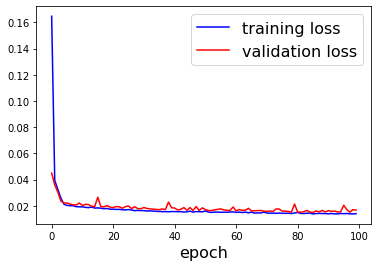

In [49]:
fig, ax = plt.subplots()
ax.plot(np.arange(0,len(loss_train_list)), loss_train_list, '-b', label='training loss')
ax.plot(np.arange(0,len(loss_val_list)), loss_val_list, '-r', label='validation loss')
ax.set_xlabel('epoch',fontsize=16)
ax.legend(fontsize=16)

In [50]:
# obtain Yp_test
# "Yp_test=model(X_test)"  may need lots of memory
# we can use a for loop to get Yp_test, see the function test
Yp_test=[]
with torch.no_grad(): # tell Pytorch not to build graph in the 'with' section
    for batch_idx, (X, Y) in enumerate(dataloader_test):
        X, Y = X.to(device), Y.to(device)
        Yp = model(X)#forward pass
        Yp_test.append(Yp.detach().cpu().numpy())
Yp_test=np.concatenate(Yp_test, axis=0).squeeze()

In [51]:
# compute MSE, MAE and MAPE on test set
print('Evaluate model on testing set')
MSE = np.mean((Y_test - Yp_test)**2)
MAE = np.mean(np.abs(Y_test - Yp_test))
MAPE =  np.mean(np.abs(Y_test - Yp_test)/Y_test)

print('Evaluate model on testing set')
print('MSE=', MSE)
print('MAE=', MAE)
print('MAPE=', MAPE)

Evaluate model on testing set
Evaluate model on testing set
MSE= 0.015315662
MAE= 0.082902744
MAPE= 0.21584035


Text(0, 0.5, 'Y_test_pred')

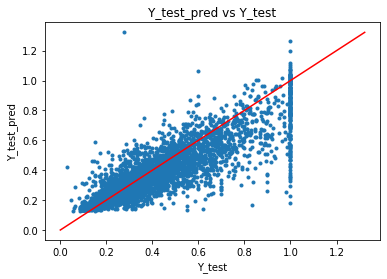

In [52]:
# plot Yp_test vs Y_test
# the red line is the 45-degree line
fig, ax = plt.subplots()
ax.set_title('Y_test_pred vs Y_test')
ax.plot(Y_test, Yp_test, '.')
ymax=np.max([Y_test.max(), Yp_test.max()])
ax.plot(np.linspace(0,ymax, 3), np.linspace(0, ymax, 3), '-r')
ax.set_xlabel('Y_test')
ax.set_ylabel('Y_test_pred')

### change the structure of the MLP model and see if it can do better than XGBoost

In [53]:
#define a new model -- add one more layers
#train, validate and test the model
#compare it with XGBoost in homework #3
import torch.nn as nn
import torch.nn.functional as nnF
class Net(nn.Module):
    def __init__(self, input_dim, output_dim, n_units):
        super().__init__()
        self.layer1 = nn.Linear(input_dim, n_units)
        self.layer2 = nn.Linear(n_units, n_units)
        self.layer2 = nn.Linear(n_units, n_units)
        self.layer3 = nn.Linear(n_units, output_dim)        
    def forward(self, x):
        x=self.layer1(x)
        x=nnF.softplus(x)
        x=self.layer2(x)
        x=nnF.softplus(x)
        y=self.layer3(x)
        return y

In [54]:
model=Net(input_dim=13, output_dim=1, n_units=128)
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [55]:
loss_train_list=[]
loss_val_list=[]
for epoch in range(0, 100):    
    #-------- perform training --------------------------------
    loss_train=train(model, optimizer, dataloader_train, device, epoch)    
    loss_train_list.append(loss_train)
    print('epoch', epoch, 'training loss:', loss_train)
    #-------- perform validation --------------------------------
    loss_val, mae_val = test(model, dataloader_val, device)
    loss_val_list.append(loss_val)
    print('epoch', epoch, 'validation loss:', loss_val)

Train Epoch: 0 [0/14860 (0%)]	Loss: 0.372046
Train Epoch: 0 [128/14860 (1%)]	Loss: 9.617439
Train Epoch: 0 [256/14860 (2%)]	Loss: 0.841071
Train Epoch: 0 [384/14860 (3%)]	Loss: 0.977372
Train Epoch: 0 [512/14860 (3%)]	Loss: 2.848872
Train Epoch: 0 [640/14860 (4%)]	Loss: 2.032702
Train Epoch: 0 [768/14860 (5%)]	Loss: 1.042211
Train Epoch: 0 [896/14860 (6%)]	Loss: 0.405977
Train Epoch: 0 [1024/14860 (7%)]	Loss: 0.146085
Train Epoch: 0 [1152/14860 (8%)]	Loss: 0.070779
Train Epoch: 0 [1280/14860 (9%)]	Loss: 0.051796
Train Epoch: 0 [1408/14860 (9%)]	Loss: 0.049683
Train Epoch: 0 [1536/14860 (10%)]	Loss: 0.053951
Train Epoch: 0 [1664/14860 (11%)]	Loss: 0.052657
Train Epoch: 0 [1792/14860 (12%)]	Loss: 0.047453
Train Epoch: 0 [1920/14860 (13%)]	Loss: 0.060173
Train Epoch: 0 [2048/14860 (14%)]	Loss: 0.061332
Train Epoch: 0 [2176/14860 (15%)]	Loss: 0.049008
Train Epoch: 0 [2304/14860 (15%)]	Loss: 0.063177
Train Epoch: 0 [2432/14860 (16%)]	Loss: 0.055389
Train Epoch: 0 [2560/14860 (17%)]	Loss: 0.

Train Epoch: 1 [6144/14860 (41%)]	Loss: 0.041007
Train Epoch: 1 [6272/14860 (42%)]	Loss: 0.035852
Train Epoch: 1 [6400/14860 (43%)]	Loss: 0.038344
Train Epoch: 1 [6528/14860 (44%)]	Loss: 0.035925
Train Epoch: 1 [6656/14860 (44%)]	Loss: 0.036970
Train Epoch: 1 [6784/14860 (45%)]	Loss: 0.038301
Train Epoch: 1 [6912/14860 (46%)]	Loss: 0.037195
Train Epoch: 1 [7040/14860 (47%)]	Loss: 0.033293
Train Epoch: 1 [7168/14860 (48%)]	Loss: 0.034260
Train Epoch: 1 [7296/14860 (49%)]	Loss: 0.042443
Train Epoch: 1 [7424/14860 (50%)]	Loss: 0.051735
Train Epoch: 1 [7552/14860 (50%)]	Loss: 0.036801
Train Epoch: 1 [7680/14860 (51%)]	Loss: 0.036451
Train Epoch: 1 [7808/14860 (52%)]	Loss: 0.043087
Train Epoch: 1 [7936/14860 (53%)]	Loss: 0.043902
Train Epoch: 1 [8064/14860 (54%)]	Loss: 0.039263
Train Epoch: 1 [8192/14860 (55%)]	Loss: 0.037815
Train Epoch: 1 [8320/14860 (56%)]	Loss: 0.041055
Train Epoch: 1 [8448/14860 (56%)]	Loss: 0.040120
Train Epoch: 1 [8576/14860 (57%)]	Loss: 0.040054
Train Epoch: 1 [8704

Train Epoch: 2 [12160/14860 (81%)]	Loss: 0.034992
Train Epoch: 2 [12288/14860 (82%)]	Loss: 0.034330
Train Epoch: 2 [12416/14860 (83%)]	Loss: 0.027150
Train Epoch: 2 [12544/14860 (84%)]	Loss: 0.038350
Train Epoch: 2 [12672/14860 (85%)]	Loss: 0.023825
Train Epoch: 2 [12800/14860 (85%)]	Loss: 0.037696
Train Epoch: 2 [12928/14860 (86%)]	Loss: 0.035216
Train Epoch: 2 [13056/14860 (87%)]	Loss: 0.033239
Train Epoch: 2 [13184/14860 (88%)]	Loss: 0.030458
Train Epoch: 2 [13312/14860 (89%)]	Loss: 0.035946
Train Epoch: 2 [13440/14860 (90%)]	Loss: 0.026969
Train Epoch: 2 [13568/14860 (91%)]	Loss: 0.031331
Train Epoch: 2 [13696/14860 (91%)]	Loss: 0.032918
Train Epoch: 2 [13824/14860 (92%)]	Loss: 0.032239
Train Epoch: 2 [13952/14860 (93%)]	Loss: 0.027196
Train Epoch: 2 [14080/14860 (94%)]	Loss: 0.032886
Train Epoch: 2 [14208/14860 (95%)]	Loss: 0.031973
Train Epoch: 2 [14336/14860 (96%)]	Loss: 0.033096
Train Epoch: 2 [14464/14860 (97%)]	Loss: 0.028422
Train Epoch: 2 [14592/14860 (97%)]	Loss: 0.032561


Train Epoch: 4 [3072/14860 (21%)]	Loss: 0.020748
Train Epoch: 4 [3200/14860 (21%)]	Loss: 0.021716
Train Epoch: 4 [3328/14860 (22%)]	Loss: 0.027040
Train Epoch: 4 [3456/14860 (23%)]	Loss: 0.023455
Train Epoch: 4 [3584/14860 (24%)]	Loss: 0.023291
Train Epoch: 4 [3712/14860 (25%)]	Loss: 0.025665
Train Epoch: 4 [3840/14860 (26%)]	Loss: 0.021711
Train Epoch: 4 [3968/14860 (26%)]	Loss: 0.030357
Train Epoch: 4 [4096/14860 (27%)]	Loss: 0.029465
Train Epoch: 4 [4224/14860 (28%)]	Loss: 0.024522
Train Epoch: 4 [4352/14860 (29%)]	Loss: 0.019993
Train Epoch: 4 [4480/14860 (30%)]	Loss: 0.027405
Train Epoch: 4 [4608/14860 (31%)]	Loss: 0.019958
Train Epoch: 4 [4736/14860 (32%)]	Loss: 0.023139
Train Epoch: 4 [4864/14860 (32%)]	Loss: 0.022610
Train Epoch: 4 [4992/14860 (33%)]	Loss: 0.028062
Train Epoch: 4 [5120/14860 (34%)]	Loss: 0.015568
Train Epoch: 4 [5248/14860 (35%)]	Loss: 0.025861
Train Epoch: 4 [5376/14860 (36%)]	Loss: 0.023628
Train Epoch: 4 [5504/14860 (37%)]	Loss: 0.026542
Train Epoch: 4 [5632

Train Epoch: 5 [9216/14860 (62%)]	Loss: 0.026069
Train Epoch: 5 [9344/14860 (62%)]	Loss: 0.016597
Train Epoch: 5 [9472/14860 (63%)]	Loss: 0.017574
Train Epoch: 5 [9600/14860 (64%)]	Loss: 0.024434
Train Epoch: 5 [9728/14860 (65%)]	Loss: 0.015388
Train Epoch: 5 [9856/14860 (66%)]	Loss: 0.017101
Train Epoch: 5 [9984/14860 (67%)]	Loss: 0.016433
Train Epoch: 5 [10112/14860 (68%)]	Loss: 0.024138
Train Epoch: 5 [10240/14860 (68%)]	Loss: 0.018903
Train Epoch: 5 [10368/14860 (69%)]	Loss: 0.017647
Train Epoch: 5 [10496/14860 (70%)]	Loss: 0.015051
Train Epoch: 5 [10624/14860 (71%)]	Loss: 0.013310
Train Epoch: 5 [10752/14860 (72%)]	Loss: 0.020406
Train Epoch: 5 [10880/14860 (73%)]	Loss: 0.019619
Train Epoch: 5 [11008/14860 (74%)]	Loss: 0.024889
Train Epoch: 5 [11136/14860 (74%)]	Loss: 0.030215
Train Epoch: 5 [11264/14860 (75%)]	Loss: 0.020686
Train Epoch: 5 [11392/14860 (76%)]	Loss: 0.023975
Train Epoch: 5 [11520/14860 (77%)]	Loss: 0.019339
Train Epoch: 5 [11648/14860 (78%)]	Loss: 0.022769
Train E

Train Epoch: 7 [0/14860 (0%)]	Loss: 0.017859
Train Epoch: 7 [128/14860 (1%)]	Loss: 0.013349
Train Epoch: 7 [256/14860 (2%)]	Loss: 0.013002
Train Epoch: 7 [384/14860 (3%)]	Loss: 0.020753
Train Epoch: 7 [512/14860 (3%)]	Loss: 0.025592
Train Epoch: 7 [640/14860 (4%)]	Loss: 0.017682
Train Epoch: 7 [768/14860 (5%)]	Loss: 0.015163
Train Epoch: 7 [896/14860 (6%)]	Loss: 0.018611
Train Epoch: 7 [1024/14860 (7%)]	Loss: 0.017842
Train Epoch: 7 [1152/14860 (8%)]	Loss: 0.011232
Train Epoch: 7 [1280/14860 (9%)]	Loss: 0.019911
Train Epoch: 7 [1408/14860 (9%)]	Loss: 0.026532
Train Epoch: 7 [1536/14860 (10%)]	Loss: 0.018565
Train Epoch: 7 [1664/14860 (11%)]	Loss: 0.018777
Train Epoch: 7 [1792/14860 (12%)]	Loss: 0.017055
Train Epoch: 7 [1920/14860 (13%)]	Loss: 0.030340
Train Epoch: 7 [2048/14860 (14%)]	Loss: 0.014973
Train Epoch: 7 [2176/14860 (15%)]	Loss: 0.022069
Train Epoch: 7 [2304/14860 (15%)]	Loss: 0.018721
Train Epoch: 7 [2432/14860 (16%)]	Loss: 0.019852
Train Epoch: 7 [2560/14860 (17%)]	Loss: 0.

Train Epoch: 8 [6144/14860 (41%)]	Loss: 0.023652
Train Epoch: 8 [6272/14860 (42%)]	Loss: 0.012271
Train Epoch: 8 [6400/14860 (43%)]	Loss: 0.021223
Train Epoch: 8 [6528/14860 (44%)]	Loss: 0.018362
Train Epoch: 8 [6656/14860 (44%)]	Loss: 0.021142
Train Epoch: 8 [6784/14860 (45%)]	Loss: 0.017591
Train Epoch: 8 [6912/14860 (46%)]	Loss: 0.022215
Train Epoch: 8 [7040/14860 (47%)]	Loss: 0.011410
Train Epoch: 8 [7168/14860 (48%)]	Loss: 0.018455
Train Epoch: 8 [7296/14860 (49%)]	Loss: 0.024147
Train Epoch: 8 [7424/14860 (50%)]	Loss: 0.025902
Train Epoch: 8 [7552/14860 (50%)]	Loss: 0.015861
Train Epoch: 8 [7680/14860 (51%)]	Loss: 0.020007
Train Epoch: 8 [7808/14860 (52%)]	Loss: 0.020971
Train Epoch: 8 [7936/14860 (53%)]	Loss: 0.017468
Train Epoch: 8 [8064/14860 (54%)]	Loss: 0.020047
Train Epoch: 8 [8192/14860 (55%)]	Loss: 0.026167
Train Epoch: 8 [8320/14860 (56%)]	Loss: 0.023175
Train Epoch: 8 [8448/14860 (56%)]	Loss: 0.014519
Train Epoch: 8 [8576/14860 (57%)]	Loss: 0.014583
Train Epoch: 8 [8704

Train Epoch: 9 [12160/14860 (81%)]	Loss: 0.014570
Train Epoch: 9 [12288/14860 (82%)]	Loss: 0.021378
Train Epoch: 9 [12416/14860 (83%)]	Loss: 0.016517
Train Epoch: 9 [12544/14860 (84%)]	Loss: 0.025438
Train Epoch: 9 [12672/14860 (85%)]	Loss: 0.016396
Train Epoch: 9 [12800/14860 (85%)]	Loss: 0.014966
Train Epoch: 9 [12928/14860 (86%)]	Loss: 0.013020
Train Epoch: 9 [13056/14860 (87%)]	Loss: 0.019005
Train Epoch: 9 [13184/14860 (88%)]	Loss: 0.011648
Train Epoch: 9 [13312/14860 (89%)]	Loss: 0.014478
Train Epoch: 9 [13440/14860 (90%)]	Loss: 0.018678
Train Epoch: 9 [13568/14860 (91%)]	Loss: 0.016693
Train Epoch: 9 [13696/14860 (91%)]	Loss: 0.020158
Train Epoch: 9 [13824/14860 (92%)]	Loss: 0.019670
Train Epoch: 9 [13952/14860 (93%)]	Loss: 0.017634
Train Epoch: 9 [14080/14860 (94%)]	Loss: 0.025363
Train Epoch: 9 [14208/14860 (95%)]	Loss: 0.015782
Train Epoch: 9 [14336/14860 (96%)]	Loss: 0.030055
Train Epoch: 9 [14464/14860 (97%)]	Loss: 0.014980
Train Epoch: 9 [14592/14860 (97%)]	Loss: 0.013711


Train Epoch: 11 [2688/14860 (18%)]	Loss: 0.018660
Train Epoch: 11 [2816/14860 (19%)]	Loss: 0.011087
Train Epoch: 11 [2944/14860 (20%)]	Loss: 0.015024
Train Epoch: 11 [3072/14860 (21%)]	Loss: 0.019525
Train Epoch: 11 [3200/14860 (21%)]	Loss: 0.022650
Train Epoch: 11 [3328/14860 (22%)]	Loss: 0.014092
Train Epoch: 11 [3456/14860 (23%)]	Loss: 0.017356
Train Epoch: 11 [3584/14860 (24%)]	Loss: 0.020526
Train Epoch: 11 [3712/14860 (25%)]	Loss: 0.015690
Train Epoch: 11 [3840/14860 (26%)]	Loss: 0.021134
Train Epoch: 11 [3968/14860 (26%)]	Loss: 0.016905
Train Epoch: 11 [4096/14860 (27%)]	Loss: 0.022110
Train Epoch: 11 [4224/14860 (28%)]	Loss: 0.015294
Train Epoch: 11 [4352/14860 (29%)]	Loss: 0.019859
Train Epoch: 11 [4480/14860 (30%)]	Loss: 0.018522
Train Epoch: 11 [4608/14860 (31%)]	Loss: 0.014746
Train Epoch: 11 [4736/14860 (32%)]	Loss: 0.019238
Train Epoch: 11 [4864/14860 (32%)]	Loss: 0.016462
Train Epoch: 11 [4992/14860 (33%)]	Loss: 0.034801
Train Epoch: 11 [5120/14860 (34%)]	Loss: 0.016933


Train Epoch: 12 [8320/14860 (56%)]	Loss: 0.021408
Train Epoch: 12 [8448/14860 (56%)]	Loss: 0.018238
Train Epoch: 12 [8576/14860 (57%)]	Loss: 0.022263
Train Epoch: 12 [8704/14860 (58%)]	Loss: 0.017748
Train Epoch: 12 [8832/14860 (59%)]	Loss: 0.012582
Train Epoch: 12 [8960/14860 (60%)]	Loss: 0.014445
Train Epoch: 12 [9088/14860 (61%)]	Loss: 0.017508
Train Epoch: 12 [9216/14860 (62%)]	Loss: 0.015294
Train Epoch: 12 [9344/14860 (62%)]	Loss: 0.023815
Train Epoch: 12 [9472/14860 (63%)]	Loss: 0.019221
Train Epoch: 12 [9600/14860 (64%)]	Loss: 0.014503
Train Epoch: 12 [9728/14860 (65%)]	Loss: 0.028371
Train Epoch: 12 [9856/14860 (66%)]	Loss: 0.014754
Train Epoch: 12 [9984/14860 (67%)]	Loss: 0.016855
Train Epoch: 12 [10112/14860 (68%)]	Loss: 0.022018
Train Epoch: 12 [10240/14860 (68%)]	Loss: 0.019372
Train Epoch: 12 [10368/14860 (69%)]	Loss: 0.020319
Train Epoch: 12 [10496/14860 (70%)]	Loss: 0.019366
Train Epoch: 12 [10624/14860 (71%)]	Loss: 0.015717
Train Epoch: 12 [10752/14860 (72%)]	Loss: 0.0

Train Epoch: 13 [13952/14860 (93%)]	Loss: 0.020005
Train Epoch: 13 [14080/14860 (94%)]	Loss: 0.024831
Train Epoch: 13 [14208/14860 (95%)]	Loss: 0.019671
Train Epoch: 13 [14336/14860 (96%)]	Loss: 0.019455
Train Epoch: 13 [14464/14860 (97%)]	Loss: 0.021805
Train Epoch: 13 [14592/14860 (97%)]	Loss: 0.011148
Train Epoch: 13 [14720/14860 (98%)]	Loss: 0.029228
Train Epoch: 13 [1392/14860 (99%)]	Loss: 0.011190
epoch 13 training loss: 0.018517201718611594
epoch 13 validation loss: 0.01967806266237402
Train Epoch: 14 [0/14860 (0%)]	Loss: 0.026035
Train Epoch: 14 [128/14860 (1%)]	Loss: 0.016648
Train Epoch: 14 [256/14860 (2%)]	Loss: 0.021012
Train Epoch: 14 [384/14860 (3%)]	Loss: 0.018388
Train Epoch: 14 [512/14860 (3%)]	Loss: 0.018374
Train Epoch: 14 [640/14860 (4%)]	Loss: 0.019706
Train Epoch: 14 [768/14860 (5%)]	Loss: 0.026695
Train Epoch: 14 [896/14860 (6%)]	Loss: 0.025150
Train Epoch: 14 [1024/14860 (7%)]	Loss: 0.023396
Train Epoch: 14 [1152/14860 (8%)]	Loss: 0.015354
Train Epoch: 14 [1280/

Train Epoch: 15 [4480/14860 (30%)]	Loss: 0.016910
Train Epoch: 15 [4608/14860 (31%)]	Loss: 0.015059
Train Epoch: 15 [4736/14860 (32%)]	Loss: 0.015752
Train Epoch: 15 [4864/14860 (32%)]	Loss: 0.017673
Train Epoch: 15 [4992/14860 (33%)]	Loss: 0.016654
Train Epoch: 15 [5120/14860 (34%)]	Loss: 0.018279
Train Epoch: 15 [5248/14860 (35%)]	Loss: 0.020309
Train Epoch: 15 [5376/14860 (36%)]	Loss: 0.016918
Train Epoch: 15 [5504/14860 (37%)]	Loss: 0.017325
Train Epoch: 15 [5632/14860 (38%)]	Loss: 0.017605
Train Epoch: 15 [5760/14860 (38%)]	Loss: 0.019811
Train Epoch: 15 [5888/14860 (39%)]	Loss: 0.021510
Train Epoch: 15 [6016/14860 (40%)]	Loss: 0.025317
Train Epoch: 15 [6144/14860 (41%)]	Loss: 0.012994
Train Epoch: 15 [6272/14860 (42%)]	Loss: 0.020194
Train Epoch: 15 [6400/14860 (43%)]	Loss: 0.015620
Train Epoch: 15 [6528/14860 (44%)]	Loss: 0.018169
Train Epoch: 15 [6656/14860 (44%)]	Loss: 0.018869
Train Epoch: 15 [6784/14860 (45%)]	Loss: 0.016280
Train Epoch: 15 [6912/14860 (46%)]	Loss: 0.027411


Train Epoch: 16 [10112/14860 (68%)]	Loss: 0.017411
Train Epoch: 16 [10240/14860 (68%)]	Loss: 0.014474
Train Epoch: 16 [10368/14860 (69%)]	Loss: 0.019299
Train Epoch: 16 [10496/14860 (70%)]	Loss: 0.020220
Train Epoch: 16 [10624/14860 (71%)]	Loss: 0.012121
Train Epoch: 16 [10752/14860 (72%)]	Loss: 0.020637
Train Epoch: 16 [10880/14860 (73%)]	Loss: 0.016748
Train Epoch: 16 [11008/14860 (74%)]	Loss: 0.012881
Train Epoch: 16 [11136/14860 (74%)]	Loss: 0.023689
Train Epoch: 16 [11264/14860 (75%)]	Loss: 0.017674
Train Epoch: 16 [11392/14860 (76%)]	Loss: 0.012969
Train Epoch: 16 [11520/14860 (77%)]	Loss: 0.017901
Train Epoch: 16 [11648/14860 (78%)]	Loss: 0.016342
Train Epoch: 16 [11776/14860 (79%)]	Loss: 0.017409
Train Epoch: 16 [11904/14860 (79%)]	Loss: 0.019275
Train Epoch: 16 [12032/14860 (80%)]	Loss: 0.018500
Train Epoch: 16 [12160/14860 (81%)]	Loss: 0.021931
Train Epoch: 16 [12288/14860 (82%)]	Loss: 0.023597
Train Epoch: 16 [12416/14860 (83%)]	Loss: 0.013678
Train Epoch: 16 [12544/14860 (8

Train Epoch: 18 [512/14860 (3%)]	Loss: 0.017087
Train Epoch: 18 [640/14860 (4%)]	Loss: 0.016161
Train Epoch: 18 [768/14860 (5%)]	Loss: 0.013944
Train Epoch: 18 [896/14860 (6%)]	Loss: 0.013714
Train Epoch: 18 [1024/14860 (7%)]	Loss: 0.018221
Train Epoch: 18 [1152/14860 (8%)]	Loss: 0.021075
Train Epoch: 18 [1280/14860 (9%)]	Loss: 0.017566
Train Epoch: 18 [1408/14860 (9%)]	Loss: 0.019364
Train Epoch: 18 [1536/14860 (10%)]	Loss: 0.023283
Train Epoch: 18 [1664/14860 (11%)]	Loss: 0.020029
Train Epoch: 18 [1792/14860 (12%)]	Loss: 0.010876
Train Epoch: 18 [1920/14860 (13%)]	Loss: 0.021511
Train Epoch: 18 [2048/14860 (14%)]	Loss: 0.017716
Train Epoch: 18 [2176/14860 (15%)]	Loss: 0.023000
Train Epoch: 18 [2304/14860 (15%)]	Loss: 0.011815
Train Epoch: 18 [2432/14860 (16%)]	Loss: 0.019565
Train Epoch: 18 [2560/14860 (17%)]	Loss: 0.014415
Train Epoch: 18 [2688/14860 (18%)]	Loss: 0.017270
Train Epoch: 18 [2816/14860 (19%)]	Loss: 0.015220
Train Epoch: 18 [2944/14860 (20%)]	Loss: 0.017835
Train Epoch:

Train Epoch: 19 [6272/14860 (42%)]	Loss: 0.016016
Train Epoch: 19 [6400/14860 (43%)]	Loss: 0.018710
Train Epoch: 19 [6528/14860 (44%)]	Loss: 0.010463
Train Epoch: 19 [6656/14860 (44%)]	Loss: 0.012301
Train Epoch: 19 [6784/14860 (45%)]	Loss: 0.016305
Train Epoch: 19 [6912/14860 (46%)]	Loss: 0.014330
Train Epoch: 19 [7040/14860 (47%)]	Loss: 0.014862
Train Epoch: 19 [7168/14860 (48%)]	Loss: 0.021548
Train Epoch: 19 [7296/14860 (49%)]	Loss: 0.015934
Train Epoch: 19 [7424/14860 (50%)]	Loss: 0.019365
Train Epoch: 19 [7552/14860 (50%)]	Loss: 0.017580
Train Epoch: 19 [7680/14860 (51%)]	Loss: 0.011675
Train Epoch: 19 [7808/14860 (52%)]	Loss: 0.021015
Train Epoch: 19 [7936/14860 (53%)]	Loss: 0.014745
Train Epoch: 19 [8064/14860 (54%)]	Loss: 0.013810
Train Epoch: 19 [8192/14860 (55%)]	Loss: 0.013442
Train Epoch: 19 [8320/14860 (56%)]	Loss: 0.016360
Train Epoch: 19 [8448/14860 (56%)]	Loss: 0.024370
Train Epoch: 19 [8576/14860 (57%)]	Loss: 0.017978
Train Epoch: 19 [8704/14860 (58%)]	Loss: 0.013113


Train Epoch: 20 [11904/14860 (79%)]	Loss: 0.014077
Train Epoch: 20 [12032/14860 (80%)]	Loss: 0.013677
Train Epoch: 20 [12160/14860 (81%)]	Loss: 0.020304
Train Epoch: 20 [12288/14860 (82%)]	Loss: 0.018710
Train Epoch: 20 [12416/14860 (83%)]	Loss: 0.017790
Train Epoch: 20 [12544/14860 (84%)]	Loss: 0.020056
Train Epoch: 20 [12672/14860 (85%)]	Loss: 0.017496
Train Epoch: 20 [12800/14860 (85%)]	Loss: 0.016640
Train Epoch: 20 [12928/14860 (86%)]	Loss: 0.018974
Train Epoch: 20 [13056/14860 (87%)]	Loss: 0.016317
Train Epoch: 20 [13184/14860 (88%)]	Loss: 0.029663
Train Epoch: 20 [13312/14860 (89%)]	Loss: 0.020043
Train Epoch: 20 [13440/14860 (90%)]	Loss: 0.021473
Train Epoch: 20 [13568/14860 (91%)]	Loss: 0.015536
Train Epoch: 20 [13696/14860 (91%)]	Loss: 0.014378
Train Epoch: 20 [13824/14860 (92%)]	Loss: 0.015689
Train Epoch: 20 [13952/14860 (93%)]	Loss: 0.020355
Train Epoch: 20 [14080/14860 (94%)]	Loss: 0.017029
Train Epoch: 20 [14208/14860 (95%)]	Loss: 0.013978
Train Epoch: 20 [14336/14860 (9

Train Epoch: 22 [2304/14860 (15%)]	Loss: 0.016960
Train Epoch: 22 [2432/14860 (16%)]	Loss: 0.019991
Train Epoch: 22 [2560/14860 (17%)]	Loss: 0.022001
Train Epoch: 22 [2688/14860 (18%)]	Loss: 0.016526
Train Epoch: 22 [2816/14860 (19%)]	Loss: 0.010304
Train Epoch: 22 [2944/14860 (20%)]	Loss: 0.018733
Train Epoch: 22 [3072/14860 (21%)]	Loss: 0.018640
Train Epoch: 22 [3200/14860 (21%)]	Loss: 0.015337
Train Epoch: 22 [3328/14860 (22%)]	Loss: 0.015401
Train Epoch: 22 [3456/14860 (23%)]	Loss: 0.017243
Train Epoch: 22 [3584/14860 (24%)]	Loss: 0.014655
Train Epoch: 22 [3712/14860 (25%)]	Loss: 0.013253
Train Epoch: 22 [3840/14860 (26%)]	Loss: 0.013553
Train Epoch: 22 [3968/14860 (26%)]	Loss: 0.014939
Train Epoch: 22 [4096/14860 (27%)]	Loss: 0.011364
Train Epoch: 22 [4224/14860 (28%)]	Loss: 0.013305
Train Epoch: 22 [4352/14860 (29%)]	Loss: 0.022178
Train Epoch: 22 [4480/14860 (30%)]	Loss: 0.018120
Train Epoch: 22 [4608/14860 (31%)]	Loss: 0.015606
Train Epoch: 22 [4736/14860 (32%)]	Loss: 0.013108


Train Epoch: 23 [7936/14860 (53%)]	Loss: 0.013867
Train Epoch: 23 [8064/14860 (54%)]	Loss: 0.019829
Train Epoch: 23 [8192/14860 (55%)]	Loss: 0.016824
Train Epoch: 23 [8320/14860 (56%)]	Loss: 0.015184
Train Epoch: 23 [8448/14860 (56%)]	Loss: 0.012784
Train Epoch: 23 [8576/14860 (57%)]	Loss: 0.017157
Train Epoch: 23 [8704/14860 (58%)]	Loss: 0.012061
Train Epoch: 23 [8832/14860 (59%)]	Loss: 0.017262
Train Epoch: 23 [8960/14860 (60%)]	Loss: 0.017304
Train Epoch: 23 [9088/14860 (61%)]	Loss: 0.022380
Train Epoch: 23 [9216/14860 (62%)]	Loss: 0.017913
Train Epoch: 23 [9344/14860 (62%)]	Loss: 0.020738
Train Epoch: 23 [9472/14860 (63%)]	Loss: 0.015471
Train Epoch: 23 [9600/14860 (64%)]	Loss: 0.012776
Train Epoch: 23 [9728/14860 (65%)]	Loss: 0.012298
Train Epoch: 23 [9856/14860 (66%)]	Loss: 0.011233
Train Epoch: 23 [9984/14860 (67%)]	Loss: 0.015266
Train Epoch: 23 [10112/14860 (68%)]	Loss: 0.015654
Train Epoch: 23 [10240/14860 (68%)]	Loss: 0.014198
Train Epoch: 23 [10368/14860 (69%)]	Loss: 0.0144

Train Epoch: 24 [13568/14860 (91%)]	Loss: 0.016966
Train Epoch: 24 [13696/14860 (91%)]	Loss: 0.014846
Train Epoch: 24 [13824/14860 (92%)]	Loss: 0.014164
Train Epoch: 24 [13952/14860 (93%)]	Loss: 0.016659
Train Epoch: 24 [14080/14860 (94%)]	Loss: 0.015834
Train Epoch: 24 [14208/14860 (95%)]	Loss: 0.019877
Train Epoch: 24 [14336/14860 (96%)]	Loss: 0.012869
Train Epoch: 24 [14464/14860 (97%)]	Loss: 0.016021
Train Epoch: 24 [14592/14860 (97%)]	Loss: 0.023013
Train Epoch: 24 [14720/14860 (98%)]	Loss: 0.018220
Train Epoch: 24 [1392/14860 (99%)]	Loss: 0.022479
epoch 24 training loss: 0.017159060646708194
epoch 24 validation loss: 0.019430098320035033
Train Epoch: 25 [0/14860 (0%)]	Loss: 0.020405
Train Epoch: 25 [128/14860 (1%)]	Loss: 0.023625
Train Epoch: 25 [256/14860 (2%)]	Loss: 0.019246
Train Epoch: 25 [384/14860 (3%)]	Loss: 0.020607
Train Epoch: 25 [512/14860 (3%)]	Loss: 0.013710
Train Epoch: 25 [640/14860 (4%)]	Loss: 0.016913
Train Epoch: 25 [768/14860 (5%)]	Loss: 0.016411
Train Epoch: 2

Train Epoch: 26 [4096/14860 (27%)]	Loss: 0.013408
Train Epoch: 26 [4224/14860 (28%)]	Loss: 0.022280
Train Epoch: 26 [4352/14860 (29%)]	Loss: 0.017158
Train Epoch: 26 [4480/14860 (30%)]	Loss: 0.011468
Train Epoch: 26 [4608/14860 (31%)]	Loss: 0.012748
Train Epoch: 26 [4736/14860 (32%)]	Loss: 0.014836
Train Epoch: 26 [4864/14860 (32%)]	Loss: 0.017321
Train Epoch: 26 [4992/14860 (33%)]	Loss: 0.020683
Train Epoch: 26 [5120/14860 (34%)]	Loss: 0.013939
Train Epoch: 26 [5248/14860 (35%)]	Loss: 0.011908
Train Epoch: 26 [5376/14860 (36%)]	Loss: 0.018602
Train Epoch: 26 [5504/14860 (37%)]	Loss: 0.011256
Train Epoch: 26 [5632/14860 (38%)]	Loss: 0.014493
Train Epoch: 26 [5760/14860 (38%)]	Loss: 0.012134
Train Epoch: 26 [5888/14860 (39%)]	Loss: 0.020597
Train Epoch: 26 [6016/14860 (40%)]	Loss: 0.019563
Train Epoch: 26 [6144/14860 (41%)]	Loss: 0.016970
Train Epoch: 26 [6272/14860 (42%)]	Loss: 0.017500
Train Epoch: 26 [6400/14860 (43%)]	Loss: 0.019301
Train Epoch: 26 [6528/14860 (44%)]	Loss: 0.021862


Train Epoch: 27 [9728/14860 (65%)]	Loss: 0.011828
Train Epoch: 27 [9856/14860 (66%)]	Loss: 0.020567
Train Epoch: 27 [9984/14860 (67%)]	Loss: 0.018781
Train Epoch: 27 [10112/14860 (68%)]	Loss: 0.023092
Train Epoch: 27 [10240/14860 (68%)]	Loss: 0.018415
Train Epoch: 27 [10368/14860 (69%)]	Loss: 0.011782
Train Epoch: 27 [10496/14860 (70%)]	Loss: 0.015238
Train Epoch: 27 [10624/14860 (71%)]	Loss: 0.015968
Train Epoch: 27 [10752/14860 (72%)]	Loss: 0.019922
Train Epoch: 27 [10880/14860 (73%)]	Loss: 0.015938
Train Epoch: 27 [11008/14860 (74%)]	Loss: 0.018143
Train Epoch: 27 [11136/14860 (74%)]	Loss: 0.017275
Train Epoch: 27 [11264/14860 (75%)]	Loss: 0.016787
Train Epoch: 27 [11392/14860 (76%)]	Loss: 0.022830
Train Epoch: 27 [11520/14860 (77%)]	Loss: 0.015274
Train Epoch: 27 [11648/14860 (78%)]	Loss: 0.014877
Train Epoch: 27 [11776/14860 (79%)]	Loss: 0.014966
Train Epoch: 27 [11904/14860 (79%)]	Loss: 0.025159
Train Epoch: 27 [12032/14860 (80%)]	Loss: 0.016115
Train Epoch: 27 [12160/14860 (81%)

Train Epoch: 29 [128/14860 (1%)]	Loss: 0.013531
Train Epoch: 29 [256/14860 (2%)]	Loss: 0.016802
Train Epoch: 29 [384/14860 (3%)]	Loss: 0.018522
Train Epoch: 29 [512/14860 (3%)]	Loss: 0.015130
Train Epoch: 29 [640/14860 (4%)]	Loss: 0.019095
Train Epoch: 29 [768/14860 (5%)]	Loss: 0.016712
Train Epoch: 29 [896/14860 (6%)]	Loss: 0.014293
Train Epoch: 29 [1024/14860 (7%)]	Loss: 0.018527
Train Epoch: 29 [1152/14860 (8%)]	Loss: 0.013554
Train Epoch: 29 [1280/14860 (9%)]	Loss: 0.014279
Train Epoch: 29 [1408/14860 (9%)]	Loss: 0.016696
Train Epoch: 29 [1536/14860 (10%)]	Loss: 0.018022
Train Epoch: 29 [1664/14860 (11%)]	Loss: 0.017674
Train Epoch: 29 [1792/14860 (12%)]	Loss: 0.021521
Train Epoch: 29 [1920/14860 (13%)]	Loss: 0.018081
Train Epoch: 29 [2048/14860 (14%)]	Loss: 0.017984
Train Epoch: 29 [2176/14860 (15%)]	Loss: 0.011689
Train Epoch: 29 [2304/14860 (15%)]	Loss: 0.018220
Train Epoch: 29 [2432/14860 (16%)]	Loss: 0.015532
Train Epoch: 29 [2560/14860 (17%)]	Loss: 0.020043
Train Epoch: 29 [2

Train Epoch: 30 [5888/14860 (39%)]	Loss: 0.015790
Train Epoch: 30 [6016/14860 (40%)]	Loss: 0.018955
Train Epoch: 30 [6144/14860 (41%)]	Loss: 0.016033
Train Epoch: 30 [6272/14860 (42%)]	Loss: 0.015974
Train Epoch: 30 [6400/14860 (43%)]	Loss: 0.015350
Train Epoch: 30 [6528/14860 (44%)]	Loss: 0.010047
Train Epoch: 30 [6656/14860 (44%)]	Loss: 0.011693
Train Epoch: 30 [6784/14860 (45%)]	Loss: 0.019636
Train Epoch: 30 [6912/14860 (46%)]	Loss: 0.018094
Train Epoch: 30 [7040/14860 (47%)]	Loss: 0.016058
Train Epoch: 30 [7168/14860 (48%)]	Loss: 0.018329
Train Epoch: 30 [7296/14860 (49%)]	Loss: 0.014724
Train Epoch: 30 [7424/14860 (50%)]	Loss: 0.015181
Train Epoch: 30 [7552/14860 (50%)]	Loss: 0.021608
Train Epoch: 30 [7680/14860 (51%)]	Loss: 0.024272
Train Epoch: 30 [7808/14860 (52%)]	Loss: 0.011105
Train Epoch: 30 [7936/14860 (53%)]	Loss: 0.012205
Train Epoch: 30 [8064/14860 (54%)]	Loss: 0.010934
Train Epoch: 30 [8192/14860 (55%)]	Loss: 0.018059
Train Epoch: 30 [8320/14860 (56%)]	Loss: 0.020267


Train Epoch: 31 [11520/14860 (77%)]	Loss: 0.021095
Train Epoch: 31 [11648/14860 (78%)]	Loss: 0.013897
Train Epoch: 31 [11776/14860 (79%)]	Loss: 0.013150
Train Epoch: 31 [11904/14860 (79%)]	Loss: 0.014092
Train Epoch: 31 [12032/14860 (80%)]	Loss: 0.011130
Train Epoch: 31 [12160/14860 (81%)]	Loss: 0.015118
Train Epoch: 31 [12288/14860 (82%)]	Loss: 0.015644
Train Epoch: 31 [12416/14860 (83%)]	Loss: 0.019393
Train Epoch: 31 [12544/14860 (84%)]	Loss: 0.017112
Train Epoch: 31 [12672/14860 (85%)]	Loss: 0.022141
Train Epoch: 31 [12800/14860 (85%)]	Loss: 0.022110
Train Epoch: 31 [12928/14860 (86%)]	Loss: 0.009862
Train Epoch: 31 [13056/14860 (87%)]	Loss: 0.016737
Train Epoch: 31 [13184/14860 (88%)]	Loss: 0.017528
Train Epoch: 31 [13312/14860 (89%)]	Loss: 0.011797
Train Epoch: 31 [13440/14860 (90%)]	Loss: 0.013885
Train Epoch: 31 [13568/14860 (91%)]	Loss: 0.013889
Train Epoch: 31 [13696/14860 (91%)]	Loss: 0.018204
Train Epoch: 31 [13824/14860 (92%)]	Loss: 0.013870
Train Epoch: 31 [13952/14860 (9

Train Epoch: 33 [1920/14860 (13%)]	Loss: 0.015506
Train Epoch: 33 [2048/14860 (14%)]	Loss: 0.021836
Train Epoch: 33 [2176/14860 (15%)]	Loss: 0.021229
Train Epoch: 33 [2304/14860 (15%)]	Loss: 0.010176
Train Epoch: 33 [2432/14860 (16%)]	Loss: 0.013670
Train Epoch: 33 [2560/14860 (17%)]	Loss: 0.016770
Train Epoch: 33 [2688/14860 (18%)]	Loss: 0.016638
Train Epoch: 33 [2816/14860 (19%)]	Loss: 0.013097
Train Epoch: 33 [2944/14860 (20%)]	Loss: 0.020045
Train Epoch: 33 [3072/14860 (21%)]	Loss: 0.014117
Train Epoch: 33 [3200/14860 (21%)]	Loss: 0.021337
Train Epoch: 33 [3328/14860 (22%)]	Loss: 0.015956
Train Epoch: 33 [3456/14860 (23%)]	Loss: 0.016271
Train Epoch: 33 [3584/14860 (24%)]	Loss: 0.022641
Train Epoch: 33 [3712/14860 (25%)]	Loss: 0.015314
Train Epoch: 33 [3840/14860 (26%)]	Loss: 0.019304
Train Epoch: 33 [3968/14860 (26%)]	Loss: 0.022261
Train Epoch: 33 [4096/14860 (27%)]	Loss: 0.019033
Train Epoch: 33 [4224/14860 (28%)]	Loss: 0.021468
Train Epoch: 33 [4352/14860 (29%)]	Loss: 0.019711


Train Epoch: 34 [7552/14860 (50%)]	Loss: 0.018006
Train Epoch: 34 [7680/14860 (51%)]	Loss: 0.014360
Train Epoch: 34 [7808/14860 (52%)]	Loss: 0.018184
Train Epoch: 34 [7936/14860 (53%)]	Loss: 0.021660
Train Epoch: 34 [8064/14860 (54%)]	Loss: 0.014618
Train Epoch: 34 [8192/14860 (55%)]	Loss: 0.014481
Train Epoch: 34 [8320/14860 (56%)]	Loss: 0.013703
Train Epoch: 34 [8448/14860 (56%)]	Loss: 0.013778
Train Epoch: 34 [8576/14860 (57%)]	Loss: 0.014663
Train Epoch: 34 [8704/14860 (58%)]	Loss: 0.018144
Train Epoch: 34 [8832/14860 (59%)]	Loss: 0.022372
Train Epoch: 34 [8960/14860 (60%)]	Loss: 0.014262
Train Epoch: 34 [9088/14860 (61%)]	Loss: 0.013329
Train Epoch: 34 [9216/14860 (62%)]	Loss: 0.017254
Train Epoch: 34 [9344/14860 (62%)]	Loss: 0.012366
Train Epoch: 34 [9472/14860 (63%)]	Loss: 0.016859
Train Epoch: 34 [9600/14860 (64%)]	Loss: 0.013303
Train Epoch: 34 [9728/14860 (65%)]	Loss: 0.014223
Train Epoch: 34 [9856/14860 (66%)]	Loss: 0.013291
Train Epoch: 34 [9984/14860 (67%)]	Loss: 0.018382


Train Epoch: 35 [13184/14860 (88%)]	Loss: 0.012158
Train Epoch: 35 [13312/14860 (89%)]	Loss: 0.012489
Train Epoch: 35 [13440/14860 (90%)]	Loss: 0.015479
Train Epoch: 35 [13568/14860 (91%)]	Loss: 0.015520
Train Epoch: 35 [13696/14860 (91%)]	Loss: 0.016566
Train Epoch: 35 [13824/14860 (92%)]	Loss: 0.025976
Train Epoch: 35 [13952/14860 (93%)]	Loss: 0.012041
Train Epoch: 35 [14080/14860 (94%)]	Loss: 0.024902
Train Epoch: 35 [14208/14860 (95%)]	Loss: 0.021017
Train Epoch: 35 [14336/14860 (96%)]	Loss: 0.014478
Train Epoch: 35 [14464/14860 (97%)]	Loss: 0.017734
Train Epoch: 35 [14592/14860 (97%)]	Loss: 0.018237
Train Epoch: 35 [14720/14860 (98%)]	Loss: 0.020387
Train Epoch: 35 [1392/14860 (99%)]	Loss: 0.016110
epoch 35 training loss: 0.016134490235111654
epoch 35 validation loss: 0.017197156500874073
Train Epoch: 36 [0/14860 (0%)]	Loss: 0.014974
Train Epoch: 36 [128/14860 (1%)]	Loss: 0.015557
Train Epoch: 36 [256/14860 (2%)]	Loss: 0.019099
Train Epoch: 36 [384/14860 (3%)]	Loss: 0.014843
Train

Train Epoch: 37 [3712/14860 (25%)]	Loss: 0.016139
Train Epoch: 37 [3840/14860 (26%)]	Loss: 0.014906
Train Epoch: 37 [3968/14860 (26%)]	Loss: 0.014615
Train Epoch: 37 [4096/14860 (27%)]	Loss: 0.012671
Train Epoch: 37 [4224/14860 (28%)]	Loss: 0.011376
Train Epoch: 37 [4352/14860 (29%)]	Loss: 0.018961
Train Epoch: 37 [4480/14860 (30%)]	Loss: 0.020741
Train Epoch: 37 [4608/14860 (31%)]	Loss: 0.012314
Train Epoch: 37 [4736/14860 (32%)]	Loss: 0.014342
Train Epoch: 37 [4864/14860 (32%)]	Loss: 0.018407
Train Epoch: 37 [4992/14860 (33%)]	Loss: 0.013723
Train Epoch: 37 [5120/14860 (34%)]	Loss: 0.012551
Train Epoch: 37 [5248/14860 (35%)]	Loss: 0.012594
Train Epoch: 37 [5376/14860 (36%)]	Loss: 0.025018
Train Epoch: 37 [5504/14860 (37%)]	Loss: 0.018532
Train Epoch: 37 [5632/14860 (38%)]	Loss: 0.016762
Train Epoch: 37 [5760/14860 (38%)]	Loss: 0.017005
Train Epoch: 37 [5888/14860 (39%)]	Loss: 0.012326
Train Epoch: 37 [6016/14860 (40%)]	Loss: 0.019845
Train Epoch: 37 [6144/14860 (41%)]	Loss: 0.019356


Train Epoch: 38 [9344/14860 (62%)]	Loss: 0.011628
Train Epoch: 38 [9472/14860 (63%)]	Loss: 0.014507
Train Epoch: 38 [9600/14860 (64%)]	Loss: 0.018289
Train Epoch: 38 [9728/14860 (65%)]	Loss: 0.016050
Train Epoch: 38 [9856/14860 (66%)]	Loss: 0.011540
Train Epoch: 38 [9984/14860 (67%)]	Loss: 0.018033
Train Epoch: 38 [10112/14860 (68%)]	Loss: 0.010976
Train Epoch: 38 [10240/14860 (68%)]	Loss: 0.015000
Train Epoch: 38 [10368/14860 (69%)]	Loss: 0.016581
Train Epoch: 38 [10496/14860 (70%)]	Loss: 0.021750
Train Epoch: 38 [10624/14860 (71%)]	Loss: 0.015657
Train Epoch: 38 [10752/14860 (72%)]	Loss: 0.013507
Train Epoch: 38 [10880/14860 (73%)]	Loss: 0.014420
Train Epoch: 38 [11008/14860 (74%)]	Loss: 0.012648
Train Epoch: 38 [11136/14860 (74%)]	Loss: 0.014730
Train Epoch: 38 [11264/14860 (75%)]	Loss: 0.012071
Train Epoch: 38 [11392/14860 (76%)]	Loss: 0.022153
Train Epoch: 38 [11520/14860 (77%)]	Loss: 0.014026
Train Epoch: 38 [11648/14860 (78%)]	Loss: 0.017497
Train Epoch: 38 [11776/14860 (79%)]	L

Train Epoch: 39 [1392/14860 (99%)]	Loss: 0.032317
epoch 39 training loss: 0.015859094464307666
epoch 39 validation loss: 0.01766284297222664
Train Epoch: 40 [0/14860 (0%)]	Loss: 0.011233
Train Epoch: 40 [128/14860 (1%)]	Loss: 0.020154
Train Epoch: 40 [256/14860 (2%)]	Loss: 0.024112
Train Epoch: 40 [384/14860 (3%)]	Loss: 0.016869
Train Epoch: 40 [512/14860 (3%)]	Loss: 0.014471
Train Epoch: 40 [640/14860 (4%)]	Loss: 0.017995
Train Epoch: 40 [768/14860 (5%)]	Loss: 0.018716
Train Epoch: 40 [896/14860 (6%)]	Loss: 0.022303
Train Epoch: 40 [1024/14860 (7%)]	Loss: 0.017483
Train Epoch: 40 [1152/14860 (8%)]	Loss: 0.015055
Train Epoch: 40 [1280/14860 (9%)]	Loss: 0.015230
Train Epoch: 40 [1408/14860 (9%)]	Loss: 0.016099
Train Epoch: 40 [1536/14860 (10%)]	Loss: 0.016672
Train Epoch: 40 [1664/14860 (11%)]	Loss: 0.017556
Train Epoch: 40 [1792/14860 (12%)]	Loss: 0.022029
Train Epoch: 40 [1920/14860 (13%)]	Loss: 0.021261
Train Epoch: 40 [2048/14860 (14%)]	Loss: 0.011040
Train Epoch: 40 [2176/14860 (15

Train Epoch: 41 [5376/14860 (36%)]	Loss: 0.017086
Train Epoch: 41 [5504/14860 (37%)]	Loss: 0.012678
Train Epoch: 41 [5632/14860 (38%)]	Loss: 0.013811
Train Epoch: 41 [5760/14860 (38%)]	Loss: 0.014654
Train Epoch: 41 [5888/14860 (39%)]	Loss: 0.022914
Train Epoch: 41 [6016/14860 (40%)]	Loss: 0.013258
Train Epoch: 41 [6144/14860 (41%)]	Loss: 0.012469
Train Epoch: 41 [6272/14860 (42%)]	Loss: 0.017526
Train Epoch: 41 [6400/14860 (43%)]	Loss: 0.012421
Train Epoch: 41 [6528/14860 (44%)]	Loss: 0.021932
Train Epoch: 41 [6656/14860 (44%)]	Loss: 0.011623
Train Epoch: 41 [6784/14860 (45%)]	Loss: 0.011943
Train Epoch: 41 [6912/14860 (46%)]	Loss: 0.011360
Train Epoch: 41 [7040/14860 (47%)]	Loss: 0.019555
Train Epoch: 41 [7168/14860 (48%)]	Loss: 0.013306
Train Epoch: 41 [7296/14860 (49%)]	Loss: 0.022753
Train Epoch: 41 [7424/14860 (50%)]	Loss: 0.011380
Train Epoch: 41 [7552/14860 (50%)]	Loss: 0.024404
Train Epoch: 41 [7680/14860 (51%)]	Loss: 0.015424
Train Epoch: 41 [7808/14860 (52%)]	Loss: 0.013364


Train Epoch: 42 [11008/14860 (74%)]	Loss: 0.014119
Train Epoch: 42 [11136/14860 (74%)]	Loss: 0.013817
Train Epoch: 42 [11264/14860 (75%)]	Loss: 0.016097
Train Epoch: 42 [11392/14860 (76%)]	Loss: 0.025450
Train Epoch: 42 [11520/14860 (77%)]	Loss: 0.015605
Train Epoch: 42 [11648/14860 (78%)]	Loss: 0.014669
Train Epoch: 42 [11776/14860 (79%)]	Loss: 0.013281
Train Epoch: 42 [11904/14860 (79%)]	Loss: 0.013963
Train Epoch: 42 [12032/14860 (80%)]	Loss: 0.015037
Train Epoch: 42 [12160/14860 (81%)]	Loss: 0.020484
Train Epoch: 42 [12288/14860 (82%)]	Loss: 0.018572
Train Epoch: 42 [12416/14860 (83%)]	Loss: 0.022087
Train Epoch: 42 [12544/14860 (84%)]	Loss: 0.021574
Train Epoch: 42 [12672/14860 (85%)]	Loss: 0.015708
Train Epoch: 42 [12800/14860 (85%)]	Loss: 0.014814
Train Epoch: 42 [12928/14860 (86%)]	Loss: 0.015913
Train Epoch: 42 [13056/14860 (87%)]	Loss: 0.012873
Train Epoch: 42 [13184/14860 (88%)]	Loss: 0.010876
Train Epoch: 42 [13312/14860 (89%)]	Loss: 0.012243
Train Epoch: 42 [13440/14860 (9

Train Epoch: 44 [1408/14860 (9%)]	Loss: 0.014360
Train Epoch: 44 [1536/14860 (10%)]	Loss: 0.015111
Train Epoch: 44 [1664/14860 (11%)]	Loss: 0.010682
Train Epoch: 44 [1792/14860 (12%)]	Loss: 0.013813
Train Epoch: 44 [1920/14860 (13%)]	Loss: 0.013364
Train Epoch: 44 [2048/14860 (14%)]	Loss: 0.012462
Train Epoch: 44 [2176/14860 (15%)]	Loss: 0.017239
Train Epoch: 44 [2304/14860 (15%)]	Loss: 0.012278
Train Epoch: 44 [2432/14860 (16%)]	Loss: 0.014242
Train Epoch: 44 [2560/14860 (17%)]	Loss: 0.021246
Train Epoch: 44 [2688/14860 (18%)]	Loss: 0.008896
Train Epoch: 44 [2816/14860 (19%)]	Loss: 0.013002
Train Epoch: 44 [2944/14860 (20%)]	Loss: 0.008314
Train Epoch: 44 [3072/14860 (21%)]	Loss: 0.015414
Train Epoch: 44 [3200/14860 (21%)]	Loss: 0.009806
Train Epoch: 44 [3328/14860 (22%)]	Loss: 0.018734
Train Epoch: 44 [3456/14860 (23%)]	Loss: 0.020064
Train Epoch: 44 [3584/14860 (24%)]	Loss: 0.012255
Train Epoch: 44 [3712/14860 (25%)]	Loss: 0.018897
Train Epoch: 44 [3840/14860 (26%)]	Loss: 0.013110
T

Train Epoch: 45 [7040/14860 (47%)]	Loss: 0.013561
Train Epoch: 45 [7168/14860 (48%)]	Loss: 0.021142
Train Epoch: 45 [7296/14860 (49%)]	Loss: 0.022418
Train Epoch: 45 [7424/14860 (50%)]	Loss: 0.016722
Train Epoch: 45 [7552/14860 (50%)]	Loss: 0.011278
Train Epoch: 45 [7680/14860 (51%)]	Loss: 0.020349
Train Epoch: 45 [7808/14860 (52%)]	Loss: 0.025879
Train Epoch: 45 [7936/14860 (53%)]	Loss: 0.017402
Train Epoch: 45 [8064/14860 (54%)]	Loss: 0.014889
Train Epoch: 45 [8192/14860 (55%)]	Loss: 0.010550
Train Epoch: 45 [8320/14860 (56%)]	Loss: 0.020880
Train Epoch: 45 [8448/14860 (56%)]	Loss: 0.017815
Train Epoch: 45 [8576/14860 (57%)]	Loss: 0.012931
Train Epoch: 45 [8704/14860 (58%)]	Loss: 0.013604
Train Epoch: 45 [8832/14860 (59%)]	Loss: 0.011455
Train Epoch: 45 [8960/14860 (60%)]	Loss: 0.012487
Train Epoch: 45 [9088/14860 (61%)]	Loss: 0.024829
Train Epoch: 45 [9216/14860 (62%)]	Loss: 0.012134
Train Epoch: 45 [9344/14860 (62%)]	Loss: 0.018186
Train Epoch: 45 [9472/14860 (63%)]	Loss: 0.014536


Train Epoch: 46 [12672/14860 (85%)]	Loss: 0.015036
Train Epoch: 46 [12800/14860 (85%)]	Loss: 0.017306
Train Epoch: 46 [12928/14860 (86%)]	Loss: 0.011985
Train Epoch: 46 [13056/14860 (87%)]	Loss: 0.011477
Train Epoch: 46 [13184/14860 (88%)]	Loss: 0.017091
Train Epoch: 46 [13312/14860 (89%)]	Loss: 0.013706
Train Epoch: 46 [13440/14860 (90%)]	Loss: 0.009583
Train Epoch: 46 [13568/14860 (91%)]	Loss: 0.011881
Train Epoch: 46 [13696/14860 (91%)]	Loss: 0.021406
Train Epoch: 46 [13824/14860 (92%)]	Loss: 0.015406
Train Epoch: 46 [13952/14860 (93%)]	Loss: 0.019432
Train Epoch: 46 [14080/14860 (94%)]	Loss: 0.014700
Train Epoch: 46 [14208/14860 (95%)]	Loss: 0.017023
Train Epoch: 46 [14336/14860 (96%)]	Loss: 0.015047
Train Epoch: 46 [14464/14860 (97%)]	Loss: 0.019801
Train Epoch: 46 [14592/14860 (97%)]	Loss: 0.009620
Train Epoch: 46 [14720/14860 (98%)]	Loss: 0.020504
Train Epoch: 46 [1392/14860 (99%)]	Loss: 0.007506
epoch 46 training loss: 0.015436126500304438
epoch 46 validation loss: 0.0187306498

Train Epoch: 48 [3200/14860 (21%)]	Loss: 0.016093
Train Epoch: 48 [3328/14860 (22%)]	Loss: 0.012833
Train Epoch: 48 [3456/14860 (23%)]	Loss: 0.012998
Train Epoch: 48 [3584/14860 (24%)]	Loss: 0.015455
Train Epoch: 48 [3712/14860 (25%)]	Loss: 0.018420
Train Epoch: 48 [3840/14860 (26%)]	Loss: 0.018814
Train Epoch: 48 [3968/14860 (26%)]	Loss: 0.017818
Train Epoch: 48 [4096/14860 (27%)]	Loss: 0.011095
Train Epoch: 48 [4224/14860 (28%)]	Loss: 0.012123
Train Epoch: 48 [4352/14860 (29%)]	Loss: 0.010976
Train Epoch: 48 [4480/14860 (30%)]	Loss: 0.021454
Train Epoch: 48 [4608/14860 (31%)]	Loss: 0.011804
Train Epoch: 48 [4736/14860 (32%)]	Loss: 0.012115
Train Epoch: 48 [4864/14860 (32%)]	Loss: 0.023361
Train Epoch: 48 [4992/14860 (33%)]	Loss: 0.009821
Train Epoch: 48 [5120/14860 (34%)]	Loss: 0.015208
Train Epoch: 48 [5248/14860 (35%)]	Loss: 0.011719
Train Epoch: 48 [5376/14860 (36%)]	Loss: 0.012038
Train Epoch: 48 [5504/14860 (37%)]	Loss: 0.014529
Train Epoch: 48 [5632/14860 (38%)]	Loss: 0.013836


Train Epoch: 49 [8832/14860 (59%)]	Loss: 0.015555
Train Epoch: 49 [8960/14860 (60%)]	Loss: 0.019940
Train Epoch: 49 [9088/14860 (61%)]	Loss: 0.009012
Train Epoch: 49 [9216/14860 (62%)]	Loss: 0.011717
Train Epoch: 49 [9344/14860 (62%)]	Loss: 0.016369
Train Epoch: 49 [9472/14860 (63%)]	Loss: 0.013608
Train Epoch: 49 [9600/14860 (64%)]	Loss: 0.008861
Train Epoch: 49 [9728/14860 (65%)]	Loss: 0.012559
Train Epoch: 49 [9856/14860 (66%)]	Loss: 0.013395
Train Epoch: 49 [9984/14860 (67%)]	Loss: 0.015146
Train Epoch: 49 [10112/14860 (68%)]	Loss: 0.010633
Train Epoch: 49 [10240/14860 (68%)]	Loss: 0.011072
Train Epoch: 49 [10368/14860 (69%)]	Loss: 0.013504
Train Epoch: 49 [10496/14860 (70%)]	Loss: 0.010294
Train Epoch: 49 [10624/14860 (71%)]	Loss: 0.014285
Train Epoch: 49 [10752/14860 (72%)]	Loss: 0.013615
Train Epoch: 49 [10880/14860 (73%)]	Loss: 0.013331
Train Epoch: 49 [11008/14860 (74%)]	Loss: 0.016151
Train Epoch: 49 [11136/14860 (74%)]	Loss: 0.011520
Train Epoch: 49 [11264/14860 (75%)]	Loss:

Train Epoch: 50 [14464/14860 (97%)]	Loss: 0.017441
Train Epoch: 50 [14592/14860 (97%)]	Loss: 0.011004
Train Epoch: 50 [14720/14860 (98%)]	Loss: 0.020211
Train Epoch: 50 [1392/14860 (99%)]	Loss: 0.012871
epoch 50 training loss: 0.015249927305321917
epoch 50 validation loss: 0.01666464239864026
Train Epoch: 51 [0/14860 (0%)]	Loss: 0.013476
Train Epoch: 51 [128/14860 (1%)]	Loss: 0.013644
Train Epoch: 51 [256/14860 (2%)]	Loss: 0.014197
Train Epoch: 51 [384/14860 (3%)]	Loss: 0.017396
Train Epoch: 51 [512/14860 (3%)]	Loss: 0.012665
Train Epoch: 51 [640/14860 (4%)]	Loss: 0.015202
Train Epoch: 51 [768/14860 (5%)]	Loss: 0.022916
Train Epoch: 51 [896/14860 (6%)]	Loss: 0.012605
Train Epoch: 51 [1024/14860 (7%)]	Loss: 0.013459
Train Epoch: 51 [1152/14860 (8%)]	Loss: 0.017711
Train Epoch: 51 [1280/14860 (9%)]	Loss: 0.017145
Train Epoch: 51 [1408/14860 (9%)]	Loss: 0.012230
Train Epoch: 51 [1536/14860 (10%)]	Loss: 0.010781
Train Epoch: 51 [1664/14860 (11%)]	Loss: 0.012801
Train Epoch: 51 [1792/14860 

Train Epoch: 52 [4992/14860 (33%)]	Loss: 0.014461
Train Epoch: 52 [5120/14860 (34%)]	Loss: 0.017540
Train Epoch: 52 [5248/14860 (35%)]	Loss: 0.010577
Train Epoch: 52 [5376/14860 (36%)]	Loss: 0.009731
Train Epoch: 52 [5504/14860 (37%)]	Loss: 0.014873
Train Epoch: 52 [5632/14860 (38%)]	Loss: 0.011921
Train Epoch: 52 [5760/14860 (38%)]	Loss: 0.011512
Train Epoch: 52 [5888/14860 (39%)]	Loss: 0.012091
Train Epoch: 52 [6016/14860 (40%)]	Loss: 0.012669
Train Epoch: 52 [6144/14860 (41%)]	Loss: 0.014830
Train Epoch: 52 [6272/14860 (42%)]	Loss: 0.008354
Train Epoch: 52 [6400/14860 (43%)]	Loss: 0.012020
Train Epoch: 52 [6528/14860 (44%)]	Loss: 0.016587
Train Epoch: 52 [6656/14860 (44%)]	Loss: 0.015387
Train Epoch: 52 [6784/14860 (45%)]	Loss: 0.018753
Train Epoch: 52 [6912/14860 (46%)]	Loss: 0.015967
Train Epoch: 52 [7040/14860 (47%)]	Loss: 0.012595
Train Epoch: 52 [7168/14860 (48%)]	Loss: 0.013188
Train Epoch: 52 [7296/14860 (49%)]	Loss: 0.010778
Train Epoch: 52 [7424/14860 (50%)]	Loss: 0.016698


Train Epoch: 53 [10624/14860 (71%)]	Loss: 0.019885
Train Epoch: 53 [10752/14860 (72%)]	Loss: 0.013018
Train Epoch: 53 [10880/14860 (73%)]	Loss: 0.015247
Train Epoch: 53 [11008/14860 (74%)]	Loss: 0.014659
Train Epoch: 53 [11136/14860 (74%)]	Loss: 0.019515
Train Epoch: 53 [11264/14860 (75%)]	Loss: 0.017683
Train Epoch: 53 [11392/14860 (76%)]	Loss: 0.013053
Train Epoch: 53 [11520/14860 (77%)]	Loss: 0.016112
Train Epoch: 53 [11648/14860 (78%)]	Loss: 0.017978
Train Epoch: 53 [11776/14860 (79%)]	Loss: 0.013680
Train Epoch: 53 [11904/14860 (79%)]	Loss: 0.012015
Train Epoch: 53 [12032/14860 (80%)]	Loss: 0.015378
Train Epoch: 53 [12160/14860 (81%)]	Loss: 0.014032
Train Epoch: 53 [12288/14860 (82%)]	Loss: 0.024062
Train Epoch: 53 [12416/14860 (83%)]	Loss: 0.017063
Train Epoch: 53 [12544/14860 (84%)]	Loss: 0.015173
Train Epoch: 53 [12672/14860 (85%)]	Loss: 0.014484
Train Epoch: 53 [12800/14860 (85%)]	Loss: 0.012923
Train Epoch: 53 [12928/14860 (86%)]	Loss: 0.011594
Train Epoch: 53 [13056/14860 (8

Train Epoch: 55 [1024/14860 (7%)]	Loss: 0.014794
Train Epoch: 55 [1152/14860 (8%)]	Loss: 0.011210
Train Epoch: 55 [1280/14860 (9%)]	Loss: 0.015260
Train Epoch: 55 [1408/14860 (9%)]	Loss: 0.013689
Train Epoch: 55 [1536/14860 (10%)]	Loss: 0.015264
Train Epoch: 55 [1664/14860 (11%)]	Loss: 0.019919
Train Epoch: 55 [1792/14860 (12%)]	Loss: 0.022028
Train Epoch: 55 [1920/14860 (13%)]	Loss: 0.013805
Train Epoch: 55 [2048/14860 (14%)]	Loss: 0.018593
Train Epoch: 55 [2176/14860 (15%)]	Loss: 0.013929
Train Epoch: 55 [2304/14860 (15%)]	Loss: 0.018455
Train Epoch: 55 [2432/14860 (16%)]	Loss: 0.012253
Train Epoch: 55 [2560/14860 (17%)]	Loss: 0.017325
Train Epoch: 55 [2688/14860 (18%)]	Loss: 0.014198
Train Epoch: 55 [2816/14860 (19%)]	Loss: 0.012465
Train Epoch: 55 [2944/14860 (20%)]	Loss: 0.011771
Train Epoch: 55 [3072/14860 (21%)]	Loss: 0.021806
Train Epoch: 55 [3200/14860 (21%)]	Loss: 0.014035
Train Epoch: 55 [3328/14860 (22%)]	Loss: 0.021379
Train Epoch: 55 [3456/14860 (23%)]	Loss: 0.016347
Trai

Train Epoch: 56 [6656/14860 (44%)]	Loss: 0.018072
Train Epoch: 56 [6784/14860 (45%)]	Loss: 0.014811
Train Epoch: 56 [6912/14860 (46%)]	Loss: 0.016617
Train Epoch: 56 [7040/14860 (47%)]	Loss: 0.012966
Train Epoch: 56 [7168/14860 (48%)]	Loss: 0.009311
Train Epoch: 56 [7296/14860 (49%)]	Loss: 0.008640
Train Epoch: 56 [7424/14860 (50%)]	Loss: 0.009437
Train Epoch: 56 [7552/14860 (50%)]	Loss: 0.014494
Train Epoch: 56 [7680/14860 (51%)]	Loss: 0.014027
Train Epoch: 56 [7808/14860 (52%)]	Loss: 0.018356
Train Epoch: 56 [7936/14860 (53%)]	Loss: 0.014180
Train Epoch: 56 [8064/14860 (54%)]	Loss: 0.014180
Train Epoch: 56 [8192/14860 (55%)]	Loss: 0.015967
Train Epoch: 56 [8320/14860 (56%)]	Loss: 0.020050
Train Epoch: 56 [8448/14860 (56%)]	Loss: 0.016942
Train Epoch: 56 [8576/14860 (57%)]	Loss: 0.019248
Train Epoch: 56 [8704/14860 (58%)]	Loss: 0.016838
Train Epoch: 56 [8832/14860 (59%)]	Loss: 0.009996
Train Epoch: 56 [8960/14860 (60%)]	Loss: 0.013011
Train Epoch: 56 [9088/14860 (61%)]	Loss: 0.012823


Train Epoch: 57 [12288/14860 (82%)]	Loss: 0.013151
Train Epoch: 57 [12416/14860 (83%)]	Loss: 0.010033
Train Epoch: 57 [12544/14860 (84%)]	Loss: 0.009872
Train Epoch: 57 [12672/14860 (85%)]	Loss: 0.016201
Train Epoch: 57 [12800/14860 (85%)]	Loss: 0.012524
Train Epoch: 57 [12928/14860 (86%)]	Loss: 0.013988
Train Epoch: 57 [13056/14860 (87%)]	Loss: 0.014235
Train Epoch: 57 [13184/14860 (88%)]	Loss: 0.013579
Train Epoch: 57 [13312/14860 (89%)]	Loss: 0.014574
Train Epoch: 57 [13440/14860 (90%)]	Loss: 0.015352
Train Epoch: 57 [13568/14860 (91%)]	Loss: 0.010568
Train Epoch: 57 [13696/14860 (91%)]	Loss: 0.021746
Train Epoch: 57 [13824/14860 (92%)]	Loss: 0.017091
Train Epoch: 57 [13952/14860 (93%)]	Loss: 0.023559
Train Epoch: 57 [14080/14860 (94%)]	Loss: 0.008856
Train Epoch: 57 [14208/14860 (95%)]	Loss: 0.008919
Train Epoch: 57 [14336/14860 (96%)]	Loss: 0.017001
Train Epoch: 57 [14464/14860 (97%)]	Loss: 0.017445
Train Epoch: 57 [14592/14860 (97%)]	Loss: 0.015282
Train Epoch: 57 [14720/14860 (9

Train Epoch: 59 [2688/14860 (18%)]	Loss: 0.019805
Train Epoch: 59 [2816/14860 (19%)]	Loss: 0.011972
Train Epoch: 59 [2944/14860 (20%)]	Loss: 0.015260
Train Epoch: 59 [3072/14860 (21%)]	Loss: 0.019194
Train Epoch: 59 [3200/14860 (21%)]	Loss: 0.022234
Train Epoch: 59 [3328/14860 (22%)]	Loss: 0.016405
Train Epoch: 59 [3456/14860 (23%)]	Loss: 0.011445
Train Epoch: 59 [3584/14860 (24%)]	Loss: 0.013850
Train Epoch: 59 [3712/14860 (25%)]	Loss: 0.009176
Train Epoch: 59 [3840/14860 (26%)]	Loss: 0.012187
Train Epoch: 59 [3968/14860 (26%)]	Loss: 0.018678
Train Epoch: 59 [4096/14860 (27%)]	Loss: 0.015183
Train Epoch: 59 [4224/14860 (28%)]	Loss: 0.008394
Train Epoch: 59 [4352/14860 (29%)]	Loss: 0.010872
Train Epoch: 59 [4480/14860 (30%)]	Loss: 0.015317
Train Epoch: 59 [4608/14860 (31%)]	Loss: 0.018935
Train Epoch: 59 [4736/14860 (32%)]	Loss: 0.018392
Train Epoch: 59 [4864/14860 (32%)]	Loss: 0.017234
Train Epoch: 59 [4992/14860 (33%)]	Loss: 0.014160
Train Epoch: 59 [5120/14860 (34%)]	Loss: 0.012554


Train Epoch: 60 [8320/14860 (56%)]	Loss: 0.017789
Train Epoch: 60 [8448/14860 (56%)]	Loss: 0.016425
Train Epoch: 60 [8576/14860 (57%)]	Loss: 0.009798
Train Epoch: 60 [8704/14860 (58%)]	Loss: 0.022177
Train Epoch: 60 [8832/14860 (59%)]	Loss: 0.017028
Train Epoch: 60 [8960/14860 (60%)]	Loss: 0.017545
Train Epoch: 60 [9088/14860 (61%)]	Loss: 0.018381
Train Epoch: 60 [9216/14860 (62%)]	Loss: 0.012251
Train Epoch: 60 [9344/14860 (62%)]	Loss: 0.015708
Train Epoch: 60 [9472/14860 (63%)]	Loss: 0.018699
Train Epoch: 60 [9600/14860 (64%)]	Loss: 0.011895
Train Epoch: 60 [9728/14860 (65%)]	Loss: 0.011295
Train Epoch: 60 [9856/14860 (66%)]	Loss: 0.020808
Train Epoch: 60 [9984/14860 (67%)]	Loss: 0.019985
Train Epoch: 60 [10112/14860 (68%)]	Loss: 0.007921
Train Epoch: 60 [10240/14860 (68%)]	Loss: 0.011130
Train Epoch: 60 [10368/14860 (69%)]	Loss: 0.016715
Train Epoch: 60 [10496/14860 (70%)]	Loss: 0.011481
Train Epoch: 60 [10624/14860 (71%)]	Loss: 0.013890
Train Epoch: 60 [10752/14860 (72%)]	Loss: 0.0

Train Epoch: 61 [13952/14860 (93%)]	Loss: 0.017107
Train Epoch: 61 [14080/14860 (94%)]	Loss: 0.012594
Train Epoch: 61 [14208/14860 (95%)]	Loss: 0.014615
Train Epoch: 61 [14336/14860 (96%)]	Loss: 0.009653
Train Epoch: 61 [14464/14860 (97%)]	Loss: 0.020950
Train Epoch: 61 [14592/14860 (97%)]	Loss: 0.011528
Train Epoch: 61 [14720/14860 (98%)]	Loss: 0.019215
Train Epoch: 61 [1392/14860 (99%)]	Loss: 0.006483
epoch 61 training loss: 0.015376470198966244
epoch 61 validation loss: 0.01649367607246011
Train Epoch: 62 [0/14860 (0%)]	Loss: 0.015012
Train Epoch: 62 [128/14860 (1%)]	Loss: 0.009781
Train Epoch: 62 [256/14860 (2%)]	Loss: 0.018945
Train Epoch: 62 [384/14860 (3%)]	Loss: 0.011158
Train Epoch: 62 [512/14860 (3%)]	Loss: 0.011418
Train Epoch: 62 [640/14860 (4%)]	Loss: 0.016018
Train Epoch: 62 [768/14860 (5%)]	Loss: 0.013790
Train Epoch: 62 [896/14860 (6%)]	Loss: 0.008256
Train Epoch: 62 [1024/14860 (7%)]	Loss: 0.023396
Train Epoch: 62 [1152/14860 (8%)]	Loss: 0.014147
Train Epoch: 62 [1280/

Train Epoch: 63 [4480/14860 (30%)]	Loss: 0.012876
Train Epoch: 63 [4608/14860 (31%)]	Loss: 0.020025
Train Epoch: 63 [4736/14860 (32%)]	Loss: 0.013830
Train Epoch: 63 [4864/14860 (32%)]	Loss: 0.015998
Train Epoch: 63 [4992/14860 (33%)]	Loss: 0.013458
Train Epoch: 63 [5120/14860 (34%)]	Loss: 0.015121
Train Epoch: 63 [5248/14860 (35%)]	Loss: 0.015178
Train Epoch: 63 [5376/14860 (36%)]	Loss: 0.015475
Train Epoch: 63 [5504/14860 (37%)]	Loss: 0.012786
Train Epoch: 63 [5632/14860 (38%)]	Loss: 0.013130
Train Epoch: 63 [5760/14860 (38%)]	Loss: 0.014150
Train Epoch: 63 [5888/14860 (39%)]	Loss: 0.017669
Train Epoch: 63 [6016/14860 (40%)]	Loss: 0.014923
Train Epoch: 63 [6144/14860 (41%)]	Loss: 0.013972
Train Epoch: 63 [6272/14860 (42%)]	Loss: 0.016412
Train Epoch: 63 [6400/14860 (43%)]	Loss: 0.014262
Train Epoch: 63 [6528/14860 (44%)]	Loss: 0.011166
Train Epoch: 63 [6656/14860 (44%)]	Loss: 0.014309
Train Epoch: 63 [6784/14860 (45%)]	Loss: 0.015600
Train Epoch: 63 [6912/14860 (46%)]	Loss: 0.013801


Train Epoch: 64 [10112/14860 (68%)]	Loss: 0.014581
Train Epoch: 64 [10240/14860 (68%)]	Loss: 0.013741
Train Epoch: 64 [10368/14860 (69%)]	Loss: 0.019879
Train Epoch: 64 [10496/14860 (70%)]	Loss: 0.011992
Train Epoch: 64 [10624/14860 (71%)]	Loss: 0.021189
Train Epoch: 64 [10752/14860 (72%)]	Loss: 0.014313
Train Epoch: 64 [10880/14860 (73%)]	Loss: 0.012779
Train Epoch: 64 [11008/14860 (74%)]	Loss: 0.018730
Train Epoch: 64 [11136/14860 (74%)]	Loss: 0.014178
Train Epoch: 64 [11264/14860 (75%)]	Loss: 0.010860
Train Epoch: 64 [11392/14860 (76%)]	Loss: 0.016936
Train Epoch: 64 [11520/14860 (77%)]	Loss: 0.015831
Train Epoch: 64 [11648/14860 (78%)]	Loss: 0.012406
Train Epoch: 64 [11776/14860 (79%)]	Loss: 0.021465
Train Epoch: 64 [11904/14860 (79%)]	Loss: 0.021534
Train Epoch: 64 [12032/14860 (80%)]	Loss: 0.013416
Train Epoch: 64 [12160/14860 (81%)]	Loss: 0.013902
Train Epoch: 64 [12288/14860 (82%)]	Loss: 0.014474
Train Epoch: 64 [12416/14860 (83%)]	Loss: 0.017318
Train Epoch: 64 [12544/14860 (8

Train Epoch: 66 [512/14860 (3%)]	Loss: 0.008950
Train Epoch: 66 [640/14860 (4%)]	Loss: 0.015088
Train Epoch: 66 [768/14860 (5%)]	Loss: 0.012187
Train Epoch: 66 [896/14860 (6%)]	Loss: 0.011303
Train Epoch: 66 [1024/14860 (7%)]	Loss: 0.013541
Train Epoch: 66 [1152/14860 (8%)]	Loss: 0.017725
Train Epoch: 66 [1280/14860 (9%)]	Loss: 0.009287
Train Epoch: 66 [1408/14860 (9%)]	Loss: 0.015490
Train Epoch: 66 [1536/14860 (10%)]	Loss: 0.014437
Train Epoch: 66 [1664/14860 (11%)]	Loss: 0.011903
Train Epoch: 66 [1792/14860 (12%)]	Loss: 0.014814
Train Epoch: 66 [1920/14860 (13%)]	Loss: 0.013040
Train Epoch: 66 [2048/14860 (14%)]	Loss: 0.012802
Train Epoch: 66 [2176/14860 (15%)]	Loss: 0.012690
Train Epoch: 66 [2304/14860 (15%)]	Loss: 0.019385
Train Epoch: 66 [2432/14860 (16%)]	Loss: 0.011581
Train Epoch: 66 [2560/14860 (17%)]	Loss: 0.012719
Train Epoch: 66 [2688/14860 (18%)]	Loss: 0.011603
Train Epoch: 66 [2816/14860 (19%)]	Loss: 0.015494
Train Epoch: 66 [2944/14860 (20%)]	Loss: 0.019580
Train Epoch:

Train Epoch: 67 [6144/14860 (41%)]	Loss: 0.015849
Train Epoch: 67 [6272/14860 (42%)]	Loss: 0.014070
Train Epoch: 67 [6400/14860 (43%)]	Loss: 0.012503
Train Epoch: 67 [6528/14860 (44%)]	Loss: 0.015170
Train Epoch: 67 [6656/14860 (44%)]	Loss: 0.015084
Train Epoch: 67 [6784/14860 (45%)]	Loss: 0.012966
Train Epoch: 67 [6912/14860 (46%)]	Loss: 0.010318
Train Epoch: 67 [7040/14860 (47%)]	Loss: 0.015098
Train Epoch: 67 [7168/14860 (48%)]	Loss: 0.015109
Train Epoch: 67 [7296/14860 (49%)]	Loss: 0.017088
Train Epoch: 67 [7424/14860 (50%)]	Loss: 0.013035
Train Epoch: 67 [7552/14860 (50%)]	Loss: 0.017368
Train Epoch: 67 [7680/14860 (51%)]	Loss: 0.018889
Train Epoch: 67 [7808/14860 (52%)]	Loss: 0.015379
Train Epoch: 67 [7936/14860 (53%)]	Loss: 0.018005
Train Epoch: 67 [8064/14860 (54%)]	Loss: 0.016882
Train Epoch: 67 [8192/14860 (55%)]	Loss: 0.013827
Train Epoch: 67 [8320/14860 (56%)]	Loss: 0.009009
Train Epoch: 67 [8448/14860 (56%)]	Loss: 0.014877
Train Epoch: 67 [8576/14860 (57%)]	Loss: 0.011847


Train Epoch: 68 [11776/14860 (79%)]	Loss: 0.017786
Train Epoch: 68 [11904/14860 (79%)]	Loss: 0.012239
Train Epoch: 68 [12032/14860 (80%)]	Loss: 0.013415
Train Epoch: 68 [12160/14860 (81%)]	Loss: 0.011611
Train Epoch: 68 [12288/14860 (82%)]	Loss: 0.021502
Train Epoch: 68 [12416/14860 (83%)]	Loss: 0.010769
Train Epoch: 68 [12544/14860 (84%)]	Loss: 0.012087
Train Epoch: 68 [12672/14860 (85%)]	Loss: 0.015786
Train Epoch: 68 [12800/14860 (85%)]	Loss: 0.012590
Train Epoch: 68 [12928/14860 (86%)]	Loss: 0.016655
Train Epoch: 68 [13056/14860 (87%)]	Loss: 0.025618
Train Epoch: 68 [13184/14860 (88%)]	Loss: 0.018543
Train Epoch: 68 [13312/14860 (89%)]	Loss: 0.009605
Train Epoch: 68 [13440/14860 (90%)]	Loss: 0.016671
Train Epoch: 68 [13568/14860 (91%)]	Loss: 0.015138
Train Epoch: 68 [13696/14860 (91%)]	Loss: 0.013760
Train Epoch: 68 [13824/14860 (92%)]	Loss: 0.014582
Train Epoch: 68 [13952/14860 (93%)]	Loss: 0.017447
Train Epoch: 68 [14080/14860 (94%)]	Loss: 0.011426
Train Epoch: 68 [14208/14860 (9

Train Epoch: 70 [2176/14860 (15%)]	Loss: 0.014664
Train Epoch: 70 [2304/14860 (15%)]	Loss: 0.019284
Train Epoch: 70 [2432/14860 (16%)]	Loss: 0.016541
Train Epoch: 70 [2560/14860 (17%)]	Loss: 0.014572
Train Epoch: 70 [2688/14860 (18%)]	Loss: 0.013409
Train Epoch: 70 [2816/14860 (19%)]	Loss: 0.010560
Train Epoch: 70 [2944/14860 (20%)]	Loss: 0.019048
Train Epoch: 70 [3072/14860 (21%)]	Loss: 0.021707
Train Epoch: 70 [3200/14860 (21%)]	Loss: 0.011588
Train Epoch: 70 [3328/14860 (22%)]	Loss: 0.014157
Train Epoch: 70 [3456/14860 (23%)]	Loss: 0.012015
Train Epoch: 70 [3584/14860 (24%)]	Loss: 0.021121
Train Epoch: 70 [3712/14860 (25%)]	Loss: 0.015873
Train Epoch: 70 [3840/14860 (26%)]	Loss: 0.012470
Train Epoch: 70 [3968/14860 (26%)]	Loss: 0.009325
Train Epoch: 70 [4096/14860 (27%)]	Loss: 0.020395
Train Epoch: 70 [4224/14860 (28%)]	Loss: 0.014311
Train Epoch: 70 [4352/14860 (29%)]	Loss: 0.017495
Train Epoch: 70 [4480/14860 (30%)]	Loss: 0.011115
Train Epoch: 70 [4608/14860 (31%)]	Loss: 0.016688


Train Epoch: 71 [7808/14860 (52%)]	Loss: 0.018420
Train Epoch: 71 [7936/14860 (53%)]	Loss: 0.011252
Train Epoch: 71 [8064/14860 (54%)]	Loss: 0.015005
Train Epoch: 71 [8192/14860 (55%)]	Loss: 0.013445
Train Epoch: 71 [8320/14860 (56%)]	Loss: 0.016104
Train Epoch: 71 [8448/14860 (56%)]	Loss: 0.022126
Train Epoch: 71 [8576/14860 (57%)]	Loss: 0.020676
Train Epoch: 71 [8704/14860 (58%)]	Loss: 0.015117
Train Epoch: 71 [8832/14860 (59%)]	Loss: 0.016145
Train Epoch: 71 [8960/14860 (60%)]	Loss: 0.008924
Train Epoch: 71 [9088/14860 (61%)]	Loss: 0.020811
Train Epoch: 71 [9216/14860 (62%)]	Loss: 0.014161
Train Epoch: 71 [9344/14860 (62%)]	Loss: 0.014550
Train Epoch: 71 [9472/14860 (63%)]	Loss: 0.011393
Train Epoch: 71 [9600/14860 (64%)]	Loss: 0.010377
Train Epoch: 71 [9728/14860 (65%)]	Loss: 0.017801
Train Epoch: 71 [9856/14860 (66%)]	Loss: 0.013604
Train Epoch: 71 [9984/14860 (67%)]	Loss: 0.011783
Train Epoch: 71 [10112/14860 (68%)]	Loss: 0.013087
Train Epoch: 71 [10240/14860 (68%)]	Loss: 0.00865

Train Epoch: 72 [13440/14860 (90%)]	Loss: 0.016790
Train Epoch: 72 [13568/14860 (91%)]	Loss: 0.010365
Train Epoch: 72 [13696/14860 (91%)]	Loss: 0.010254
Train Epoch: 72 [13824/14860 (92%)]	Loss: 0.013050
Train Epoch: 72 [13952/14860 (93%)]	Loss: 0.016419
Train Epoch: 72 [14080/14860 (94%)]	Loss: 0.019278
Train Epoch: 72 [14208/14860 (95%)]	Loss: 0.016972
Train Epoch: 72 [14336/14860 (96%)]	Loss: 0.010951
Train Epoch: 72 [14464/14860 (97%)]	Loss: 0.015476
Train Epoch: 72 [14592/14860 (97%)]	Loss: 0.015334
Train Epoch: 72 [14720/14860 (98%)]	Loss: 0.018208
Train Epoch: 72 [1392/14860 (99%)]	Loss: 0.018318
epoch 72 training loss: 0.014710913897834273
epoch 72 validation loss: 0.0164874693238995
Train Epoch: 73 [0/14860 (0%)]	Loss: 0.018435
Train Epoch: 73 [128/14860 (1%)]	Loss: 0.018306
Train Epoch: 73 [256/14860 (2%)]	Loss: 0.014368
Train Epoch: 73 [384/14860 (3%)]	Loss: 0.019716
Train Epoch: 73 [512/14860 (3%)]	Loss: 0.011337
Train Epoch: 73 [640/14860 (4%)]	Loss: 0.019556
Train Epoch: 

Train Epoch: 74 [3968/14860 (26%)]	Loss: 0.013444
Train Epoch: 74 [4096/14860 (27%)]	Loss: 0.017605
Train Epoch: 74 [4224/14860 (28%)]	Loss: 0.013763
Train Epoch: 74 [4352/14860 (29%)]	Loss: 0.010182
Train Epoch: 74 [4480/14860 (30%)]	Loss: 0.017388
Train Epoch: 74 [4608/14860 (31%)]	Loss: 0.014794
Train Epoch: 74 [4736/14860 (32%)]	Loss: 0.014075
Train Epoch: 74 [4864/14860 (32%)]	Loss: 0.023780
Train Epoch: 74 [4992/14860 (33%)]	Loss: 0.018028
Train Epoch: 74 [5120/14860 (34%)]	Loss: 0.011955
Train Epoch: 74 [5248/14860 (35%)]	Loss: 0.009983
Train Epoch: 74 [5376/14860 (36%)]	Loss: 0.013912
Train Epoch: 74 [5504/14860 (37%)]	Loss: 0.015435
Train Epoch: 74 [5632/14860 (38%)]	Loss: 0.014844
Train Epoch: 74 [5760/14860 (38%)]	Loss: 0.014150
Train Epoch: 74 [5888/14860 (39%)]	Loss: 0.014234
Train Epoch: 74 [6016/14860 (40%)]	Loss: 0.015794
Train Epoch: 74 [6144/14860 (41%)]	Loss: 0.015660
Train Epoch: 74 [6272/14860 (42%)]	Loss: 0.014741
Train Epoch: 74 [6400/14860 (43%)]	Loss: 0.016417


Train Epoch: 75 [9600/14860 (64%)]	Loss: 0.018762
Train Epoch: 75 [9728/14860 (65%)]	Loss: 0.016677
Train Epoch: 75 [9856/14860 (66%)]	Loss: 0.012963
Train Epoch: 75 [9984/14860 (67%)]	Loss: 0.020852
Train Epoch: 75 [10112/14860 (68%)]	Loss: 0.019031
Train Epoch: 75 [10240/14860 (68%)]	Loss: 0.017986
Train Epoch: 75 [10368/14860 (69%)]	Loss: 0.012066
Train Epoch: 75 [10496/14860 (70%)]	Loss: 0.012037
Train Epoch: 75 [10624/14860 (71%)]	Loss: 0.013966
Train Epoch: 75 [10752/14860 (72%)]	Loss: 0.013810
Train Epoch: 75 [10880/14860 (73%)]	Loss: 0.011289
Train Epoch: 75 [11008/14860 (74%)]	Loss: 0.010758
Train Epoch: 75 [11136/14860 (74%)]	Loss: 0.014165
Train Epoch: 75 [11264/14860 (75%)]	Loss: 0.017113
Train Epoch: 75 [11392/14860 (76%)]	Loss: 0.013125
Train Epoch: 75 [11520/14860 (77%)]	Loss: 0.016187
Train Epoch: 75 [11648/14860 (78%)]	Loss: 0.017492
Train Epoch: 75 [11776/14860 (79%)]	Loss: 0.017718
Train Epoch: 75 [11904/14860 (79%)]	Loss: 0.013961
Train Epoch: 75 [12032/14860 (80%)]

Train Epoch: 77 [0/14860 (0%)]	Loss: 0.012654
Train Epoch: 77 [128/14860 (1%)]	Loss: 0.011286
Train Epoch: 77 [256/14860 (2%)]	Loss: 0.009661
Train Epoch: 77 [384/14860 (3%)]	Loss: 0.019374
Train Epoch: 77 [512/14860 (3%)]	Loss: 0.009977
Train Epoch: 77 [640/14860 (4%)]	Loss: 0.013558
Train Epoch: 77 [768/14860 (5%)]	Loss: 0.015310
Train Epoch: 77 [896/14860 (6%)]	Loss: 0.014730
Train Epoch: 77 [1024/14860 (7%)]	Loss: 0.009743
Train Epoch: 77 [1152/14860 (8%)]	Loss: 0.012600
Train Epoch: 77 [1280/14860 (9%)]	Loss: 0.013756
Train Epoch: 77 [1408/14860 (9%)]	Loss: 0.013161
Train Epoch: 77 [1536/14860 (10%)]	Loss: 0.015639
Train Epoch: 77 [1664/14860 (11%)]	Loss: 0.018875
Train Epoch: 77 [1792/14860 (12%)]	Loss: 0.017879
Train Epoch: 77 [1920/14860 (13%)]	Loss: 0.013312
Train Epoch: 77 [2048/14860 (14%)]	Loss: 0.016954
Train Epoch: 77 [2176/14860 (15%)]	Loss: 0.012901
Train Epoch: 77 [2304/14860 (15%)]	Loss: 0.015924
Train Epoch: 77 [2432/14860 (16%)]	Loss: 0.015193
Train Epoch: 77 [2560/

Train Epoch: 78 [5760/14860 (38%)]	Loss: 0.010424
Train Epoch: 78 [5888/14860 (39%)]	Loss: 0.013898
Train Epoch: 78 [6016/14860 (40%)]	Loss: 0.012559
Train Epoch: 78 [6144/14860 (41%)]	Loss: 0.012882
Train Epoch: 78 [6272/14860 (42%)]	Loss: 0.015988
Train Epoch: 78 [6400/14860 (43%)]	Loss: 0.013623
Train Epoch: 78 [6528/14860 (44%)]	Loss: 0.020174
Train Epoch: 78 [6656/14860 (44%)]	Loss: 0.011621
Train Epoch: 78 [6784/14860 (45%)]	Loss: 0.016728
Train Epoch: 78 [6912/14860 (46%)]	Loss: 0.016375
Train Epoch: 78 [7040/14860 (47%)]	Loss: 0.011954
Train Epoch: 78 [7168/14860 (48%)]	Loss: 0.014350
Train Epoch: 78 [7296/14860 (49%)]	Loss: 0.021081
Train Epoch: 78 [7424/14860 (50%)]	Loss: 0.016951
Train Epoch: 78 [7552/14860 (50%)]	Loss: 0.016176
Train Epoch: 78 [7680/14860 (51%)]	Loss: 0.013510
Train Epoch: 78 [7808/14860 (52%)]	Loss: 0.016249
Train Epoch: 78 [7936/14860 (53%)]	Loss: 0.014554
Train Epoch: 78 [8064/14860 (54%)]	Loss: 0.014693
Train Epoch: 78 [8192/14860 (55%)]	Loss: 0.016768


Train Epoch: 79 [11392/14860 (76%)]	Loss: 0.020528
Train Epoch: 79 [11520/14860 (77%)]	Loss: 0.013784
Train Epoch: 79 [11648/14860 (78%)]	Loss: 0.020378
Train Epoch: 79 [11776/14860 (79%)]	Loss: 0.017409
Train Epoch: 79 [11904/14860 (79%)]	Loss: 0.014148
Train Epoch: 79 [12032/14860 (80%)]	Loss: 0.014558
Train Epoch: 79 [12160/14860 (81%)]	Loss: 0.018395
Train Epoch: 79 [12288/14860 (82%)]	Loss: 0.013276
Train Epoch: 79 [12416/14860 (83%)]	Loss: 0.013544
Train Epoch: 79 [12544/14860 (84%)]	Loss: 0.018439
Train Epoch: 79 [12672/14860 (85%)]	Loss: 0.014750
Train Epoch: 79 [12800/14860 (85%)]	Loss: 0.009446
Train Epoch: 79 [12928/14860 (86%)]	Loss: 0.011274
Train Epoch: 79 [13056/14860 (87%)]	Loss: 0.018278
Train Epoch: 79 [13184/14860 (88%)]	Loss: 0.018046
Train Epoch: 79 [13312/14860 (89%)]	Loss: 0.009236
Train Epoch: 79 [13440/14860 (90%)]	Loss: 0.011128
Train Epoch: 79 [13568/14860 (91%)]	Loss: 0.011344
Train Epoch: 79 [13696/14860 (91%)]	Loss: 0.011258
Train Epoch: 79 [13824/14860 (9

Train Epoch: 81 [1792/14860 (12%)]	Loss: 0.012235
Train Epoch: 81 [1920/14860 (13%)]	Loss: 0.010288
Train Epoch: 81 [2048/14860 (14%)]	Loss: 0.017724
Train Epoch: 81 [2176/14860 (15%)]	Loss: 0.012133
Train Epoch: 81 [2304/14860 (15%)]	Loss: 0.010232
Train Epoch: 81 [2432/14860 (16%)]	Loss: 0.017573
Train Epoch: 81 [2560/14860 (17%)]	Loss: 0.012501
Train Epoch: 81 [2688/14860 (18%)]	Loss: 0.013208
Train Epoch: 81 [2816/14860 (19%)]	Loss: 0.011952
Train Epoch: 81 [2944/14860 (20%)]	Loss: 0.015947
Train Epoch: 81 [3072/14860 (21%)]	Loss: 0.015388
Train Epoch: 81 [3200/14860 (21%)]	Loss: 0.014583
Train Epoch: 81 [3328/14860 (22%)]	Loss: 0.012799
Train Epoch: 81 [3456/14860 (23%)]	Loss: 0.012165
Train Epoch: 81 [3584/14860 (24%)]	Loss: 0.020201
Train Epoch: 81 [3712/14860 (25%)]	Loss: 0.010955
Train Epoch: 81 [3840/14860 (26%)]	Loss: 0.014208
Train Epoch: 81 [3968/14860 (26%)]	Loss: 0.015370
Train Epoch: 81 [4096/14860 (27%)]	Loss: 0.012478
Train Epoch: 81 [4224/14860 (28%)]	Loss: 0.016915


Train Epoch: 82 [7424/14860 (50%)]	Loss: 0.012218
Train Epoch: 82 [7552/14860 (50%)]	Loss: 0.017965
Train Epoch: 82 [7680/14860 (51%)]	Loss: 0.010618
Train Epoch: 82 [7808/14860 (52%)]	Loss: 0.014985
Train Epoch: 82 [7936/14860 (53%)]	Loss: 0.015434
Train Epoch: 82 [8064/14860 (54%)]	Loss: 0.018603
Train Epoch: 82 [8192/14860 (55%)]	Loss: 0.015241
Train Epoch: 82 [8320/14860 (56%)]	Loss: 0.008670
Train Epoch: 82 [8448/14860 (56%)]	Loss: 0.011890
Train Epoch: 82 [8576/14860 (57%)]	Loss: 0.009279
Train Epoch: 82 [8704/14860 (58%)]	Loss: 0.013089
Train Epoch: 82 [8832/14860 (59%)]	Loss: 0.008157
Train Epoch: 82 [8960/14860 (60%)]	Loss: 0.016362
Train Epoch: 82 [9088/14860 (61%)]	Loss: 0.010873
Train Epoch: 82 [9216/14860 (62%)]	Loss: 0.012988
Train Epoch: 82 [9344/14860 (62%)]	Loss: 0.023138
Train Epoch: 82 [9472/14860 (63%)]	Loss: 0.008517
Train Epoch: 82 [9600/14860 (64%)]	Loss: 0.011183
Train Epoch: 82 [9728/14860 (65%)]	Loss: 0.011807
Train Epoch: 82 [9856/14860 (66%)]	Loss: 0.008876


Train Epoch: 83 [13056/14860 (87%)]	Loss: 0.013033
Train Epoch: 83 [13184/14860 (88%)]	Loss: 0.016964
Train Epoch: 83 [13312/14860 (89%)]	Loss: 0.015902
Train Epoch: 83 [13440/14860 (90%)]	Loss: 0.011154
Train Epoch: 83 [13568/14860 (91%)]	Loss: 0.015837
Train Epoch: 83 [13696/14860 (91%)]	Loss: 0.017732
Train Epoch: 83 [13824/14860 (92%)]	Loss: 0.013219
Train Epoch: 83 [13952/14860 (93%)]	Loss: 0.022278
Train Epoch: 83 [14080/14860 (94%)]	Loss: 0.011170
Train Epoch: 83 [14208/14860 (95%)]	Loss: 0.013159
Train Epoch: 83 [14336/14860 (96%)]	Loss: 0.017870
Train Epoch: 83 [14464/14860 (97%)]	Loss: 0.013298
Train Epoch: 83 [14592/14860 (97%)]	Loss: 0.008139
Train Epoch: 83 [14720/14860 (98%)]	Loss: 0.012486
Train Epoch: 83 [1392/14860 (99%)]	Loss: 0.004548
epoch 83 training loss: 0.014424250218380466
epoch 83 validation loss: 0.017842655536914852
Train Epoch: 84 [0/14860 (0%)]	Loss: 0.012309
Train Epoch: 84 [128/14860 (1%)]	Loss: 0.014966
Train Epoch: 84 [256/14860 (2%)]	Loss: 0.011413
Tr

Train Epoch: 85 [3584/14860 (24%)]	Loss: 0.013642
Train Epoch: 85 [3712/14860 (25%)]	Loss: 0.011014
Train Epoch: 85 [3840/14860 (26%)]	Loss: 0.017538
Train Epoch: 85 [3968/14860 (26%)]	Loss: 0.010135
Train Epoch: 85 [4096/14860 (27%)]	Loss: 0.008698
Train Epoch: 85 [4224/14860 (28%)]	Loss: 0.009592
Train Epoch: 85 [4352/14860 (29%)]	Loss: 0.013699
Train Epoch: 85 [4480/14860 (30%)]	Loss: 0.021685
Train Epoch: 85 [4608/14860 (31%)]	Loss: 0.011905
Train Epoch: 85 [4736/14860 (32%)]	Loss: 0.012122
Train Epoch: 85 [4864/14860 (32%)]	Loss: 0.012321
Train Epoch: 85 [4992/14860 (33%)]	Loss: 0.020731
Train Epoch: 85 [5120/14860 (34%)]	Loss: 0.009205
Train Epoch: 85 [5248/14860 (35%)]	Loss: 0.009154
Train Epoch: 85 [5376/14860 (36%)]	Loss: 0.016743
Train Epoch: 85 [5504/14860 (37%)]	Loss: 0.015366
Train Epoch: 85 [5632/14860 (38%)]	Loss: 0.010393
Train Epoch: 85 [5760/14860 (38%)]	Loss: 0.008081
Train Epoch: 85 [5888/14860 (39%)]	Loss: 0.015610
Train Epoch: 85 [6016/14860 (40%)]	Loss: 0.013485


Train Epoch: 86 [9216/14860 (62%)]	Loss: 0.014630
Train Epoch: 86 [9344/14860 (62%)]	Loss: 0.017493
Train Epoch: 86 [9472/14860 (63%)]	Loss: 0.009165
Train Epoch: 86 [9600/14860 (64%)]	Loss: 0.018783
Train Epoch: 86 [9728/14860 (65%)]	Loss: 0.013007
Train Epoch: 86 [9856/14860 (66%)]	Loss: 0.015884
Train Epoch: 86 [9984/14860 (67%)]	Loss: 0.008701
Train Epoch: 86 [10112/14860 (68%)]	Loss: 0.020834
Train Epoch: 86 [10240/14860 (68%)]	Loss: 0.015158
Train Epoch: 86 [10368/14860 (69%)]	Loss: 0.012573
Train Epoch: 86 [10496/14860 (70%)]	Loss: 0.013093
Train Epoch: 86 [10624/14860 (71%)]	Loss: 0.016760
Train Epoch: 86 [10752/14860 (72%)]	Loss: 0.012045
Train Epoch: 86 [10880/14860 (73%)]	Loss: 0.019416
Train Epoch: 86 [11008/14860 (74%)]	Loss: 0.019382
Train Epoch: 86 [11136/14860 (74%)]	Loss: 0.011942
Train Epoch: 86 [11264/14860 (75%)]	Loss: 0.013021
Train Epoch: 86 [11392/14860 (76%)]	Loss: 0.020606
Train Epoch: 86 [11520/14860 (77%)]	Loss: 0.018457
Train Epoch: 86 [11648/14860 (78%)]	Lo

Train Epoch: 87 [1392/14860 (99%)]	Loss: 0.029056
epoch 87 training loss: 0.014357573810455382
epoch 87 validation loss: 0.01580937722693344
Train Epoch: 88 [0/14860 (0%)]	Loss: 0.010665
Train Epoch: 88 [128/14860 (1%)]	Loss: 0.011418
Train Epoch: 88 [256/14860 (2%)]	Loss: 0.010705
Train Epoch: 88 [384/14860 (3%)]	Loss: 0.015027
Train Epoch: 88 [512/14860 (3%)]	Loss: 0.010186
Train Epoch: 88 [640/14860 (4%)]	Loss: 0.013777
Train Epoch: 88 [768/14860 (5%)]	Loss: 0.019011
Train Epoch: 88 [896/14860 (6%)]	Loss: 0.009697
Train Epoch: 88 [1024/14860 (7%)]	Loss: 0.011277
Train Epoch: 88 [1152/14860 (8%)]	Loss: 0.009860
Train Epoch: 88 [1280/14860 (9%)]	Loss: 0.013764
Train Epoch: 88 [1408/14860 (9%)]	Loss: 0.020273
Train Epoch: 88 [1536/14860 (10%)]	Loss: 0.011733
Train Epoch: 88 [1664/14860 (11%)]	Loss: 0.017482
Train Epoch: 88 [1792/14860 (12%)]	Loss: 0.014987
Train Epoch: 88 [1920/14860 (13%)]	Loss: 0.014797
Train Epoch: 88 [2048/14860 (14%)]	Loss: 0.013317
Train Epoch: 88 [2176/14860 (15

Train Epoch: 89 [5376/14860 (36%)]	Loss: 0.012345
Train Epoch: 89 [5504/14860 (37%)]	Loss: 0.012871
Train Epoch: 89 [5632/14860 (38%)]	Loss: 0.011943
Train Epoch: 89 [5760/14860 (38%)]	Loss: 0.017423
Train Epoch: 89 [5888/14860 (39%)]	Loss: 0.013802
Train Epoch: 89 [6016/14860 (40%)]	Loss: 0.012974
Train Epoch: 89 [6144/14860 (41%)]	Loss: 0.017665
Train Epoch: 89 [6272/14860 (42%)]	Loss: 0.012752
Train Epoch: 89 [6400/14860 (43%)]	Loss: 0.013645
Train Epoch: 89 [6528/14860 (44%)]	Loss: 0.016660
Train Epoch: 89 [6656/14860 (44%)]	Loss: 0.016074
Train Epoch: 89 [6784/14860 (45%)]	Loss: 0.014121
Train Epoch: 89 [6912/14860 (46%)]	Loss: 0.018333
Train Epoch: 89 [7040/14860 (47%)]	Loss: 0.018324
Train Epoch: 89 [7168/14860 (48%)]	Loss: 0.014740
Train Epoch: 89 [7296/14860 (49%)]	Loss: 0.019944
Train Epoch: 89 [7424/14860 (50%)]	Loss: 0.008883
Train Epoch: 89 [7552/14860 (50%)]	Loss: 0.017073
Train Epoch: 89 [7680/14860 (51%)]	Loss: 0.015888
Train Epoch: 89 [7808/14860 (52%)]	Loss: 0.024278


Train Epoch: 90 [11008/14860 (74%)]	Loss: 0.010782
Train Epoch: 90 [11136/14860 (74%)]	Loss: 0.011326
Train Epoch: 90 [11264/14860 (75%)]	Loss: 0.017456
Train Epoch: 90 [11392/14860 (76%)]	Loss: 0.018468
Train Epoch: 90 [11520/14860 (77%)]	Loss: 0.011496
Train Epoch: 90 [11648/14860 (78%)]	Loss: 0.015050
Train Epoch: 90 [11776/14860 (79%)]	Loss: 0.012077
Train Epoch: 90 [11904/14860 (79%)]	Loss: 0.012158
Train Epoch: 90 [12032/14860 (80%)]	Loss: 0.010645
Train Epoch: 90 [12160/14860 (81%)]	Loss: 0.012060
Train Epoch: 90 [12288/14860 (82%)]	Loss: 0.012740
Train Epoch: 90 [12416/14860 (83%)]	Loss: 0.015274
Train Epoch: 90 [12544/14860 (84%)]	Loss: 0.021779
Train Epoch: 90 [12672/14860 (85%)]	Loss: 0.014957
Train Epoch: 90 [12800/14860 (85%)]	Loss: 0.013677
Train Epoch: 90 [12928/14860 (86%)]	Loss: 0.020435
Train Epoch: 90 [13056/14860 (87%)]	Loss: 0.016319
Train Epoch: 90 [13184/14860 (88%)]	Loss: 0.016593
Train Epoch: 90 [13312/14860 (89%)]	Loss: 0.013002
Train Epoch: 90 [13440/14860 (9

Train Epoch: 92 [1408/14860 (9%)]	Loss: 0.022984
Train Epoch: 92 [1536/14860 (10%)]	Loss: 0.012721
Train Epoch: 92 [1664/14860 (11%)]	Loss: 0.012598
Train Epoch: 92 [1792/14860 (12%)]	Loss: 0.010457
Train Epoch: 92 [1920/14860 (13%)]	Loss: 0.010635
Train Epoch: 92 [2048/14860 (14%)]	Loss: 0.012744
Train Epoch: 92 [2176/14860 (15%)]	Loss: 0.011838
Train Epoch: 92 [2304/14860 (15%)]	Loss: 0.009399
Train Epoch: 92 [2432/14860 (16%)]	Loss: 0.017250
Train Epoch: 92 [2560/14860 (17%)]	Loss: 0.012731
Train Epoch: 92 [2688/14860 (18%)]	Loss: 0.016435
Train Epoch: 92 [2816/14860 (19%)]	Loss: 0.012591
Train Epoch: 92 [2944/14860 (20%)]	Loss: 0.009828
Train Epoch: 92 [3072/14860 (21%)]	Loss: 0.012469
Train Epoch: 92 [3200/14860 (21%)]	Loss: 0.014860
Train Epoch: 92 [3328/14860 (22%)]	Loss: 0.022705
Train Epoch: 92 [3456/14860 (23%)]	Loss: 0.012756
Train Epoch: 92 [3584/14860 (24%)]	Loss: 0.015108
Train Epoch: 92 [3712/14860 (25%)]	Loss: 0.015909
Train Epoch: 92 [3840/14860 (26%)]	Loss: 0.012401
T

Train Epoch: 93 [7040/14860 (47%)]	Loss: 0.017387
Train Epoch: 93 [7168/14860 (48%)]	Loss: 0.012786
Train Epoch: 93 [7296/14860 (49%)]	Loss: 0.009904
Train Epoch: 93 [7424/14860 (50%)]	Loss: 0.014208
Train Epoch: 93 [7552/14860 (50%)]	Loss: 0.021444
Train Epoch: 93 [7680/14860 (51%)]	Loss: 0.014003
Train Epoch: 93 [7808/14860 (52%)]	Loss: 0.017384
Train Epoch: 93 [7936/14860 (53%)]	Loss: 0.012289
Train Epoch: 93 [8064/14860 (54%)]	Loss: 0.015470
Train Epoch: 93 [8192/14860 (55%)]	Loss: 0.011092
Train Epoch: 93 [8320/14860 (56%)]	Loss: 0.010766
Train Epoch: 93 [8448/14860 (56%)]	Loss: 0.016632
Train Epoch: 93 [8576/14860 (57%)]	Loss: 0.009524
Train Epoch: 93 [8704/14860 (58%)]	Loss: 0.010307
Train Epoch: 93 [8832/14860 (59%)]	Loss: 0.010598
Train Epoch: 93 [8960/14860 (60%)]	Loss: 0.011156
Train Epoch: 93 [9088/14860 (61%)]	Loss: 0.012672
Train Epoch: 93 [9216/14860 (62%)]	Loss: 0.014275
Train Epoch: 93 [9344/14860 (62%)]	Loss: 0.014675
Train Epoch: 93 [9472/14860 (63%)]	Loss: 0.015822


Train Epoch: 94 [12672/14860 (85%)]	Loss: 0.012515
Train Epoch: 94 [12800/14860 (85%)]	Loss: 0.015126
Train Epoch: 94 [12928/14860 (86%)]	Loss: 0.014506
Train Epoch: 94 [13056/14860 (87%)]	Loss: 0.013744
Train Epoch: 94 [13184/14860 (88%)]	Loss: 0.018721
Train Epoch: 94 [13312/14860 (89%)]	Loss: 0.021841
Train Epoch: 94 [13440/14860 (90%)]	Loss: 0.012555
Train Epoch: 94 [13568/14860 (91%)]	Loss: 0.015941
Train Epoch: 94 [13696/14860 (91%)]	Loss: 0.011962
Train Epoch: 94 [13824/14860 (92%)]	Loss: 0.017099
Train Epoch: 94 [13952/14860 (93%)]	Loss: 0.012813
Train Epoch: 94 [14080/14860 (94%)]	Loss: 0.008366
Train Epoch: 94 [14208/14860 (95%)]	Loss: 0.012940
Train Epoch: 94 [14336/14860 (96%)]	Loss: 0.018815
Train Epoch: 94 [14464/14860 (97%)]	Loss: 0.014017
Train Epoch: 94 [14592/14860 (97%)]	Loss: 0.012944
Train Epoch: 94 [14720/14860 (98%)]	Loss: 0.018395
Train Epoch: 94 [1392/14860 (99%)]	Loss: 0.008935
epoch 94 training loss: 0.014344329249241158
epoch 94 validation loss: 0.0159487006

Train Epoch: 96 [3200/14860 (21%)]	Loss: 0.016255
Train Epoch: 96 [3328/14860 (22%)]	Loss: 0.010270
Train Epoch: 96 [3456/14860 (23%)]	Loss: 0.011340
Train Epoch: 96 [3584/14860 (24%)]	Loss: 0.012193
Train Epoch: 96 [3712/14860 (25%)]	Loss: 0.017869
Train Epoch: 96 [3840/14860 (26%)]	Loss: 0.011008
Train Epoch: 96 [3968/14860 (26%)]	Loss: 0.017914
Train Epoch: 96 [4096/14860 (27%)]	Loss: 0.014651
Train Epoch: 96 [4224/14860 (28%)]	Loss: 0.015848
Train Epoch: 96 [4352/14860 (29%)]	Loss: 0.019207
Train Epoch: 96 [4480/14860 (30%)]	Loss: 0.012200
Train Epoch: 96 [4608/14860 (31%)]	Loss: 0.010241
Train Epoch: 96 [4736/14860 (32%)]	Loss: 0.012737
Train Epoch: 96 [4864/14860 (32%)]	Loss: 0.015128
Train Epoch: 96 [4992/14860 (33%)]	Loss: 0.012586
Train Epoch: 96 [5120/14860 (34%)]	Loss: 0.013353
Train Epoch: 96 [5248/14860 (35%)]	Loss: 0.010169
Train Epoch: 96 [5376/14860 (36%)]	Loss: 0.019814
Train Epoch: 96 [5504/14860 (37%)]	Loss: 0.020086
Train Epoch: 96 [5632/14860 (38%)]	Loss: 0.012025


Train Epoch: 97 [8832/14860 (59%)]	Loss: 0.011803
Train Epoch: 97 [8960/14860 (60%)]	Loss: 0.012452
Train Epoch: 97 [9088/14860 (61%)]	Loss: 0.010206
Train Epoch: 97 [9216/14860 (62%)]	Loss: 0.012932
Train Epoch: 97 [9344/14860 (62%)]	Loss: 0.012636
Train Epoch: 97 [9472/14860 (63%)]	Loss: 0.012324
Train Epoch: 97 [9600/14860 (64%)]	Loss: 0.011147
Train Epoch: 97 [9728/14860 (65%)]	Loss: 0.014900
Train Epoch: 97 [9856/14860 (66%)]	Loss: 0.015546
Train Epoch: 97 [9984/14860 (67%)]	Loss: 0.015835
Train Epoch: 97 [10112/14860 (68%)]	Loss: 0.015989
Train Epoch: 97 [10240/14860 (68%)]	Loss: 0.013135
Train Epoch: 97 [10368/14860 (69%)]	Loss: 0.016265
Train Epoch: 97 [10496/14860 (70%)]	Loss: 0.021321
Train Epoch: 97 [10624/14860 (71%)]	Loss: 0.012587
Train Epoch: 97 [10752/14860 (72%)]	Loss: 0.020676
Train Epoch: 97 [10880/14860 (73%)]	Loss: 0.012891
Train Epoch: 97 [11008/14860 (74%)]	Loss: 0.018597
Train Epoch: 97 [11136/14860 (74%)]	Loss: 0.014812
Train Epoch: 97 [11264/14860 (75%)]	Loss:

Train Epoch: 98 [14464/14860 (97%)]	Loss: 0.014583
Train Epoch: 98 [14592/14860 (97%)]	Loss: 0.017242
Train Epoch: 98 [14720/14860 (98%)]	Loss: 0.022673
Train Epoch: 98 [1392/14860 (99%)]	Loss: 0.023944
epoch 98 training loss: 0.013948449220221776
epoch 98 validation loss: 0.015973313957380615
Train Epoch: 99 [0/14860 (0%)]	Loss: 0.011570
Train Epoch: 99 [128/14860 (1%)]	Loss: 0.014430
Train Epoch: 99 [256/14860 (2%)]	Loss: 0.017160
Train Epoch: 99 [384/14860 (3%)]	Loss: 0.015904
Train Epoch: 99 [512/14860 (3%)]	Loss: 0.017053
Train Epoch: 99 [640/14860 (4%)]	Loss: 0.018080
Train Epoch: 99 [768/14860 (5%)]	Loss: 0.015600
Train Epoch: 99 [896/14860 (6%)]	Loss: 0.013569
Train Epoch: 99 [1024/14860 (7%)]	Loss: 0.014634
Train Epoch: 99 [1152/14860 (8%)]	Loss: 0.016290
Train Epoch: 99 [1280/14860 (9%)]	Loss: 0.009100
Train Epoch: 99 [1408/14860 (9%)]	Loss: 0.021052
Train Epoch: 99 [1536/14860 (10%)]	Loss: 0.018233
Train Epoch: 99 [1664/14860 (11%)]	Loss: 0.012293
Train Epoch: 99 [1792/14860

In [56]:
Yp_test=[]
with torch.no_grad(): # tell Pytorch not to build graph in the 'with' section
    for batch_idx, (X, Y) in enumerate(dataloader_test):
        X, Y = X.to(device), Y.to(device)
        Yp = model(X)#forward pass
        Yp_test.append(Yp.detach().cpu().numpy())
Yp_test=np.concatenate(Yp_test, axis=0).squeeze()

In [60]:
print('Evaluate model on traning set')
MSE = np.mean((Y_train - Y_train_pred)**2)
MAE = np.mean(np.abs(Y_train - Y_train_pred))
MAPE =  np.mean(np.abs(Y_train - Y_train_pred)/Y_train)
print('MSE=', MSE)
print('MAE=', MAE)
print('MAPE=', MAPE)
print('Evaluate model on testing set')
MSE = np.mean((Y_test - Y_test_pred)**2)
MAE = np.mean(np.abs(Y_test - Y_test_pred))
MAPE =  np.mean(np.abs(Y_test - Y_test_pred)/Y_test)
print('MSE=', MSE)
print('MAE=', MAE)
print('MAPE=', MAPE)

Evaluate model on traning set
MSE= 0.018703457
MAE= 0.09935112
MAPE= 0.28700462
Evaluate model on testing set
MSE= 0.018863907
MAE= 0.09931182
MAPE= 0.28951442


In [59]:
# XGB output from Keras site is 
# Train
# MSE= 0.001260497
# MAE= 0.024217501
# MAPE= 0.07292371
# Evaluate model on testing set
# MSE= 0.009016995
# MAE= 0.06273212
# MAPE= 0.17792384

In [ ]:
# Still XGBoosting Wins